In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as RMSE


from sklearn.ensemble import RandomForestRegressor as RFR


import tensorflow as tf
from keras.layers import (Dense,Conv1D,BatchNormalization,GlobalAveragePooling1D
                          ,MaxPooling1D,AveragePooling1D,Multiply,Add)

from tensorflow.keras.models import model_from_json
from define_CNN_class import MyResNetModel
from define_CNN_class import ResidualBlock
from define_CNN_class import NoiseGate




ニューラルネットワークを宣言

In [32]:
custom_objects={
        'MyResNetModel': MyResNetModel,
        'ResidualBlock':ResidualBlock,
        'NoiseGate':NoiseGate        
        }

with open(r'cnn_model_structual_data.json', 'r') as json_file:

    json_string = json_file.read()
    model = model_from_json(json_string,custom_objects=custom_objects)


model.load_weights(r"cnn_model.weights.h5")
model.summary()
model.compile(optimizer='adam', loss='mse')


c:\プログラミング\python_env\Lib\site-packages\keras\src\saving\serialization_lib.py:730: UserWarning: Model 'my_res_net_model_2' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


Model: "my_res_net_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ average_pooling1d_2             │ (None, 155, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_8                │ ?                      │        17,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_9                │ ?                      │        81,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_10               │ ?                      │       322,432 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_11               │ ?                      │     1,283,840 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_14     │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 310)            │        62,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise_gate_2 (NoiseGate)        │ ?                      │        13,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,471,771 (20.87 MB)

 Trainable params: 1,822,643 (6.95 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 3,645,288 (13.91 MB)

人工の模擬データを生成

In [31]:
df1= pd.read_excel(r"PKSP_Q84mse(25,40,55)v2.xlsx",sheet_name="解析用平均値",header=1)
df1_X=df1[df1['Temp'] == 298]
df1_X=df1_X[df1['サンプルNo.'] >=17]
NMR_columns=df1_X.columns[10:320]

NMR_data=df1_X.copy().loc[:,NMR_columns]

for i in range(len(NMR_data)):
    data=NMR_data.iloc[i,:].copy()
    NMR_data.iloc[i,:]= (data-np.min(data))/(np.max(data)-np.min(data))
    #Nomalized_data.iloc[i,:]= data/np.max(data)

    #print(np.max(Nomalized_data.iloc[i,:]))
    #print(np.min(Nomalized_data.iloc[i,:]))

process_columns=df1_X.columns[2:6]#成型条件が格納されているcolumnを取得
process_data=df1_X.copy().loc[:,process_columns]#columnをもとにNMRデータを取得

#print(NMR_data)

index=[]
for i in range(len(NMR_data)):
    index.append(f"Q{i+17}-MSE-298-1")#サンプル番号、パルス名、温度、N番号

NMR_data.index=index
#print(NMR_data)

physics_data=pd.read_csv(r"物性のデータ.csv").loc[:,"y1":]
physics_data.index=index
process_data.index=index
print(physics_data)
print(process_data)

for i in range(4):
    le=LabelEncoder()
    le.fit(process_data.iloc[:,i])
    process_data.iloc[:,i]=le.transform(process_data.iloc[:,i])
    print(np.max( process_data.iloc[:,i]))

print(process_data)


                     y1        y2        y3        y4        y5           y6  \
Q17-MSE-298-1  0.078653  0.159800  0.092167  0.053667  0.065583  1533.741152   
Q18-MSE-298-1  0.086981  0.088500  0.073733  0.052867  0.042733  1595.907404   
Q19-MSE-298-1  0.081722  0.057200  0.056800  0.040300  0.040600  1704.734993   
Q20-MSE-298-1  0.083918  0.043500  0.047000  0.040567  0.046733  1761.518351   
Q21-MSE-298-1  0.078401  0.079833  0.062533  0.062967  0.037000  1549.705975   
...                 ...       ...       ...       ...       ...          ...   
Q80-MSE-298-1  0.013236  0.030867  0.022900  0.019700  0.021733  1911.724190   
Q81-MSE-298-1  0.080662  0.116667  0.067267  0.040233  0.037700  1587.940605   
Q82-MSE-298-1  0.078363  0.099367  0.037733  0.044233  0.041367  1442.482979   
Q83-MSE-298-1  0.080649  0.126667  0.043167  0.049267  0.029067  1453.599809   
Q84-MSE-298-1  0.077377  0.082767  0.037333  0.039533  0.027967  1510.081199   

                        y7           y8

C:\Users\ryo00\AppData\Local\Temp\ipykernel_20460\414667959.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1_X=df1_X[df1['サンプルNo.'] >=17]


In [19]:
pred=[]
soft_noise=[]

CNN_smooth=pd.DataFrame()
CNN_gap=pd.DataFrame()
ave_smooth=pd.DataFrame()

for i in range(len(NMR_data)):
    #data=model.predict(average_smoothing(np.array(selected_MAPE_data.loc[f"Q1{i}-mape-298-1",:]).reshape(1,311,1),num=10)).reshape(-1)
    pred=model.predict(np.array(NMR_data.iloc[i,:]).reshape(1,310,1))
                       
    data,gap=pred[0].reshape(-1),pred[1].reshape(-1)#出力を取得
    CNN_smooth[f"Q{i+17}-MSE-298-1"]=data
    CNN_gap[f"Q{i+17}-MSE-298-1"]=gap
    #サンプル番号、パルス名、温度、N番号をラベルにする

    
CNN_smooth=CNN_smooth.T
CNN_gap=CNN_gap.T

CNN_gap.columns=[f"gap_{i}" for i in range(len(CNN_gap.columns))]
#ave_smooth=ave_smooth.T

CNN_smooth.columns=columns=np.arange(310)*0.00064

print(CNN_smooth.shape)
print(CNN_smooth)


print(CNN_gap.shape)
print(CNN_gap)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

In [ ]:
df1= pd.read_excel(r"PKSP_Q84mse(25,40,55)v2.xlsx",sheet_name="解析用平均値",header=1)
df1_X=df1[df1['Temp'] == 298]
df1_X=df1_X[df1['サンプルNo.'] >=17]
NMR_columns=df1_X.columns[10:320]#NMRデータが格納されているcolumnを取得
NMR_data=df1_X.copy().loc[:,NMR_columns]#columnをもとにNMRデータを取得

for i in range(len(NMR_data)):
    data=NMR_data.iloc[i,:].copy()#安全のため一行ずつコピーを生成
    CNN_smooth.iloc[i,:]=(CNN_smooth.iloc[i,:].copy()*((np.max(data)-np.min(data))))+np.min(data)#正規化されていたデータを元に戻す



#print(NMR_data)
print(CNN_smooth)


                0.00000   0.00064   0.00128   0.00192   0.00256   0.00320  \
Q17-MSE-298-1  0.999692  0.988802  0.983061  0.979468  0.973776  0.967034   
Q18-MSE-298-1  0.999701  0.988294  0.982524  0.980814  0.977978  0.972379   
Q19-MSE-298-1  0.999719  0.989969  0.985591  0.983205  0.978771  0.973309   
Q20-MSE-298-1  0.999701  0.987804  0.982974  0.982034  0.979111  0.973633   
Q21-MSE-298-1  0.999696  0.988067  0.982618  0.980876  0.977878  0.973097   
...                 ...       ...       ...       ...       ...       ...   
Q80-MSE-298-1  0.999709  0.988269  0.983971  0.984174  0.981088  0.972844   
Q81-MSE-298-1  0.999689  0.987841  0.981096  0.978501  0.975357  0.970061   
Q82-MSE-298-1  0.999725  0.990230  0.986982  0.985254  0.980218  0.974013   
Q83-MSE-298-1  0.999694  0.988582  0.983064  0.980053  0.974924  0.968281   
Q84-MSE-298-1  0.999717  0.988754  0.984953  0.985148  0.982374  0.975938   

                0.00384   0.00448   0.00512   0.00576  ...   0.19200  \
Q17

C:\Users\ryo00\AppData\Local\Temp\ipykernel_20460\768567059.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1_X=df1_X[df1['サンプルNo.'] >=17]


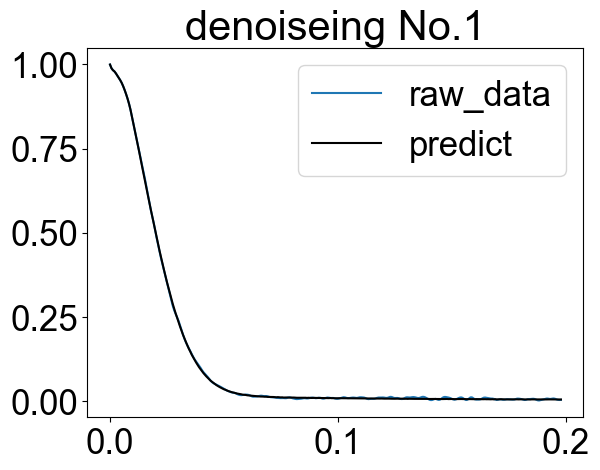

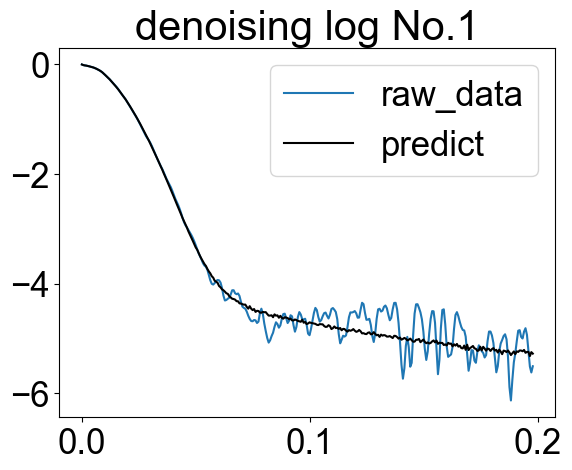

In [28]:
for i in range(len(NMR_data)):
    #real_number_scale
    plt.plot(figsize=(100, 60))
    plt.title(f"denoiseing No.{i+1}")

    plt.plot(NMR_data.columns, NMR_data.iloc[i,:], label='raw_data')
    plt.plot(NMR_data.columns,  CNN_smooth.iloc[i,:], label='predict',color="black")

    plt.legend()
    plt.show()

    #log_scale
    plt.plot(figsize=(100, 60))
    plt.title(f"denoising log No.{i+1}")

    plt.plot(NMR_data.columns, np.log(NMR_data.iloc[i,:]), label='raw_data')
    plt.plot(NMR_data.columns,  np.log(CNN_smooth.iloc[i,:]), label='predict',color="black")

    plt.legend()
    plt.show()
    break

In [22]:
SS_X=StandardScaler()
SS_X.fit((NMR_data))
ss_x=SS_X.transform((NMR_data))

print(np.mean(ss_x))
print(np.std(ss_x))

SS_Y=StandardScaler()
SS_Y.fit(np.array(physics_data["y1"]).reshape(-1,1))
ss_y=SS_Y.transform(np.array(physics_data["y1"]).reshape(-1,1))
print(np.mean(ss_y))
print(np.std(ss_y))

X_train,X_test,y_train,y_test=train_test_split(ss_x,ss_y,test_size=0.3,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

1.0356463736351555e-15
0.9983857939435973
4.147009533158673e-16
1.0
(47, 310) (21, 310) (47, 1) (21, 1)


In [23]:
SS_CNN_pred=StandardScaler()
SS_CNN_pred.fit(CNN_smooth)
ss_CNN_pred=SS_CNN_pred.transform(CNN_smooth)

print(np.mean(ss_CNN_pred))
print(np.std(ss_CNN_pred))

X_train_CNN,X_test_CNN,y_train,y_test=train_test_split(ss_CNN_pred,ss_y,test_size=0.3,random_state=0)
print(X_train_CNN.shape,X_test_CNN.shape,y_train.shape,y_test.shape)

-1.1581624e-08
1.0
(47, 310) (21, 310) (47, 1) (21, 1)


y1
CNN_trainデータの決定係数0.9672525128831465
CNN_testデータの決定係数0.9080589466788603


<Figure size 3840x2880 with 0 Axes>

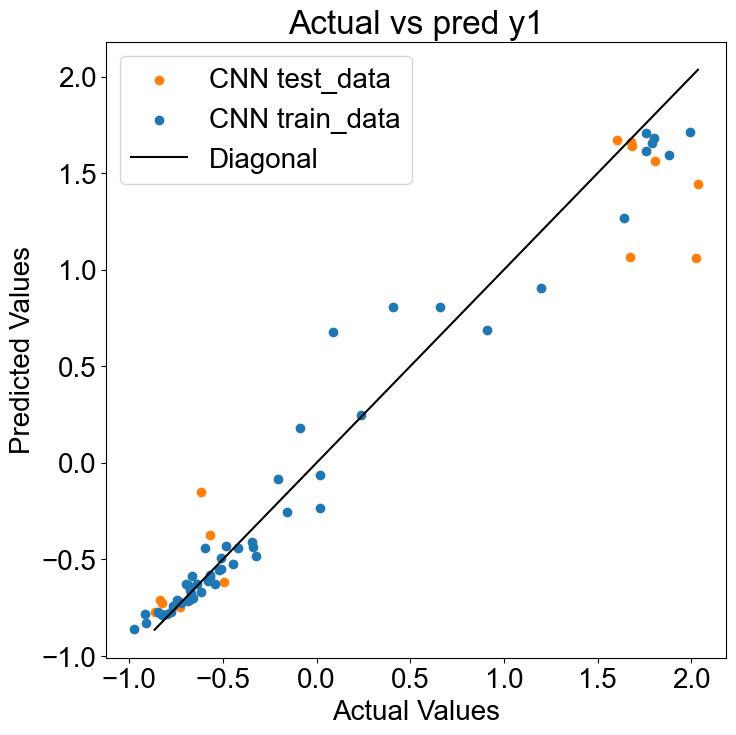

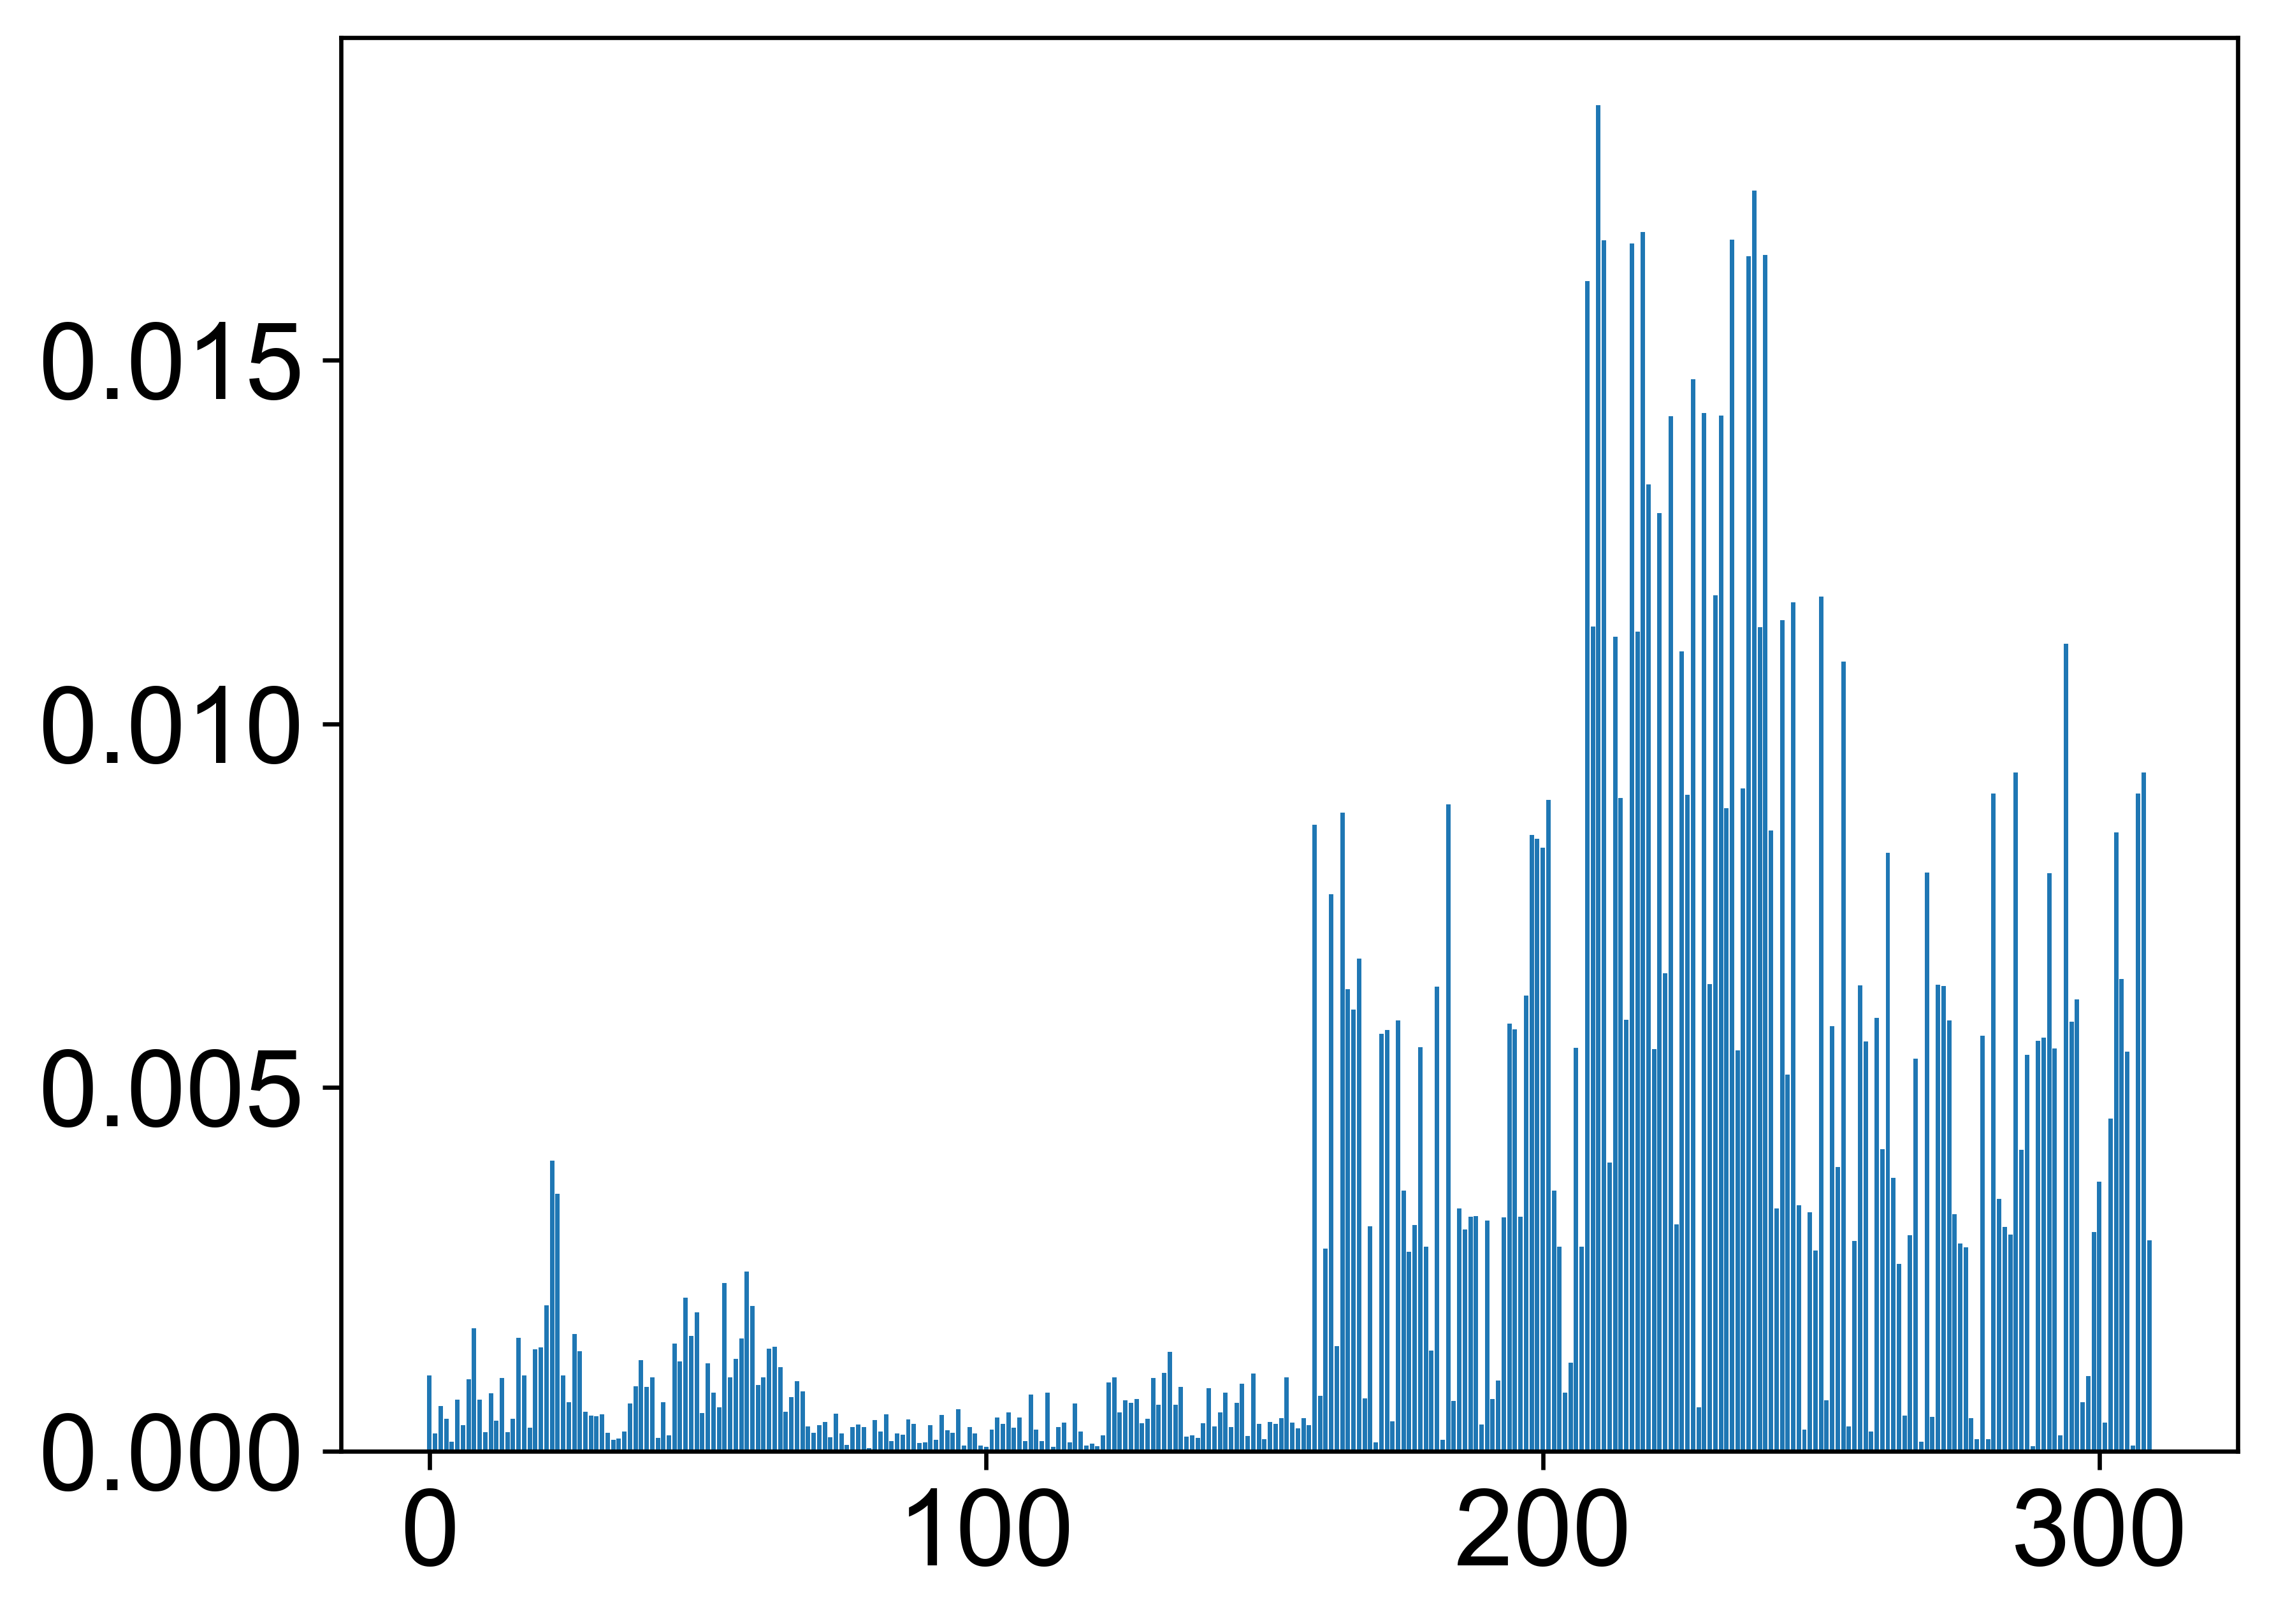

trainデータの決定係数0.9397747307241842
testデータの決定係数0.5400620977932433


<Figure size 3840x2880 with 0 Axes>

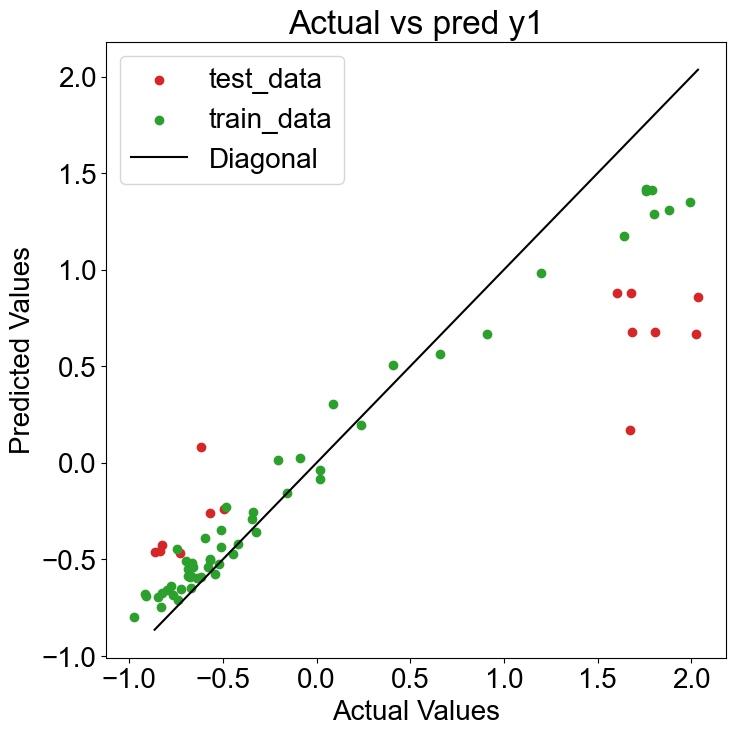

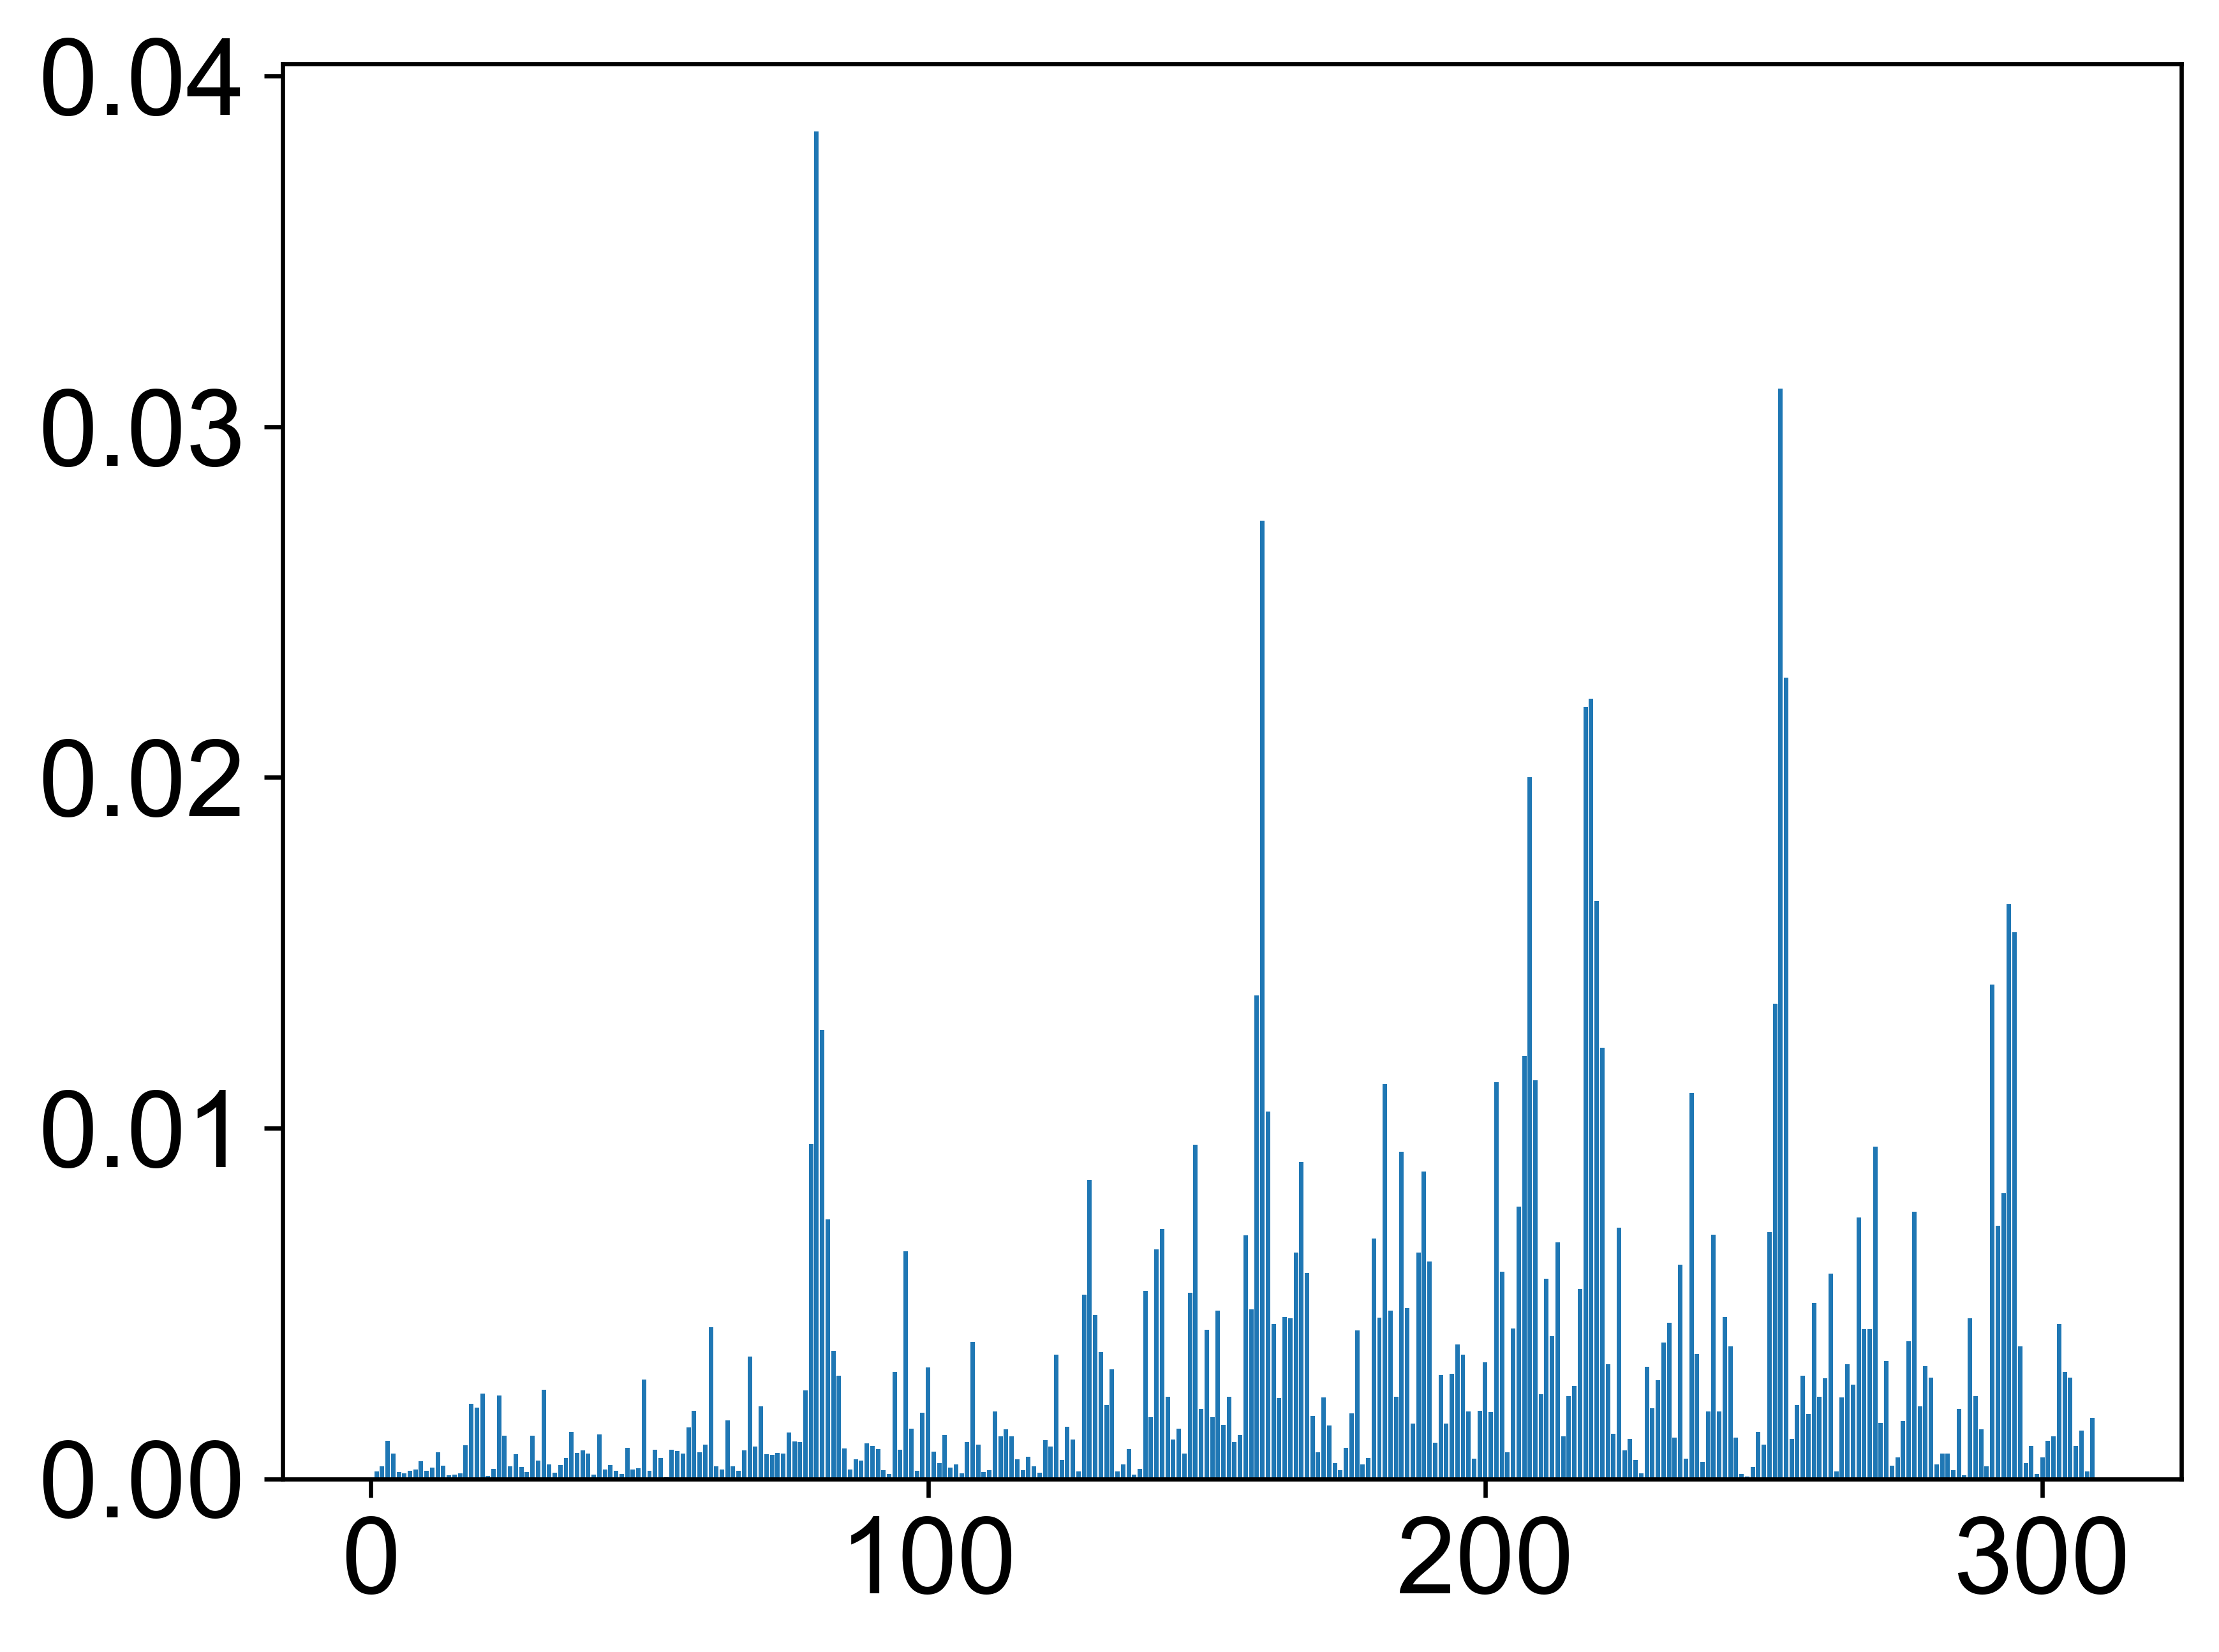

y2
CNN_trainデータの決定係数0.9499481308339701
CNN_testデータの決定係数0.4847799207675163


<Figure size 3840x2880 with 0 Axes>

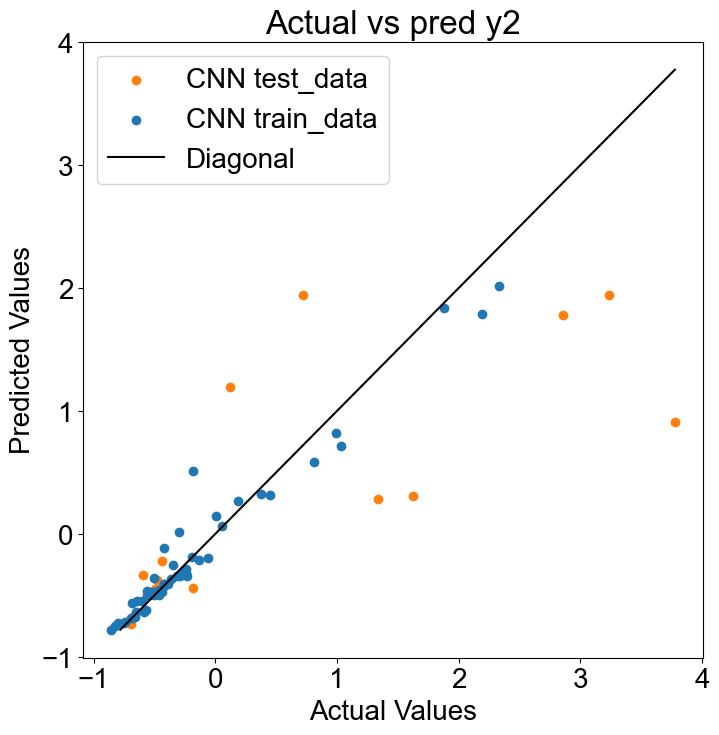

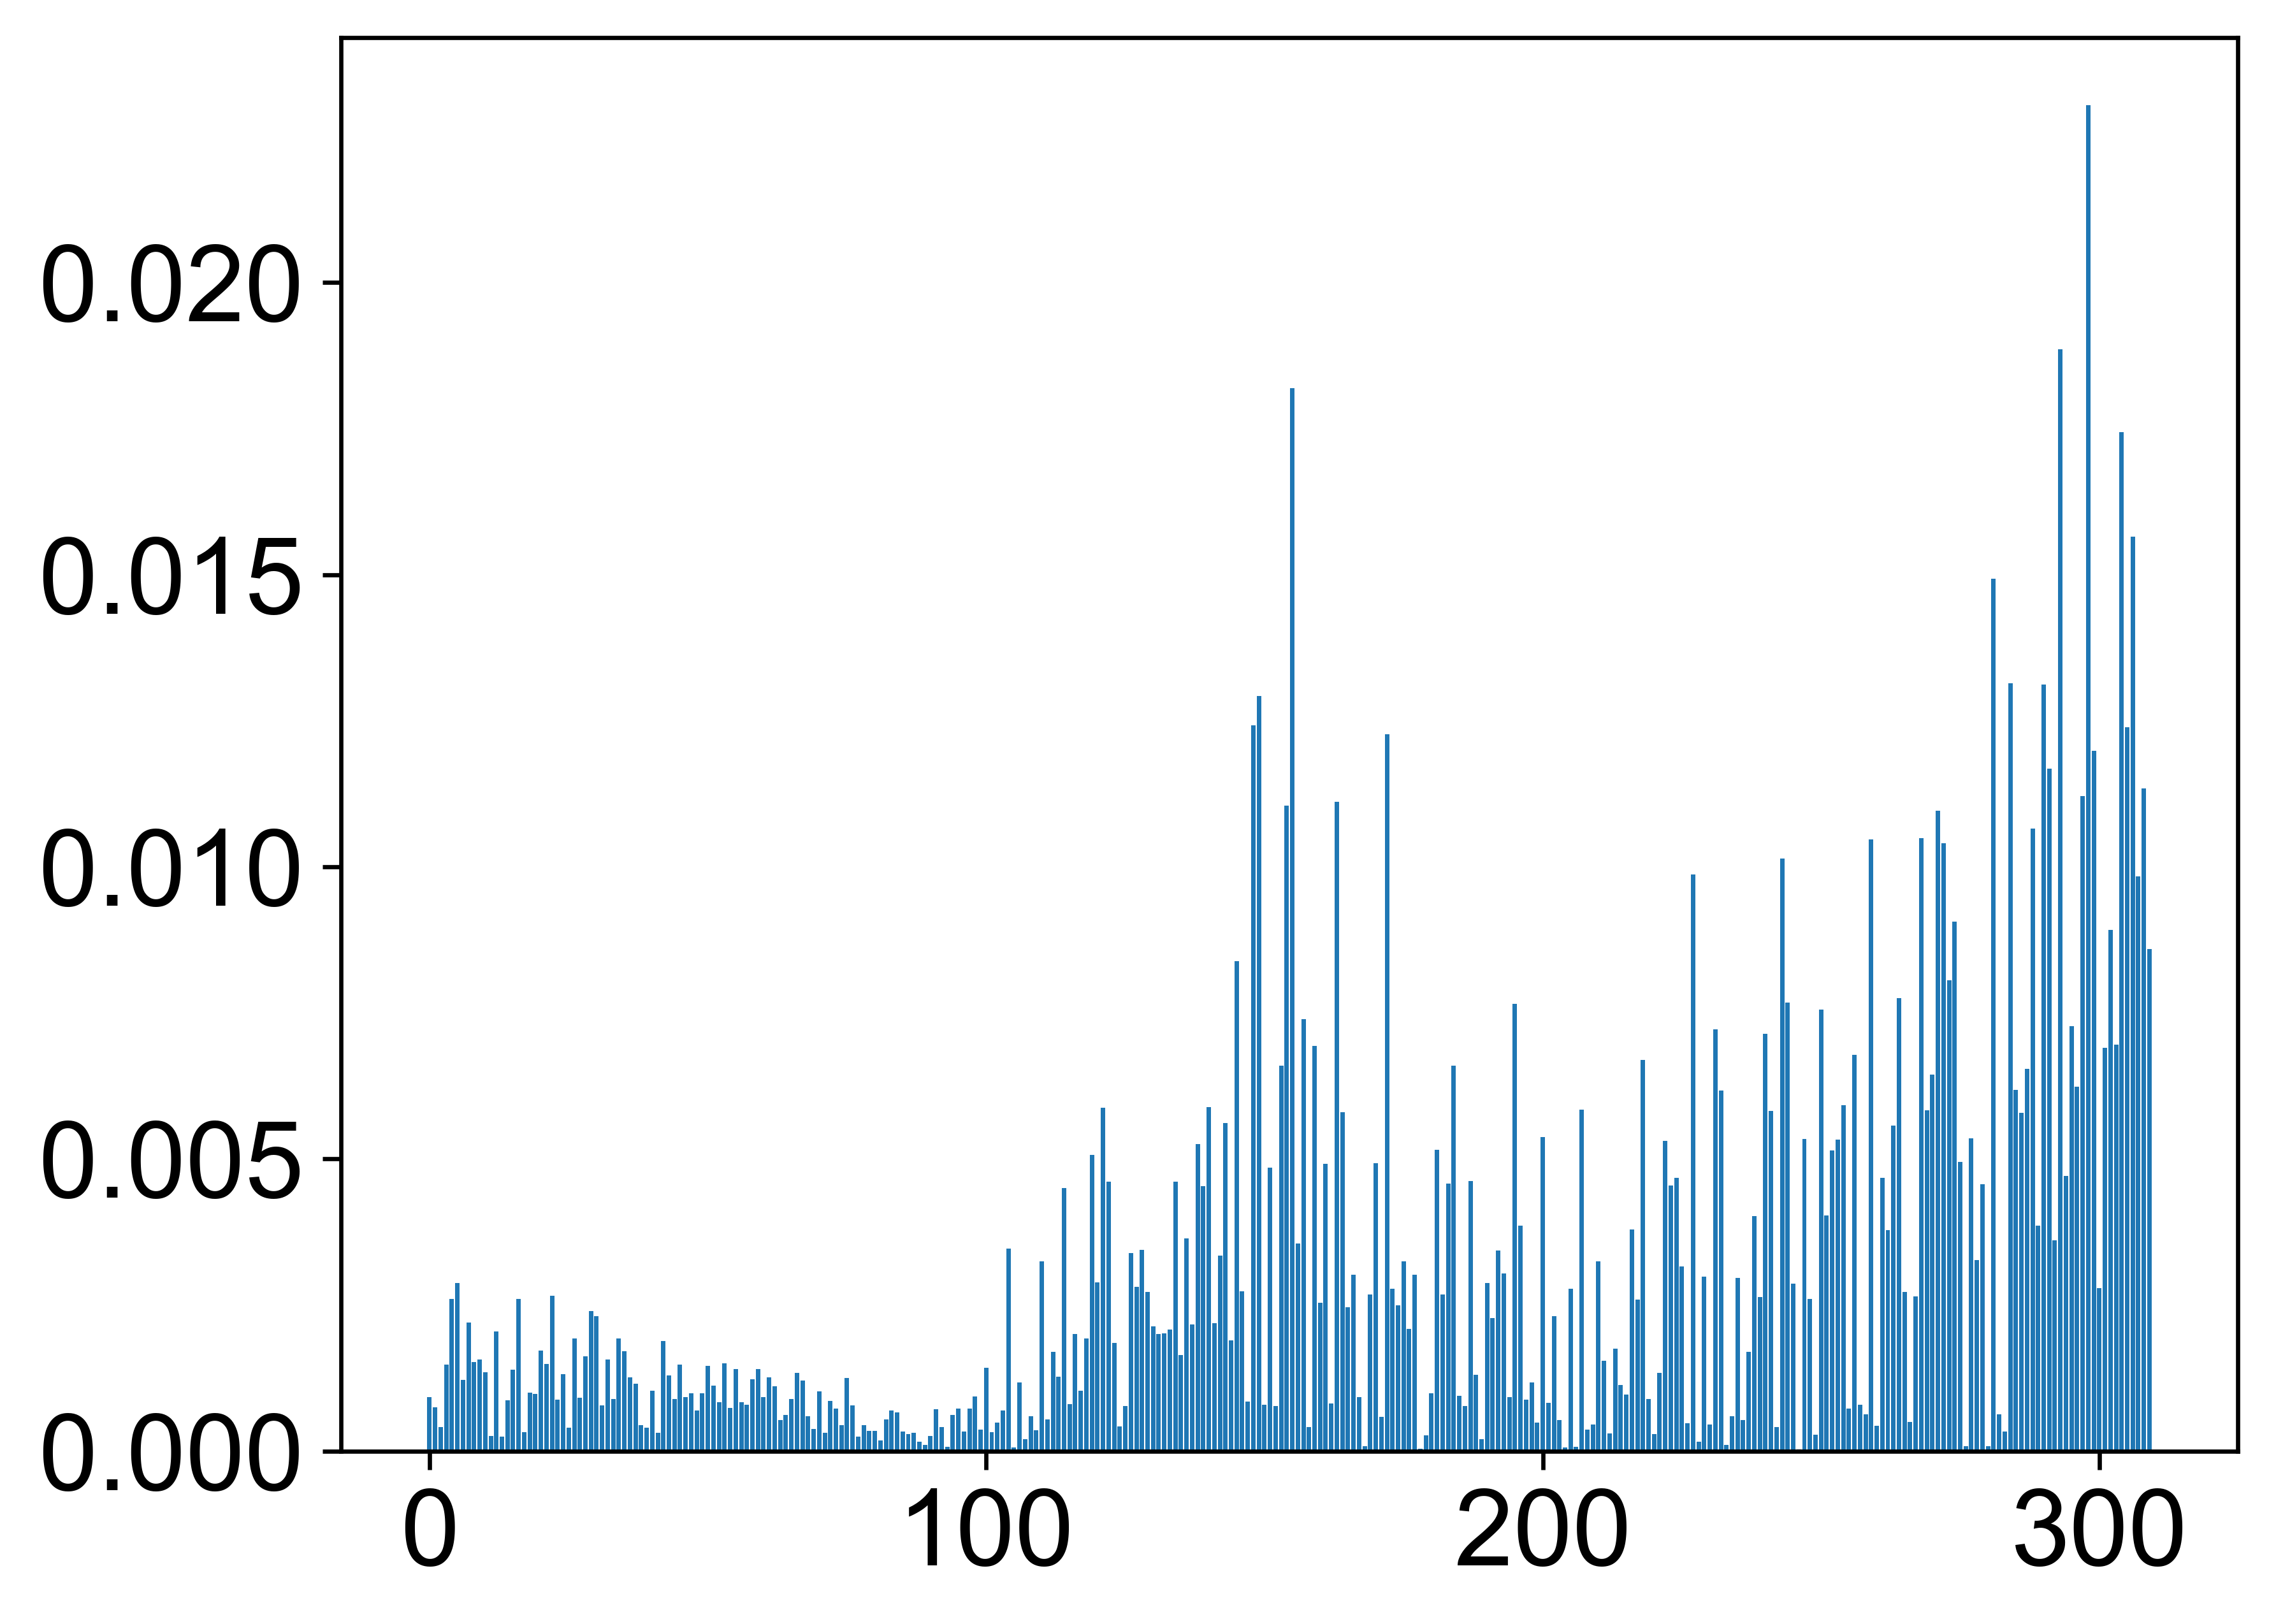

trainデータの決定係数0.9248715114801767
testデータの決定係数0.13170644281685218


<Figure size 3840x2880 with 0 Axes>

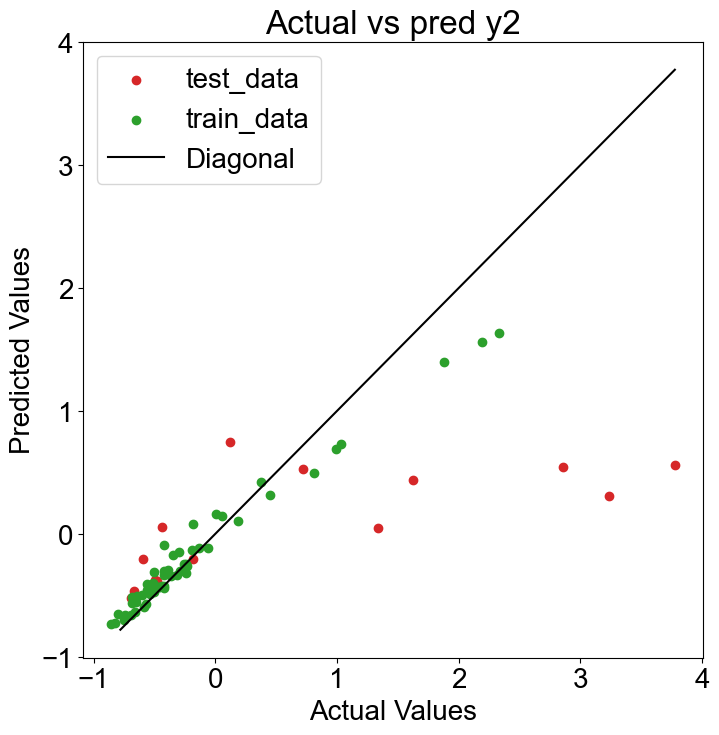

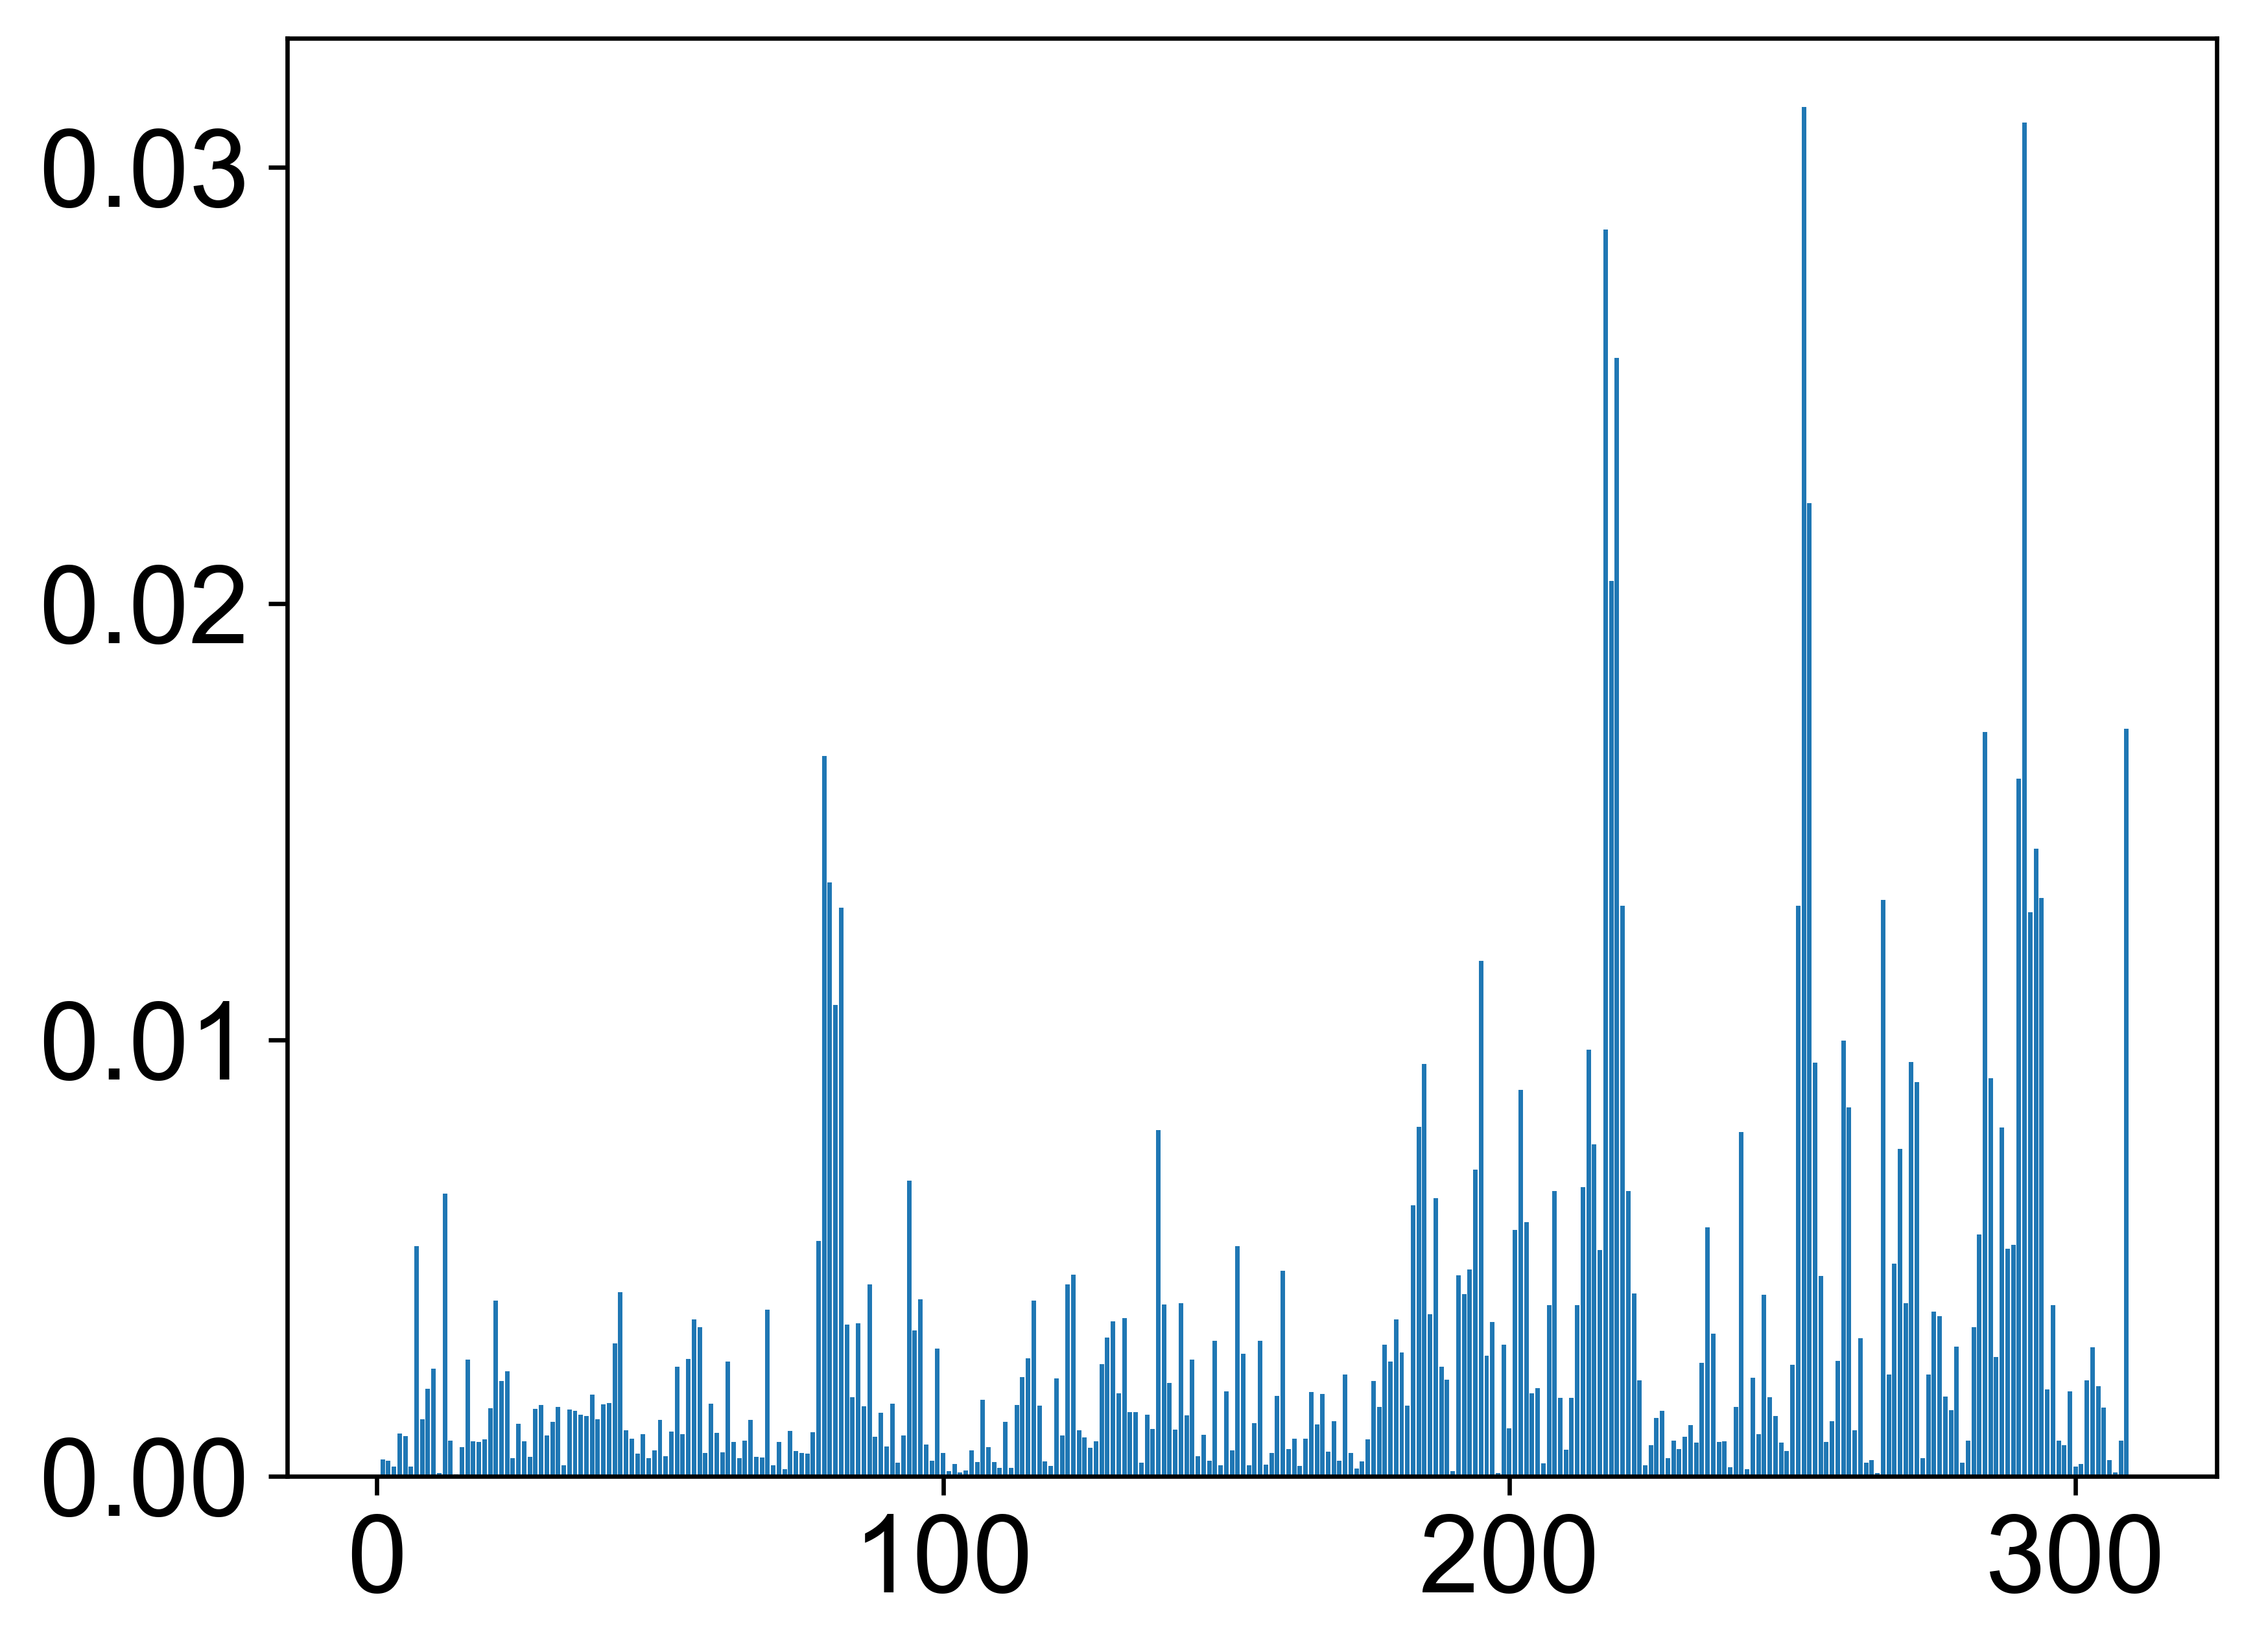

y3
CNN_trainデータの決定係数0.9127687253459431
CNN_testデータの決定係数0.6267708210201234


<Figure size 3840x2880 with 0 Axes>

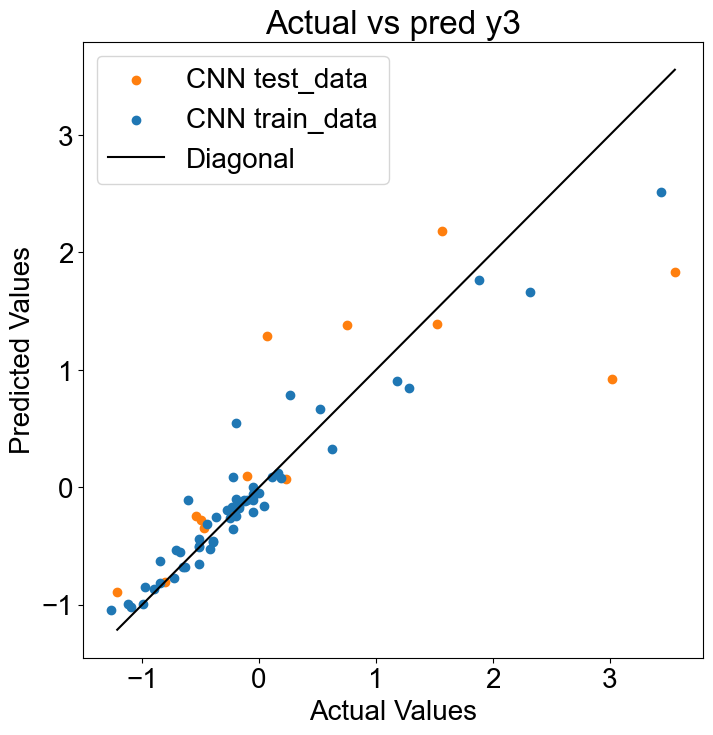

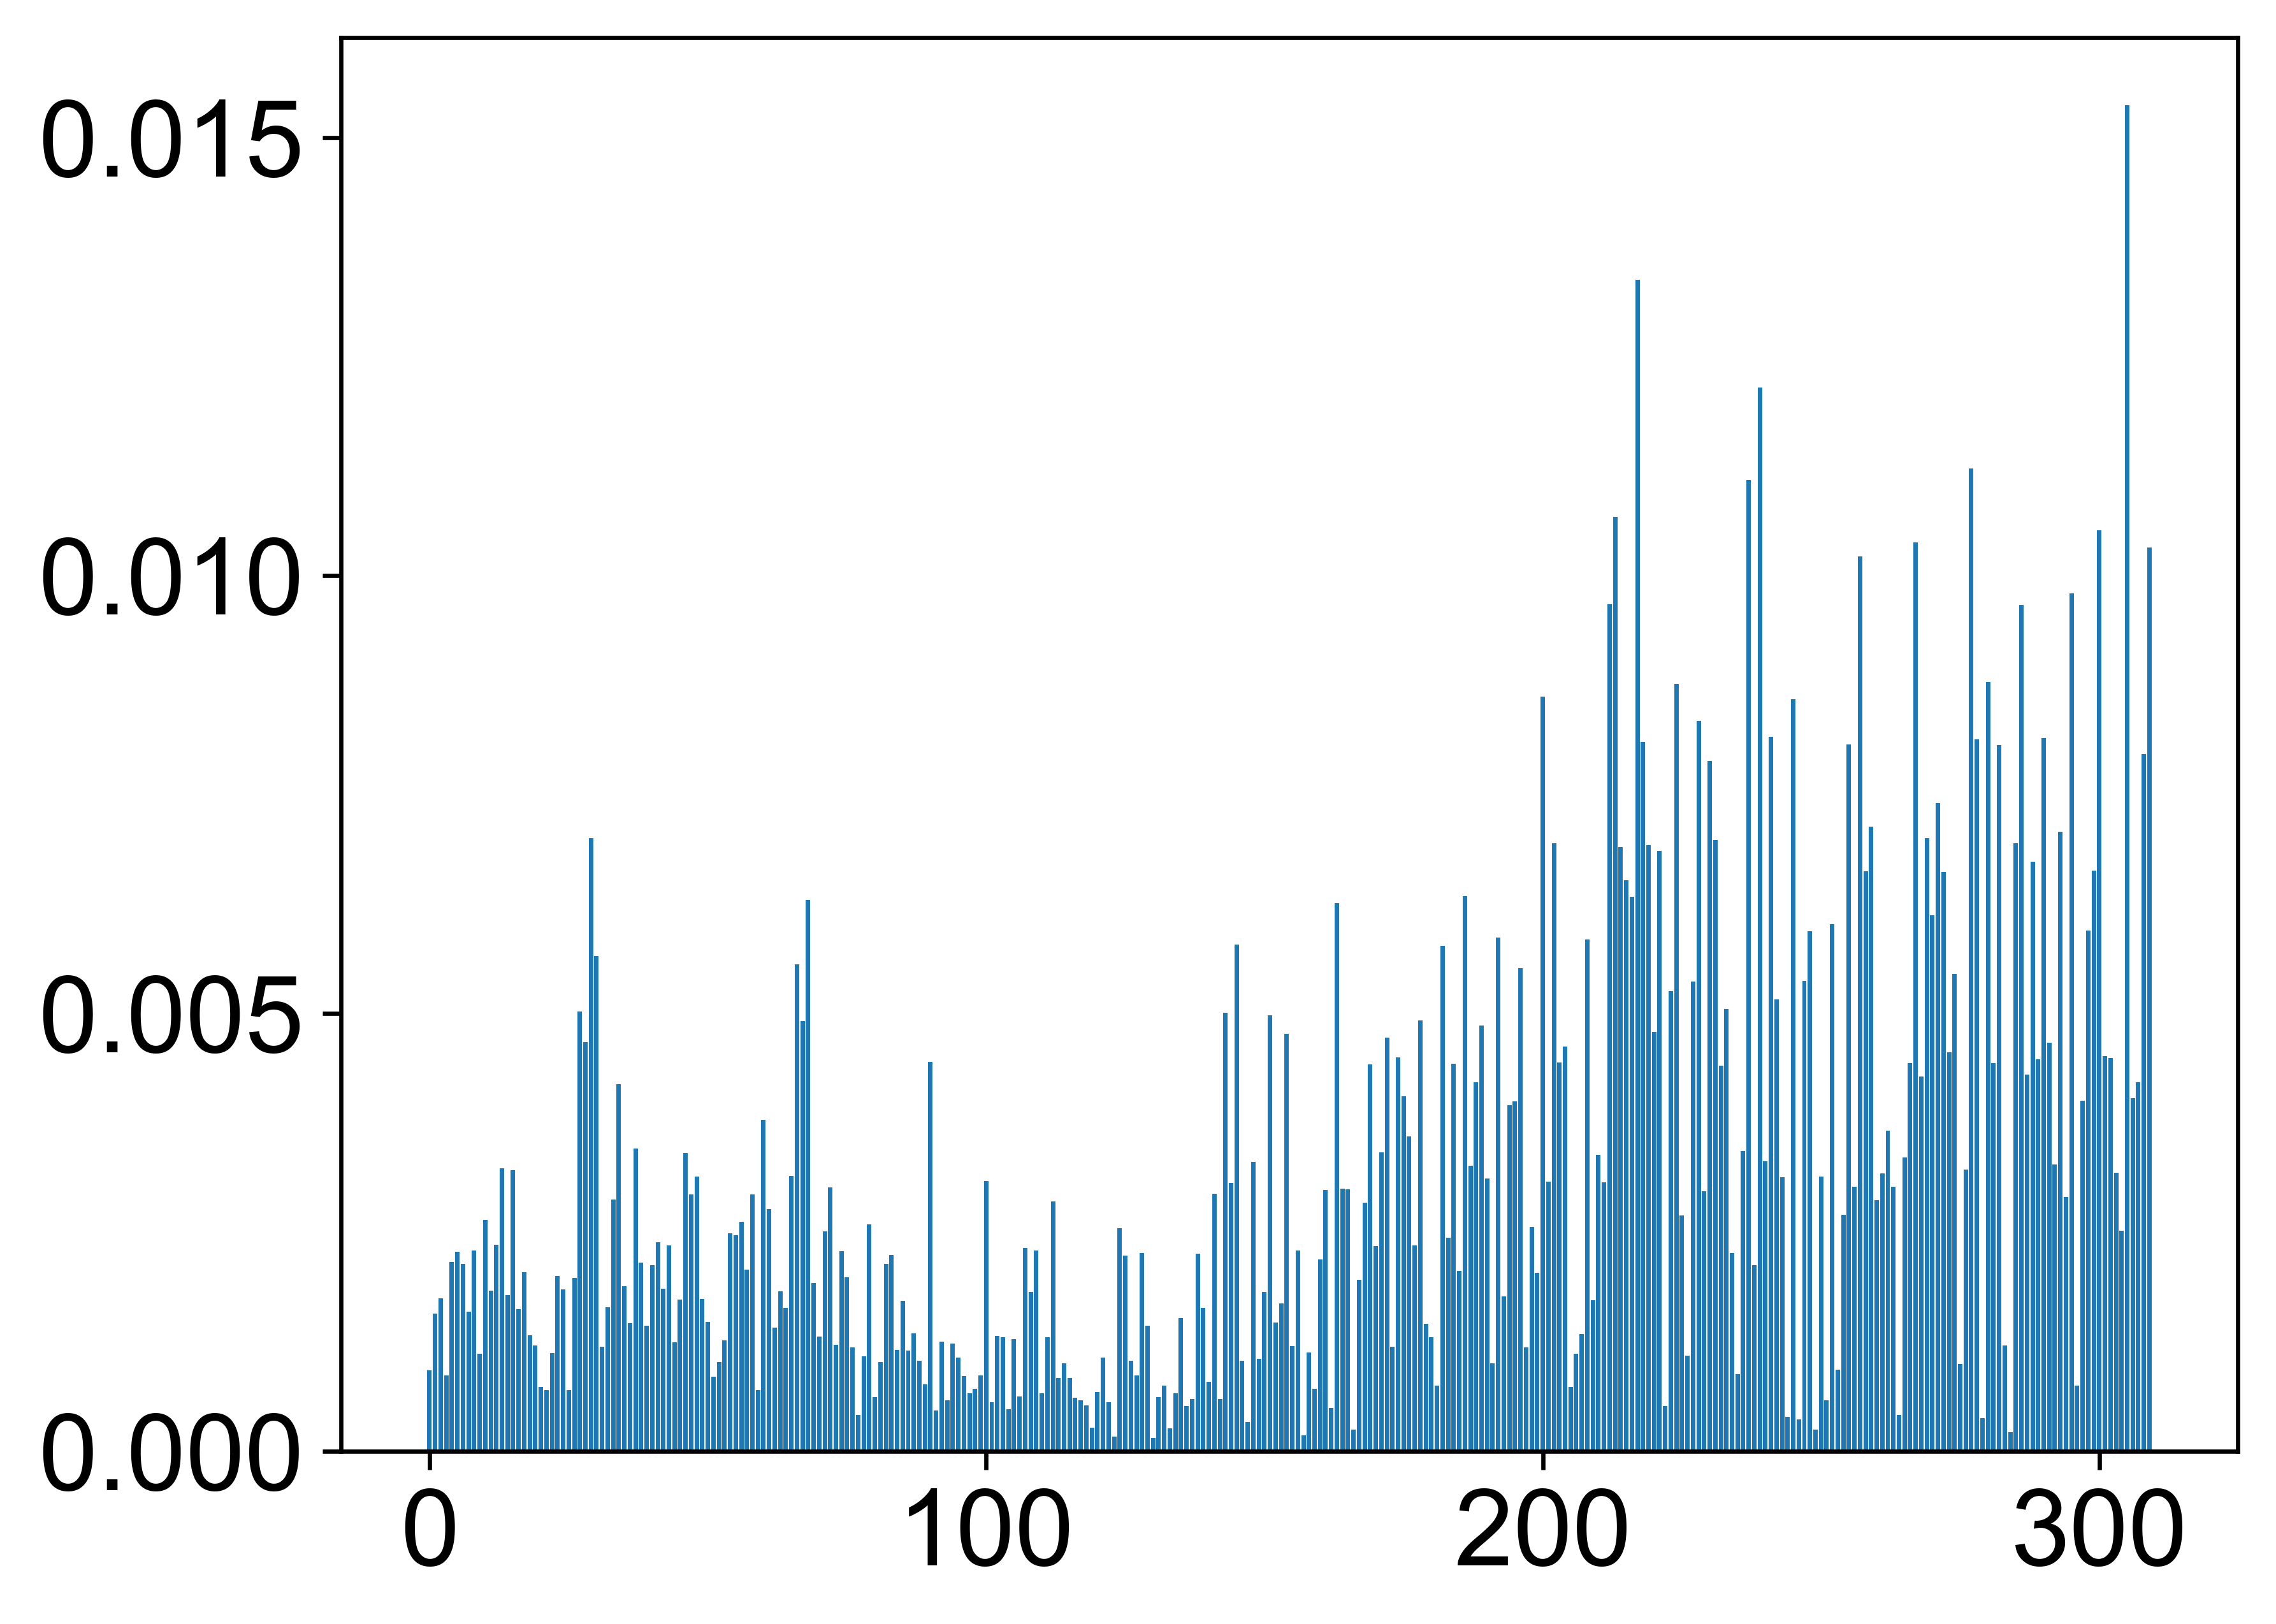

trainデータの決定係数0.9182931511922033
testデータの決定係数0.42906779772749004


<Figure size 3840x2880 with 0 Axes>

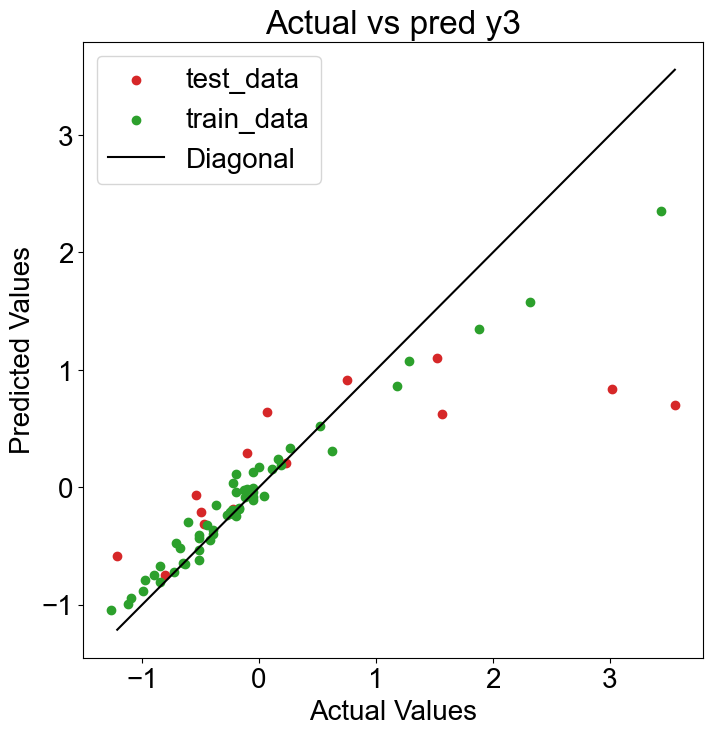

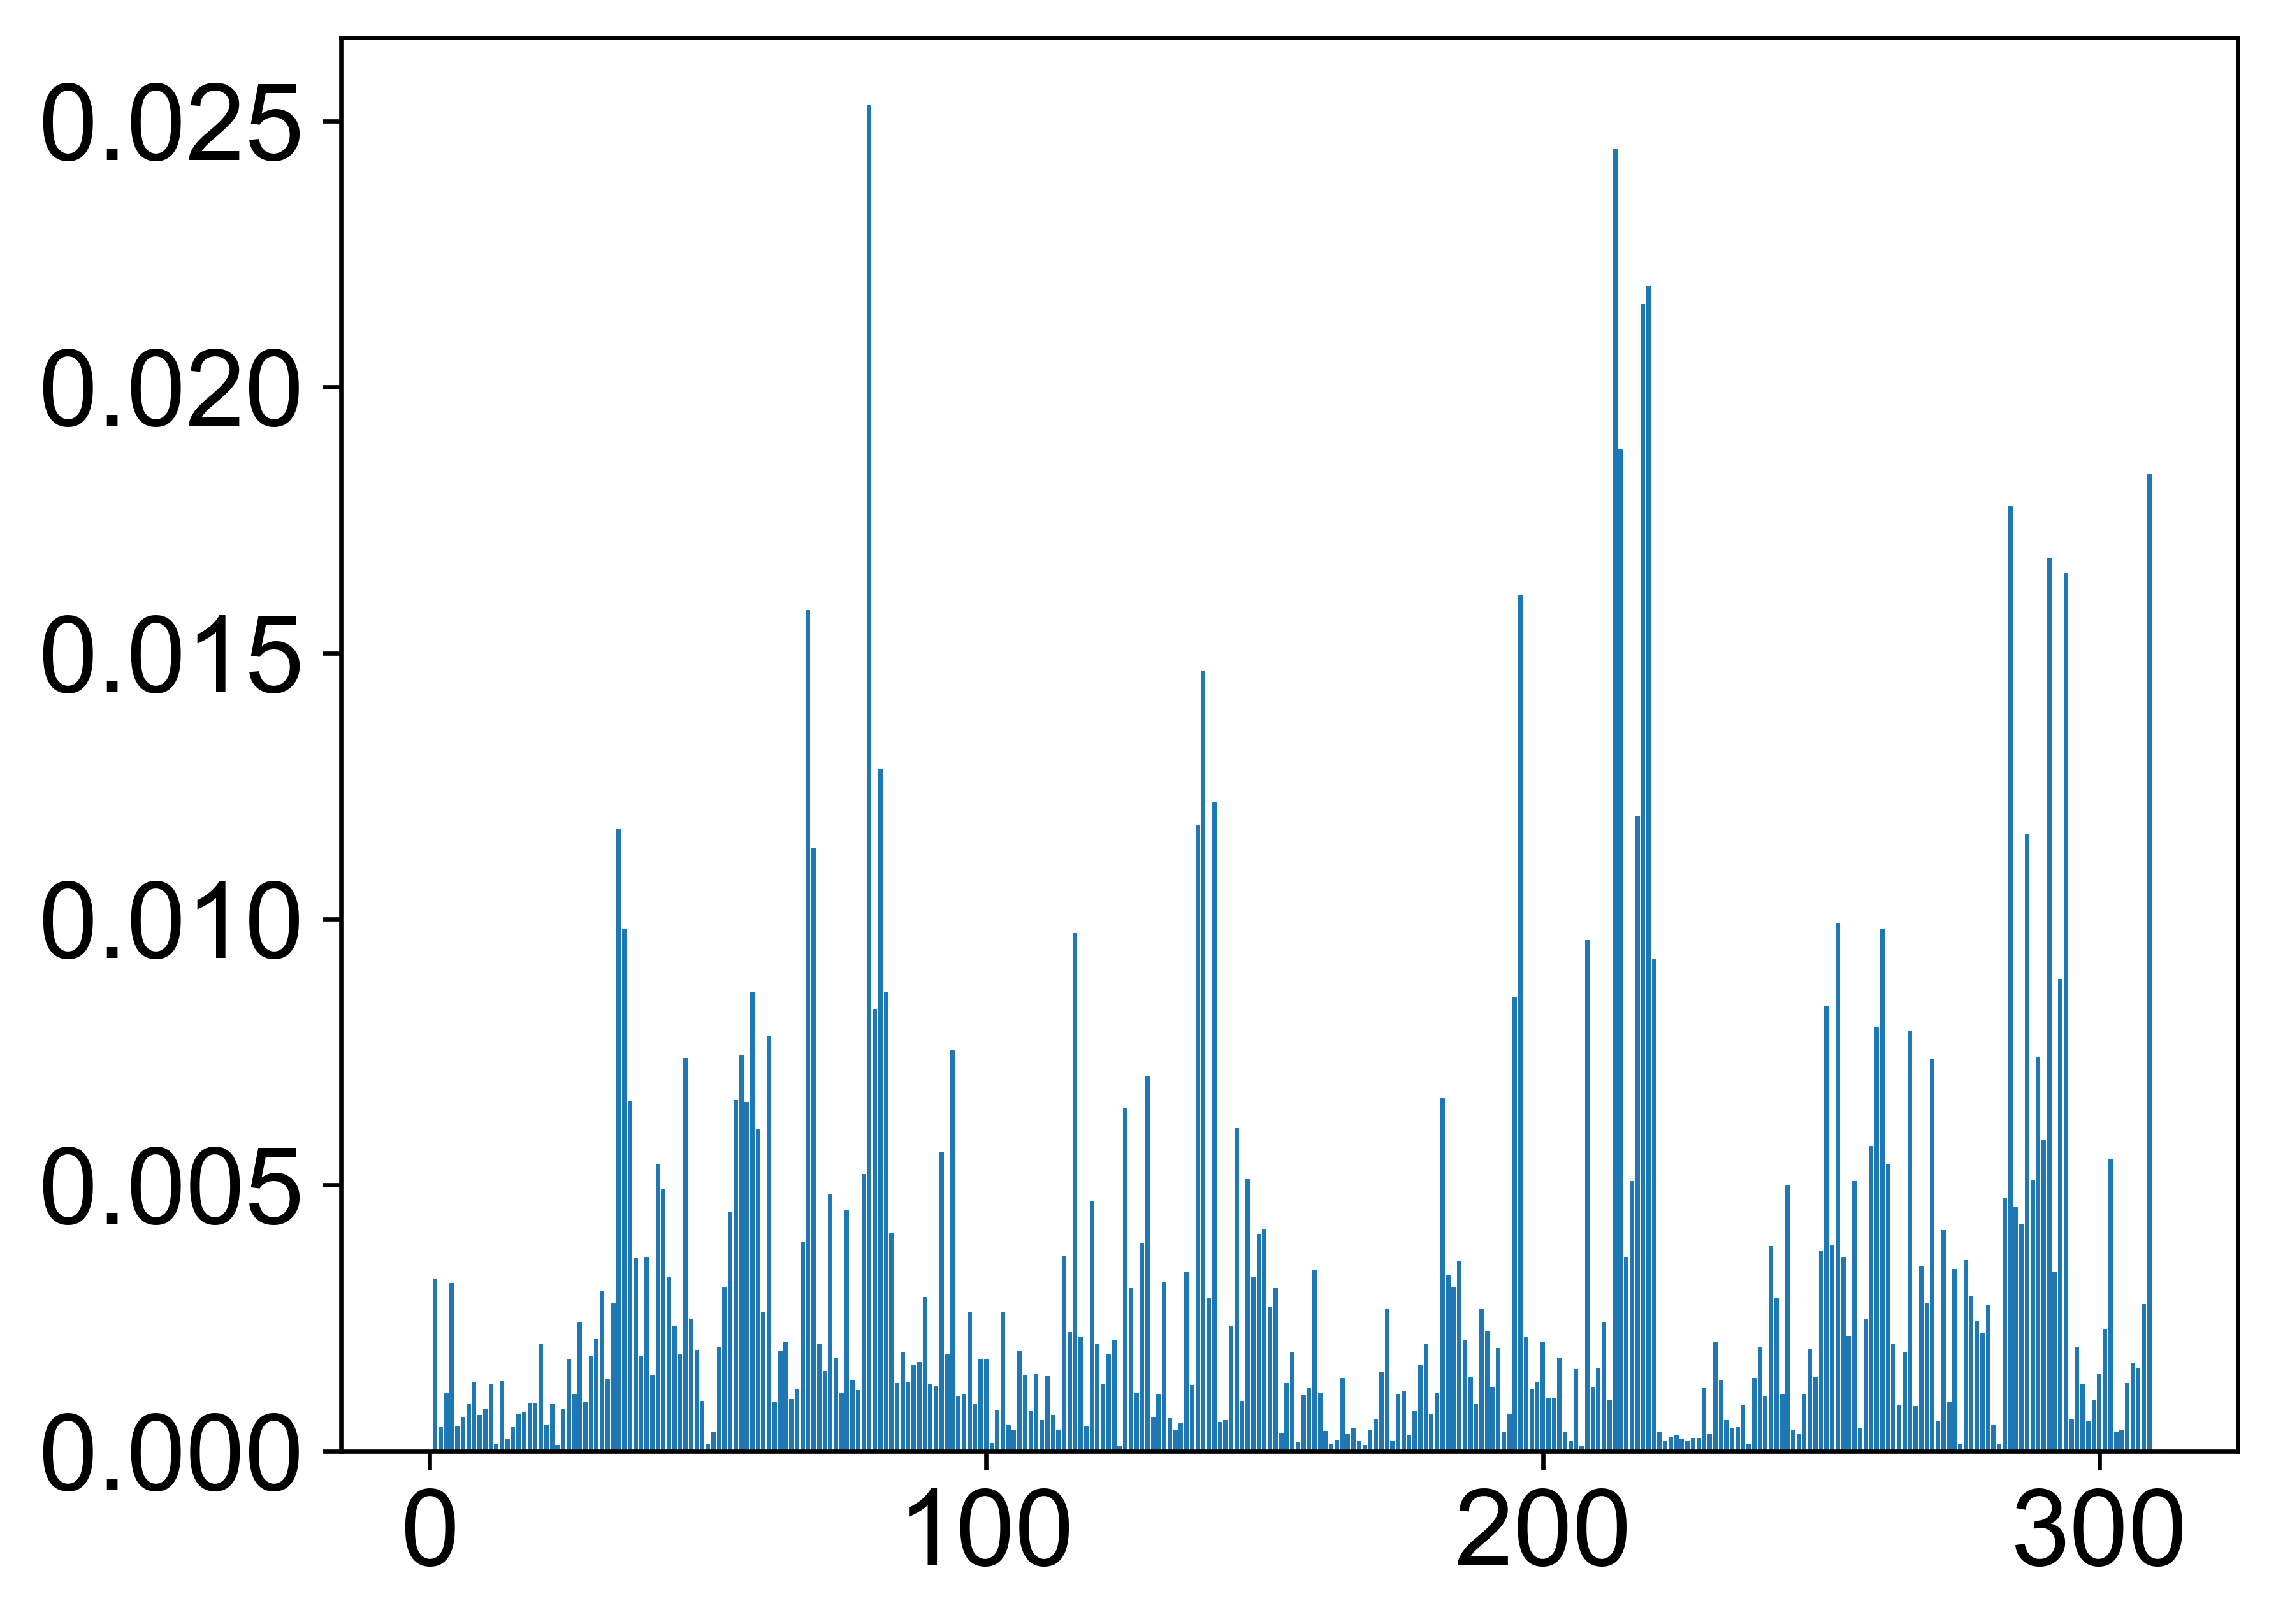

y4
CNN_trainデータの決定係数0.9281570536626809
CNN_testデータの決定係数0.8658157862758202


<Figure size 3840x2880 with 0 Axes>

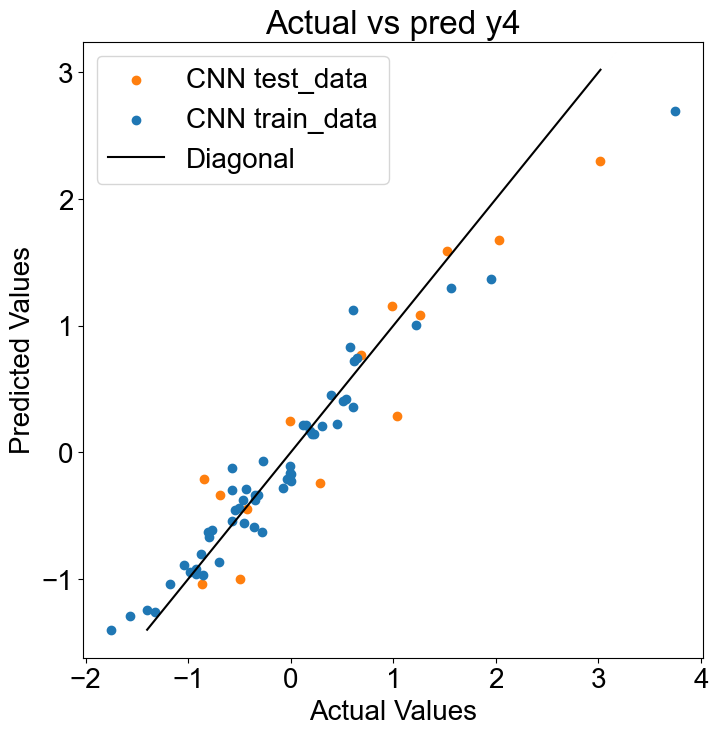

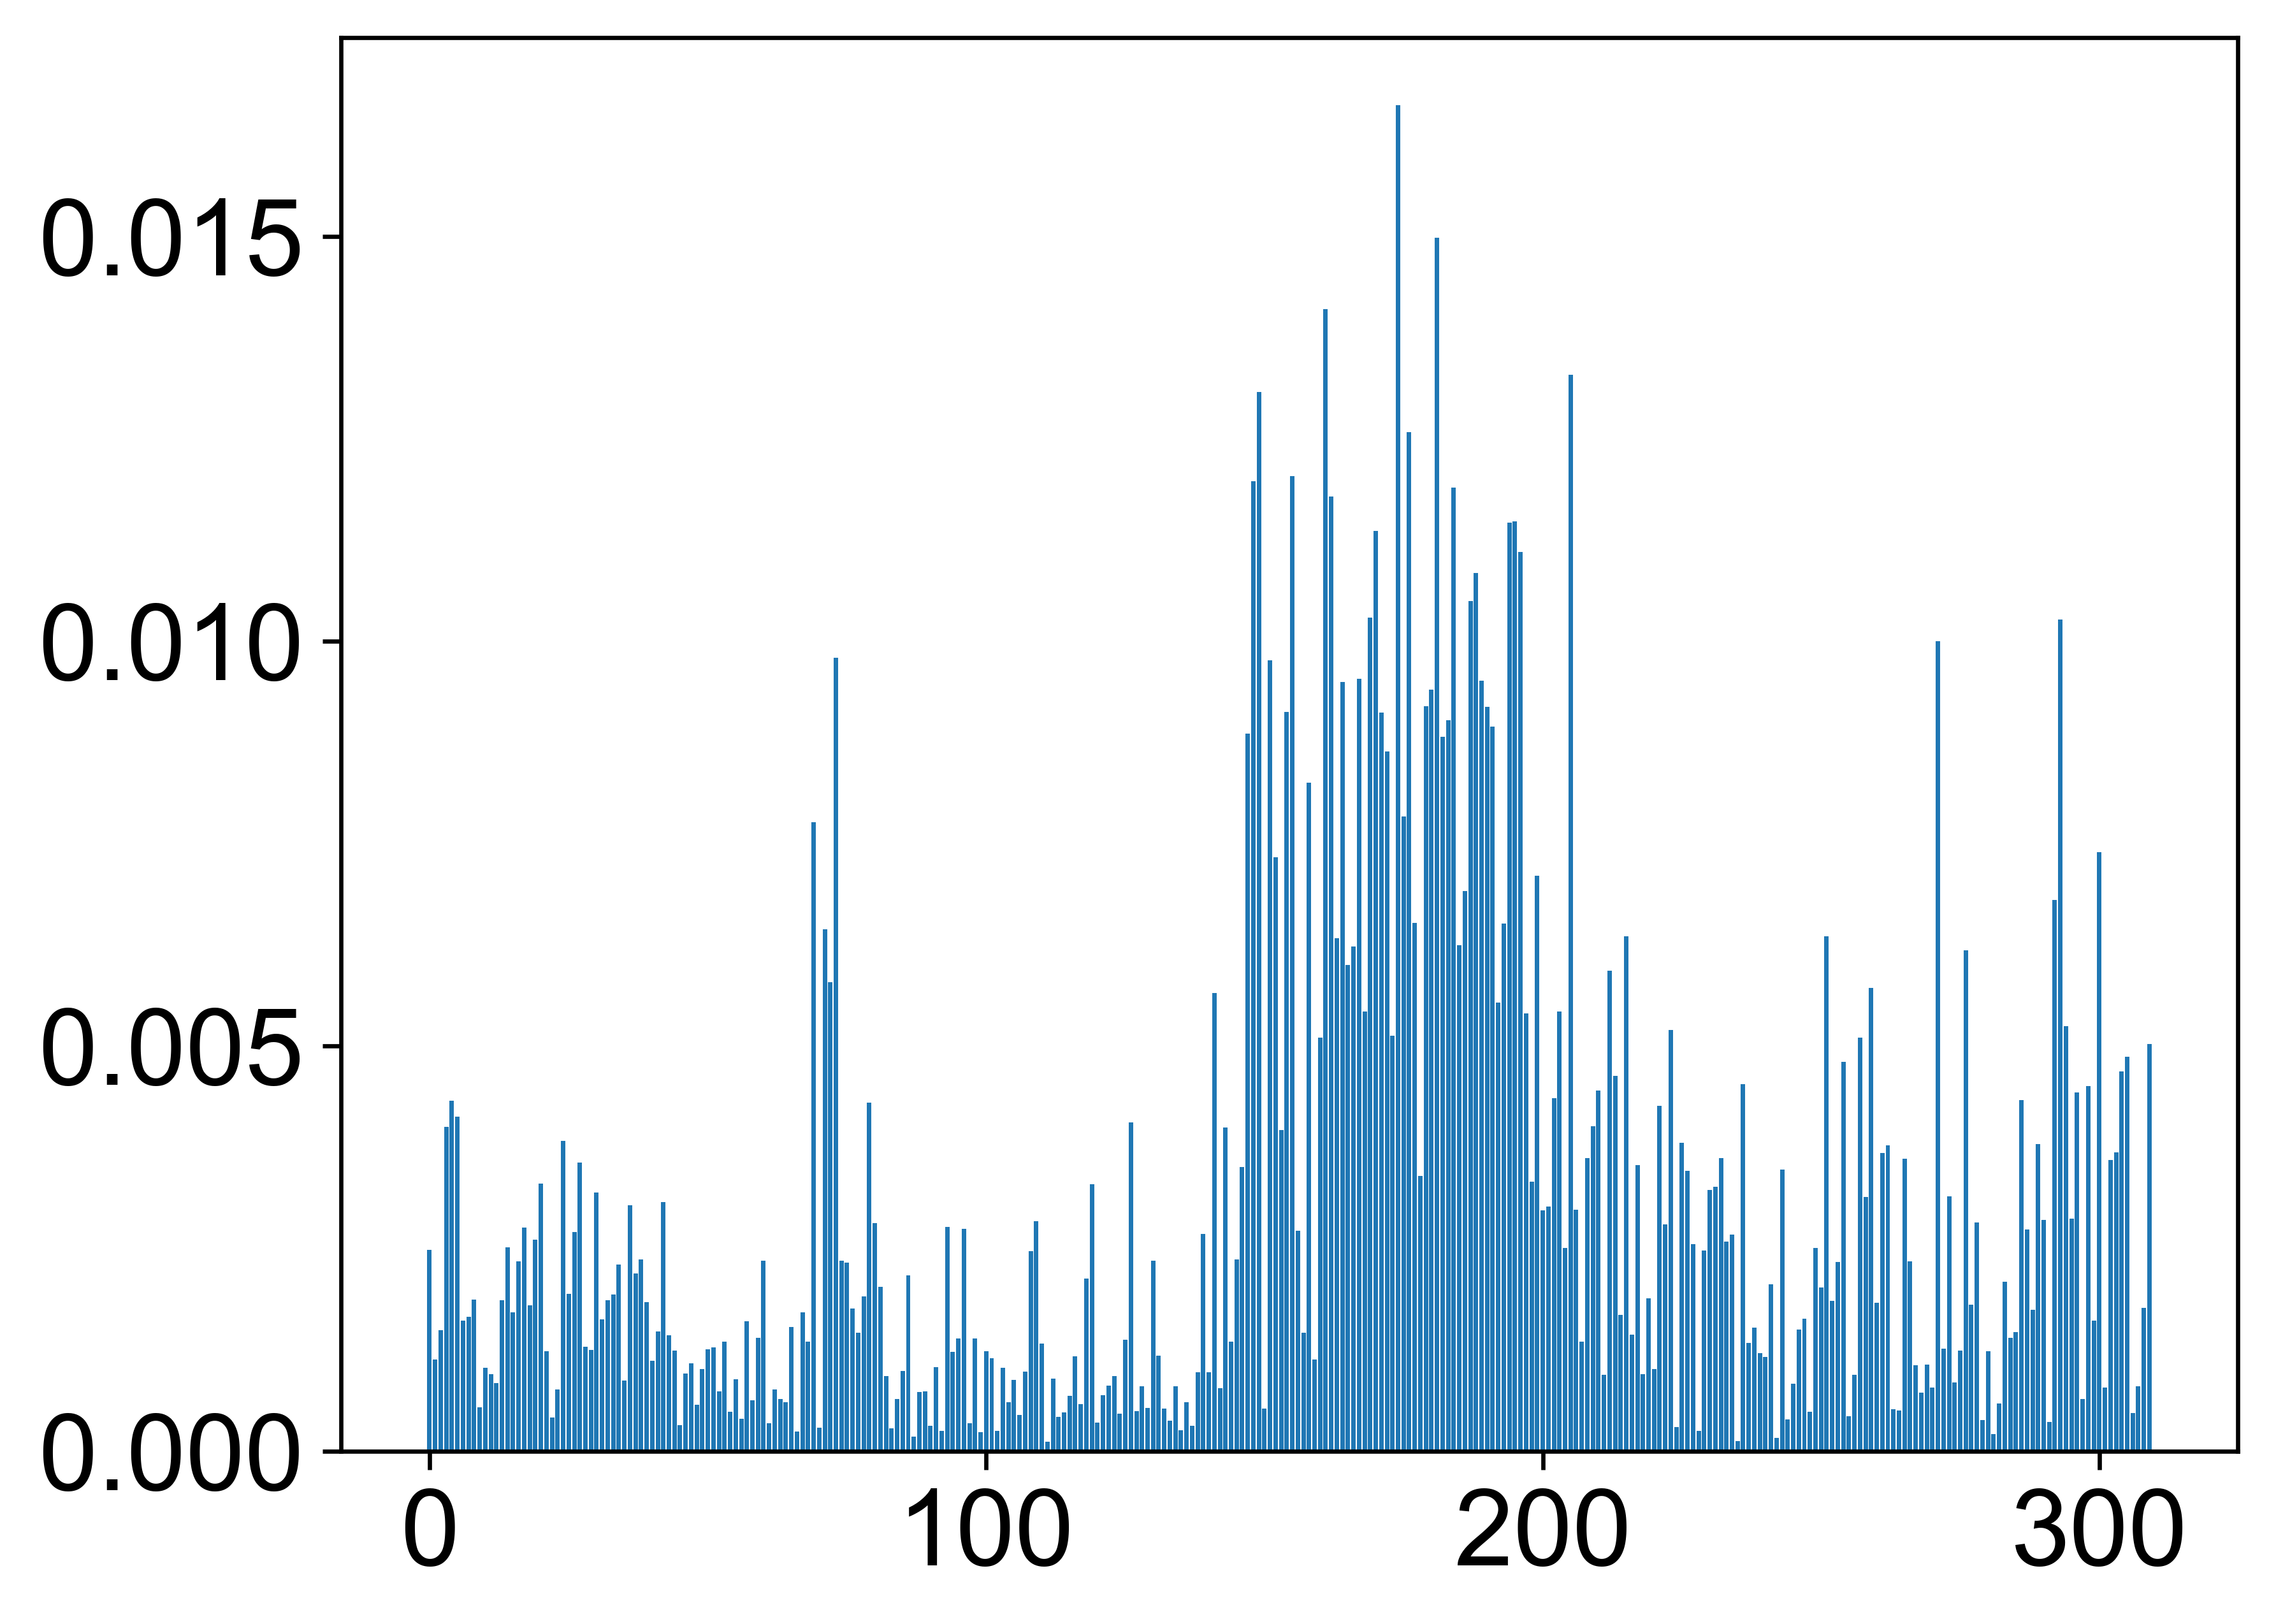

trainデータの決定係数0.9124991353335863
testデータの決定係数0.41261350649977413


<Figure size 3840x2880 with 0 Axes>

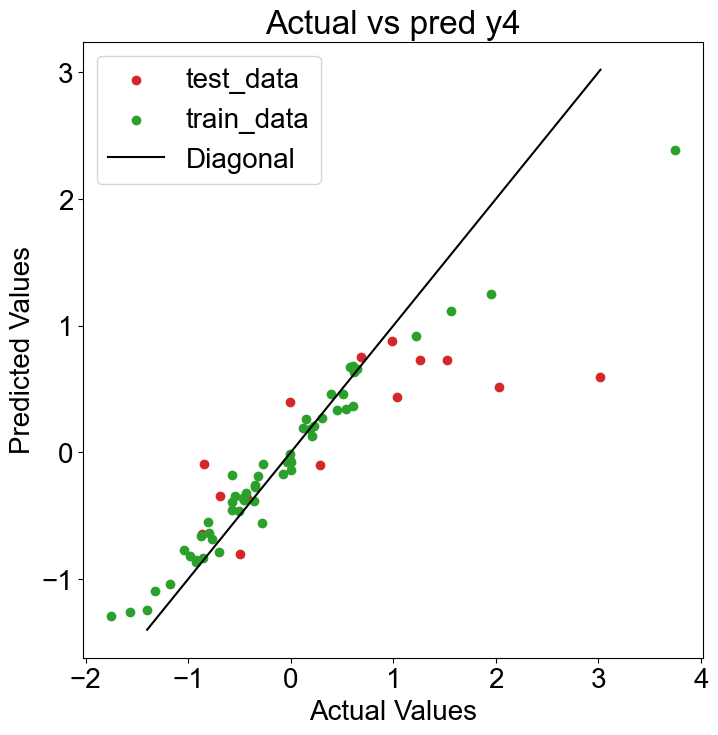

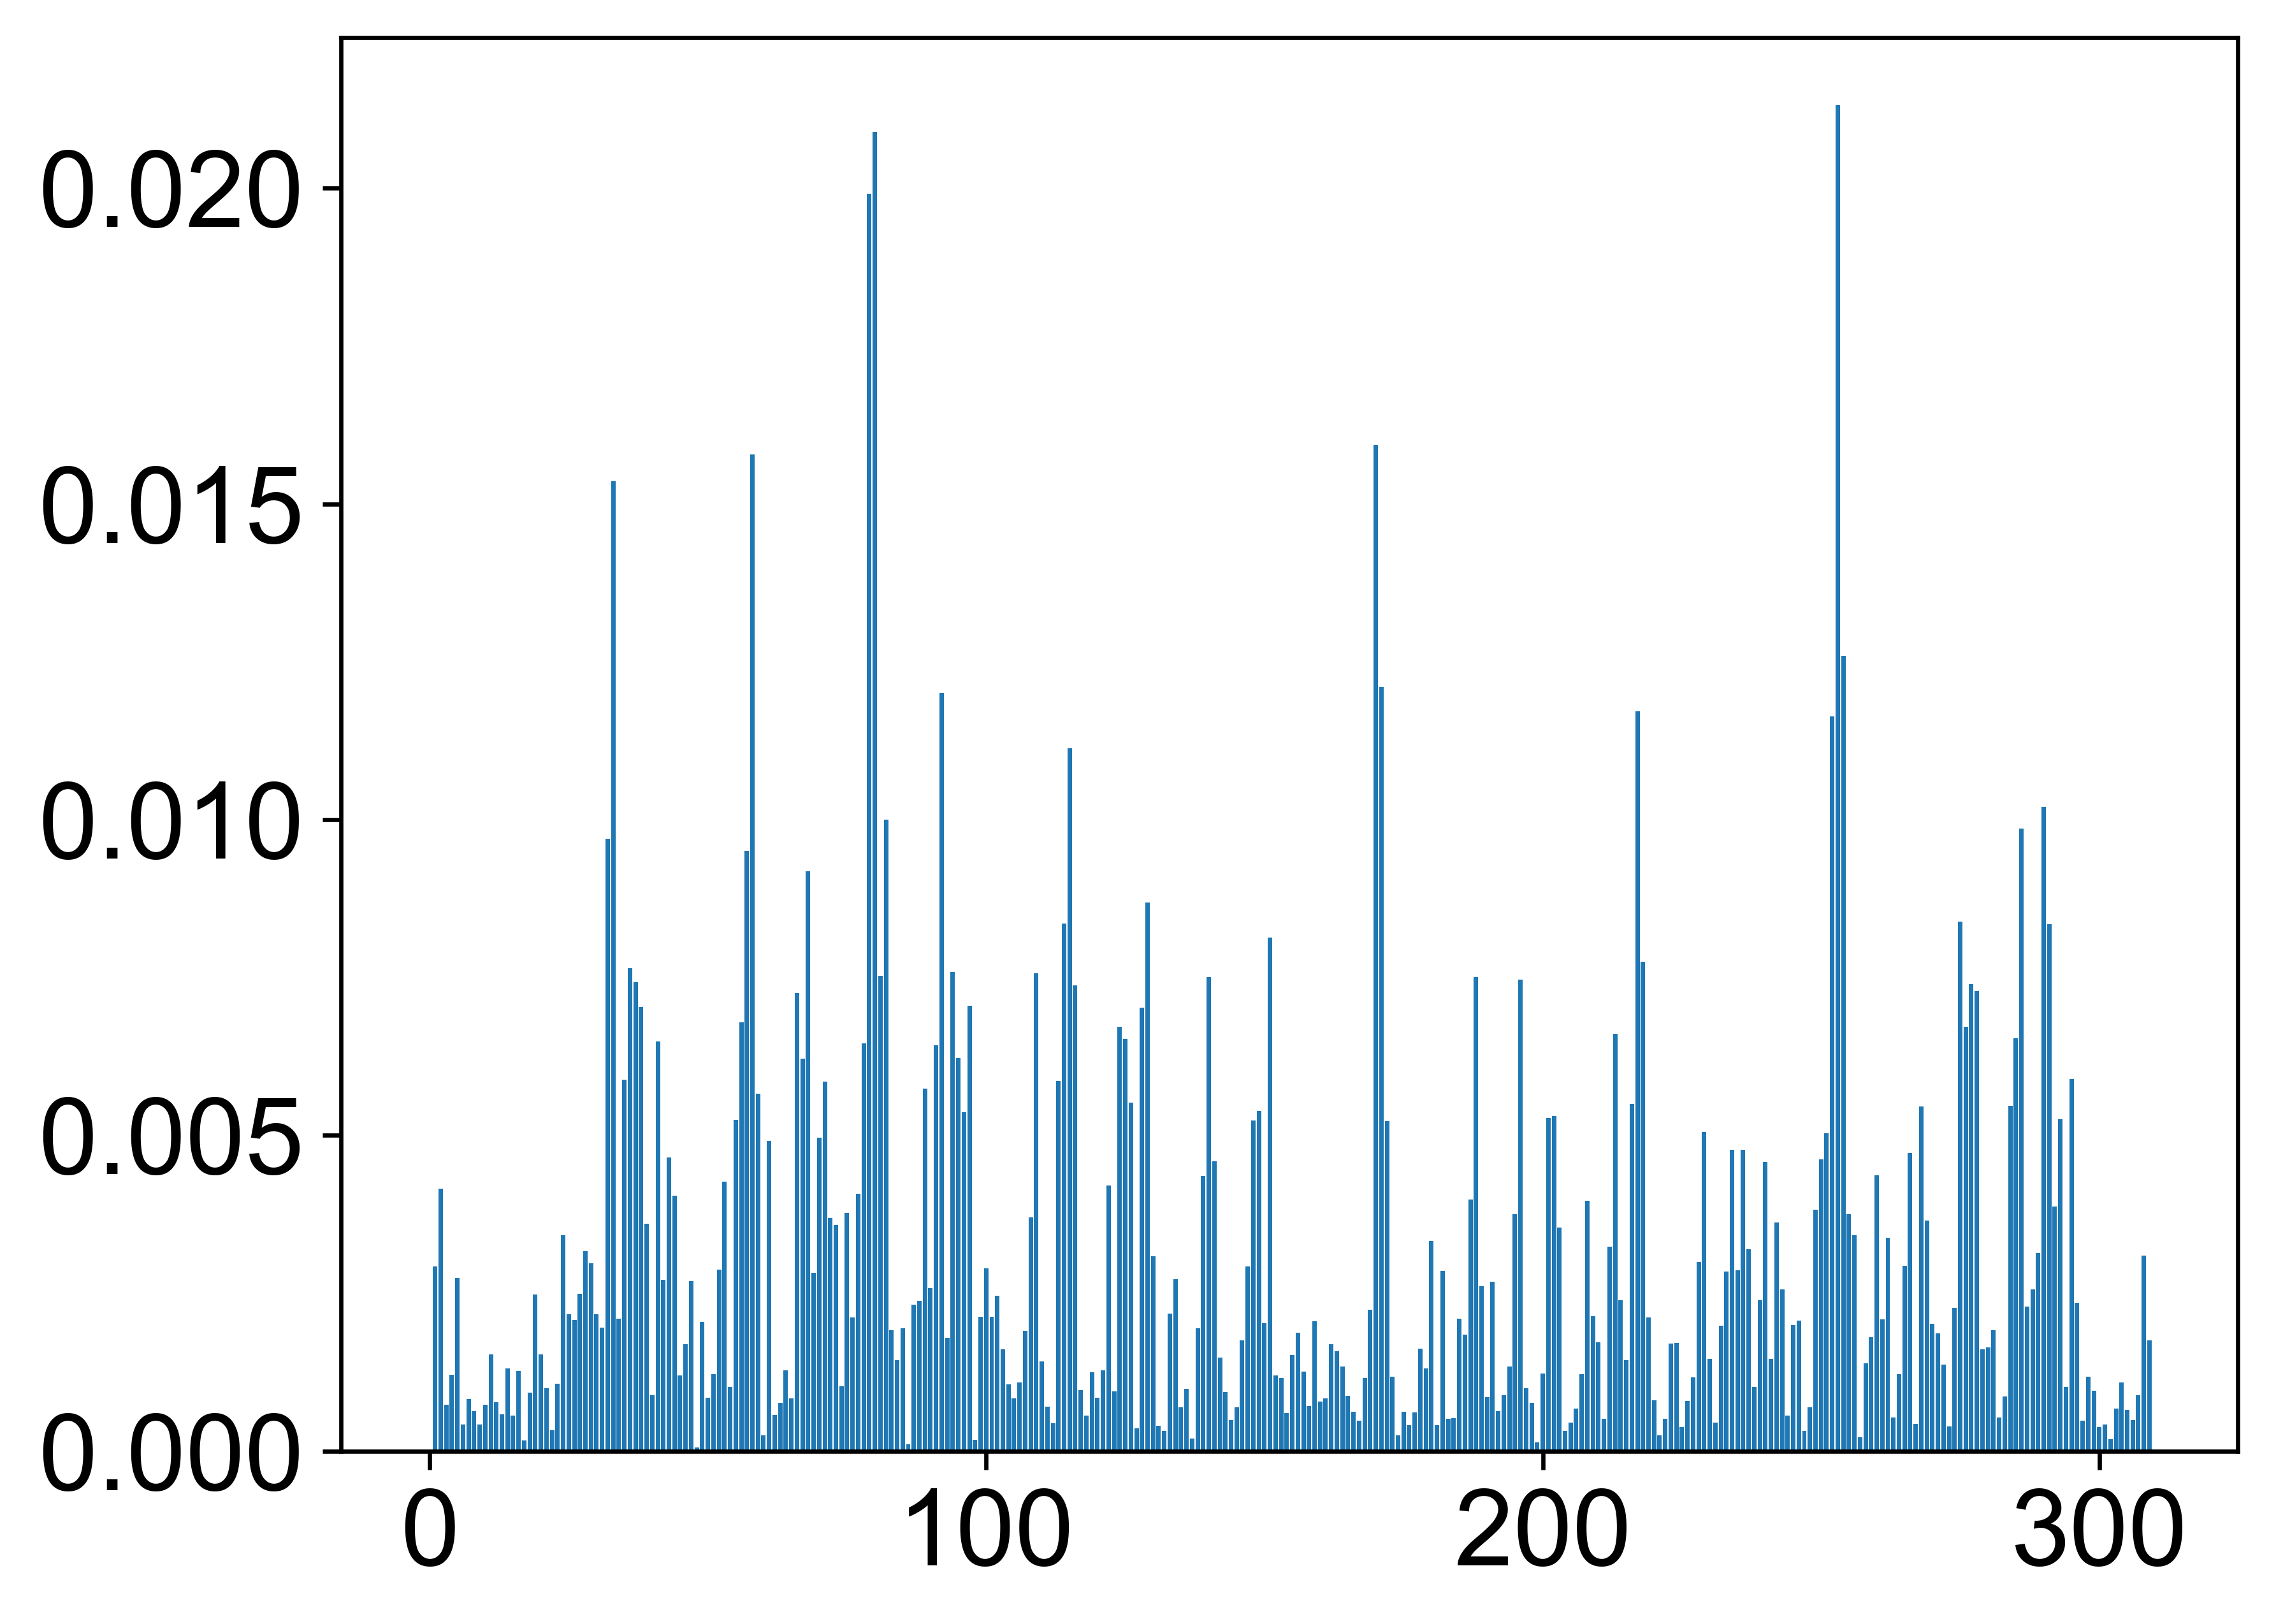

y5
CNN_trainデータの決定係数0.9320978013819562
CNN_testデータの決定係数0.5555118784393365


<Figure size 3840x2880 with 0 Axes>

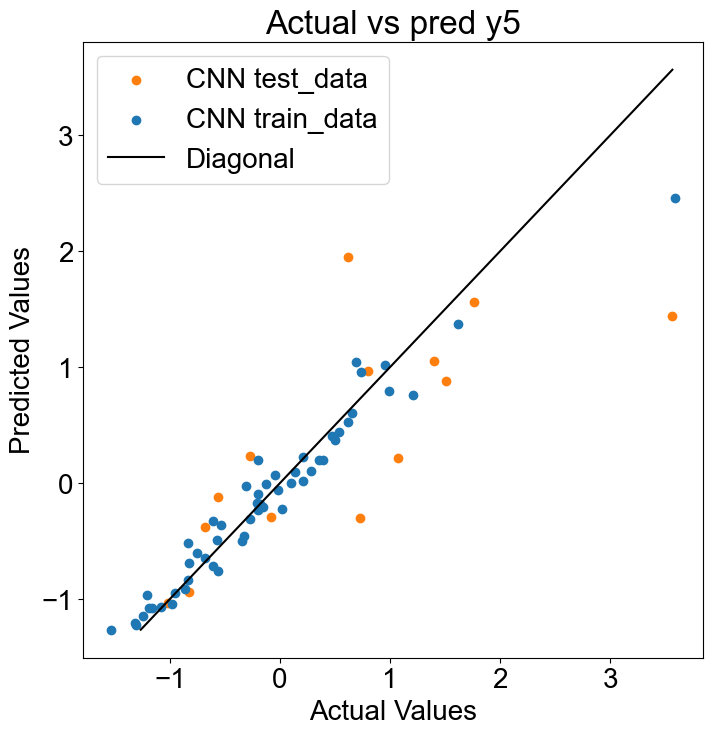

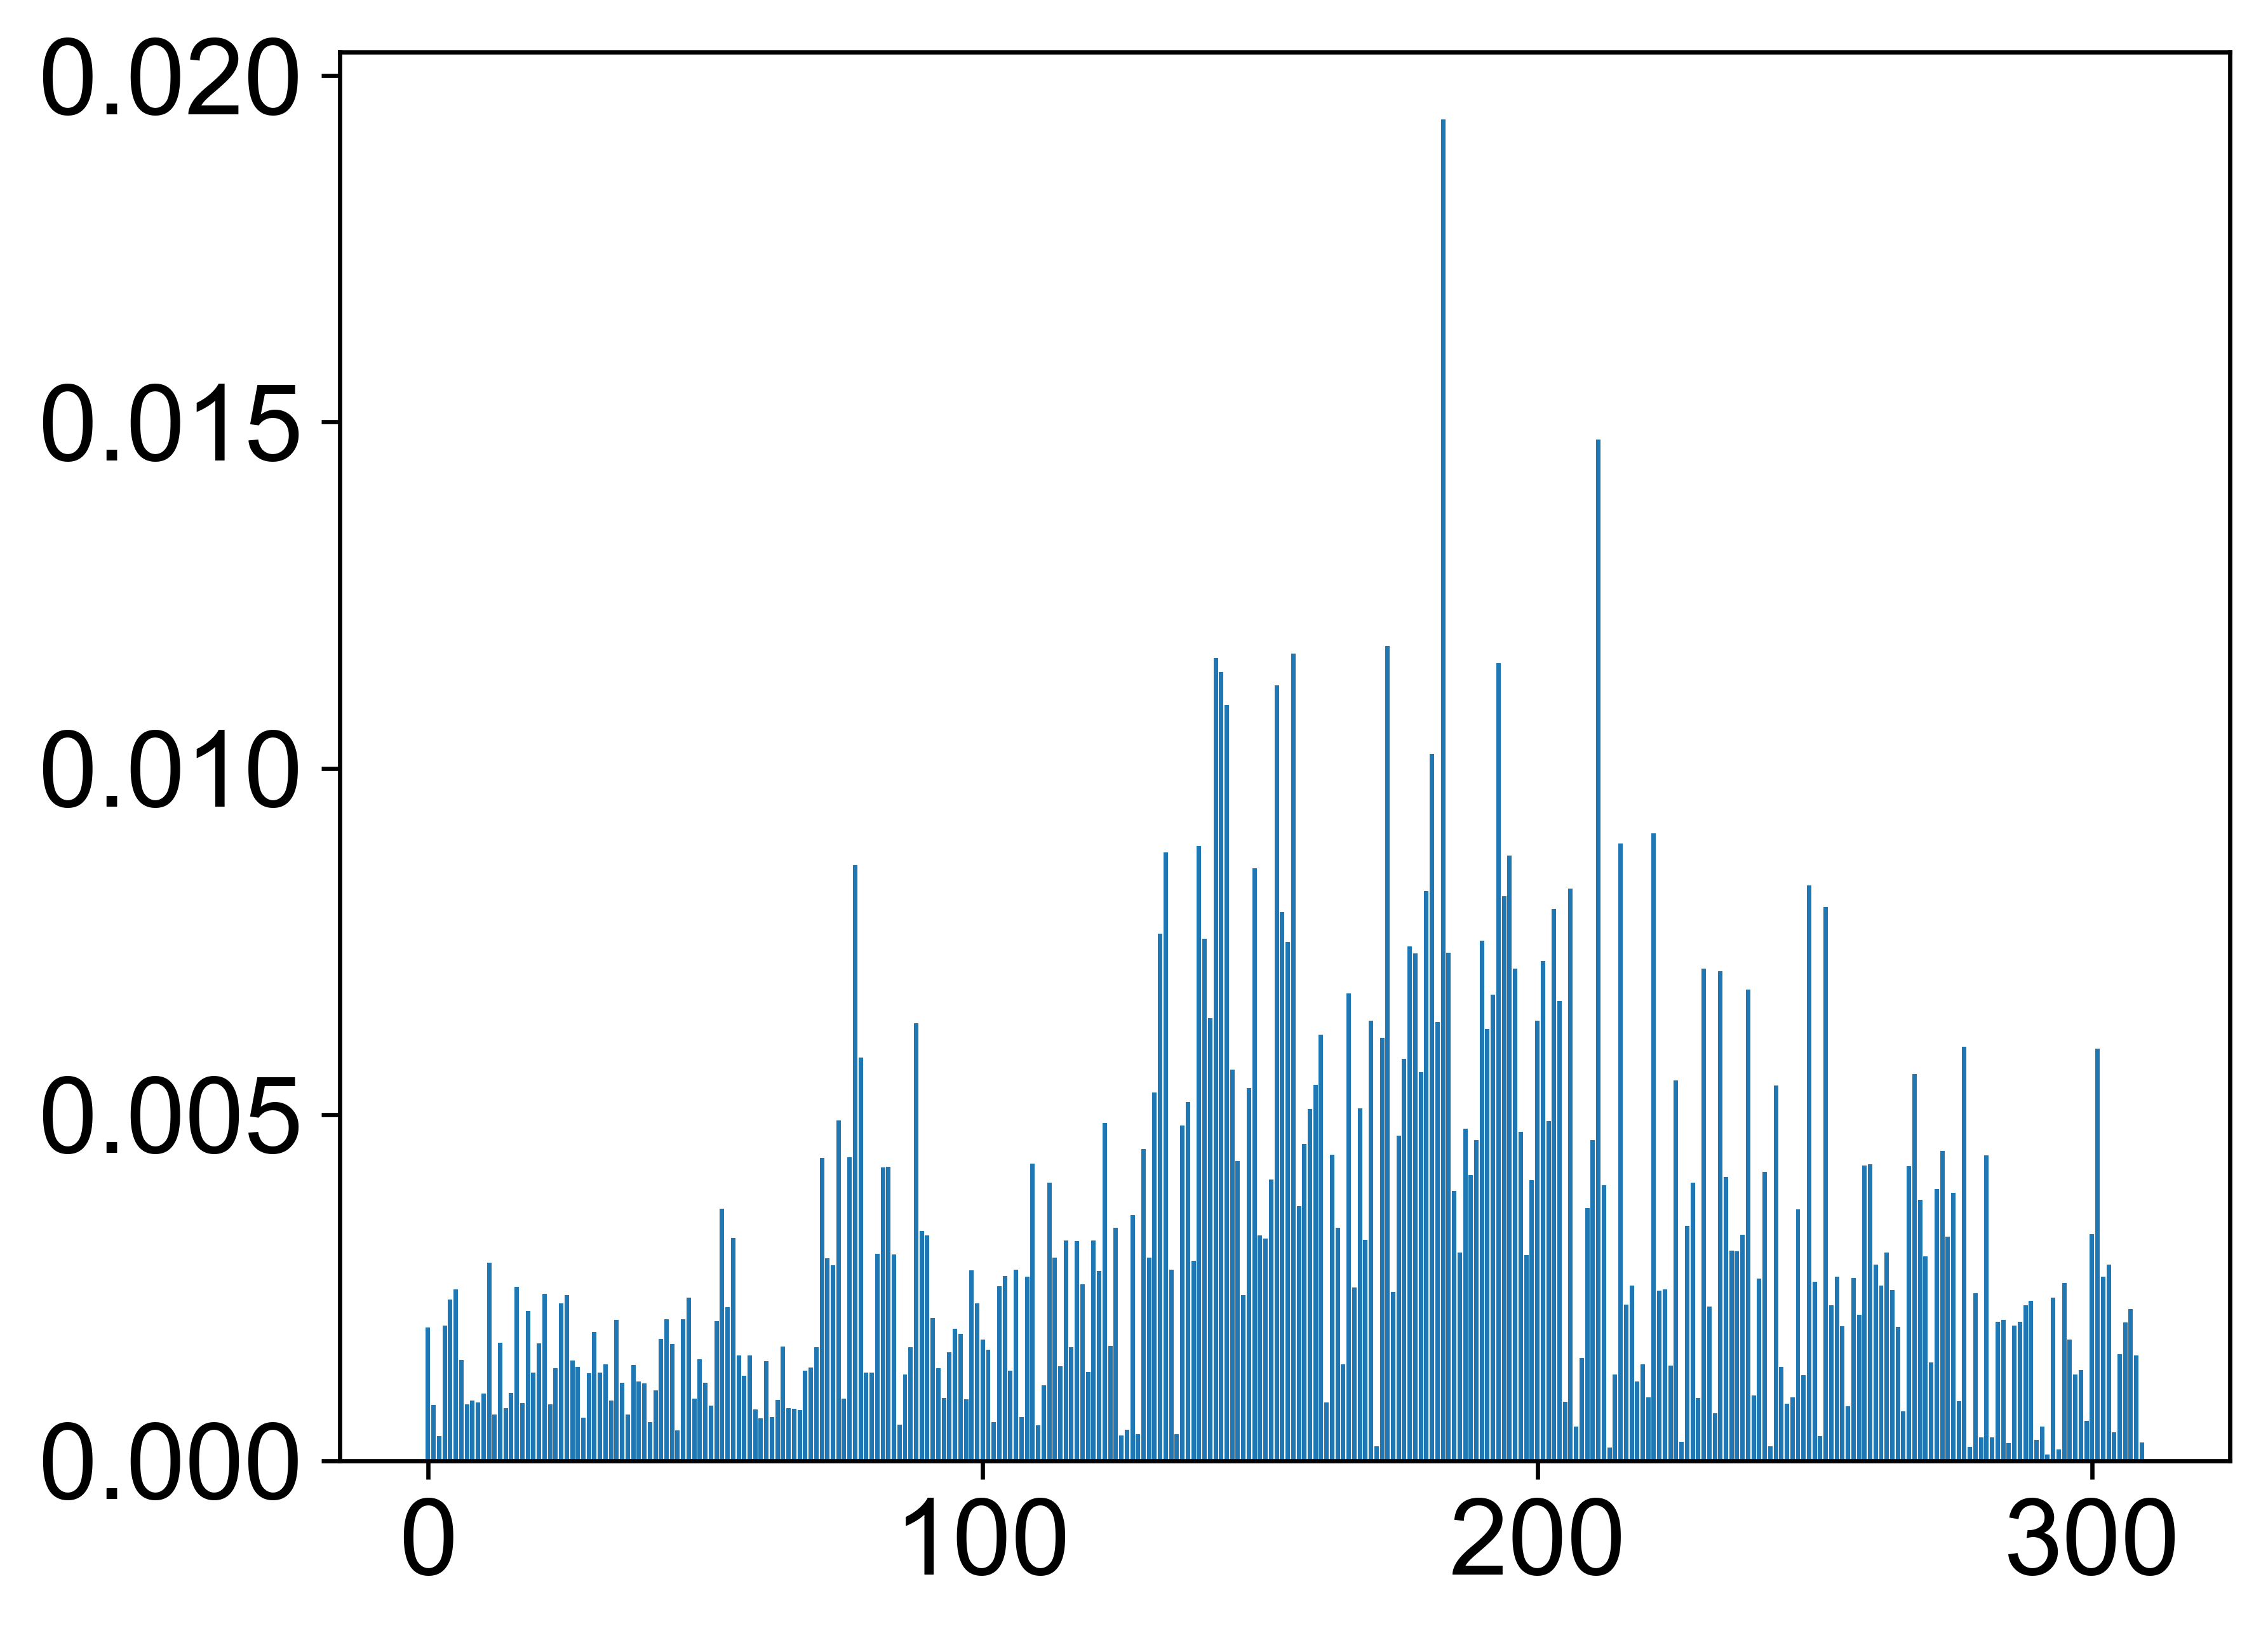

trainデータの決定係数0.9318589624946617
testデータの決定係数0.4461559896585674


<Figure size 3840x2880 with 0 Axes>

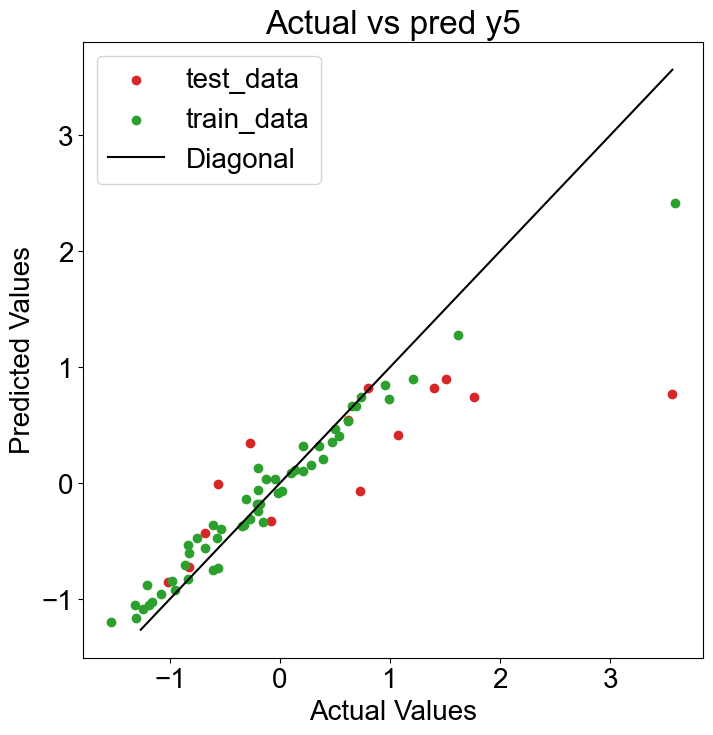

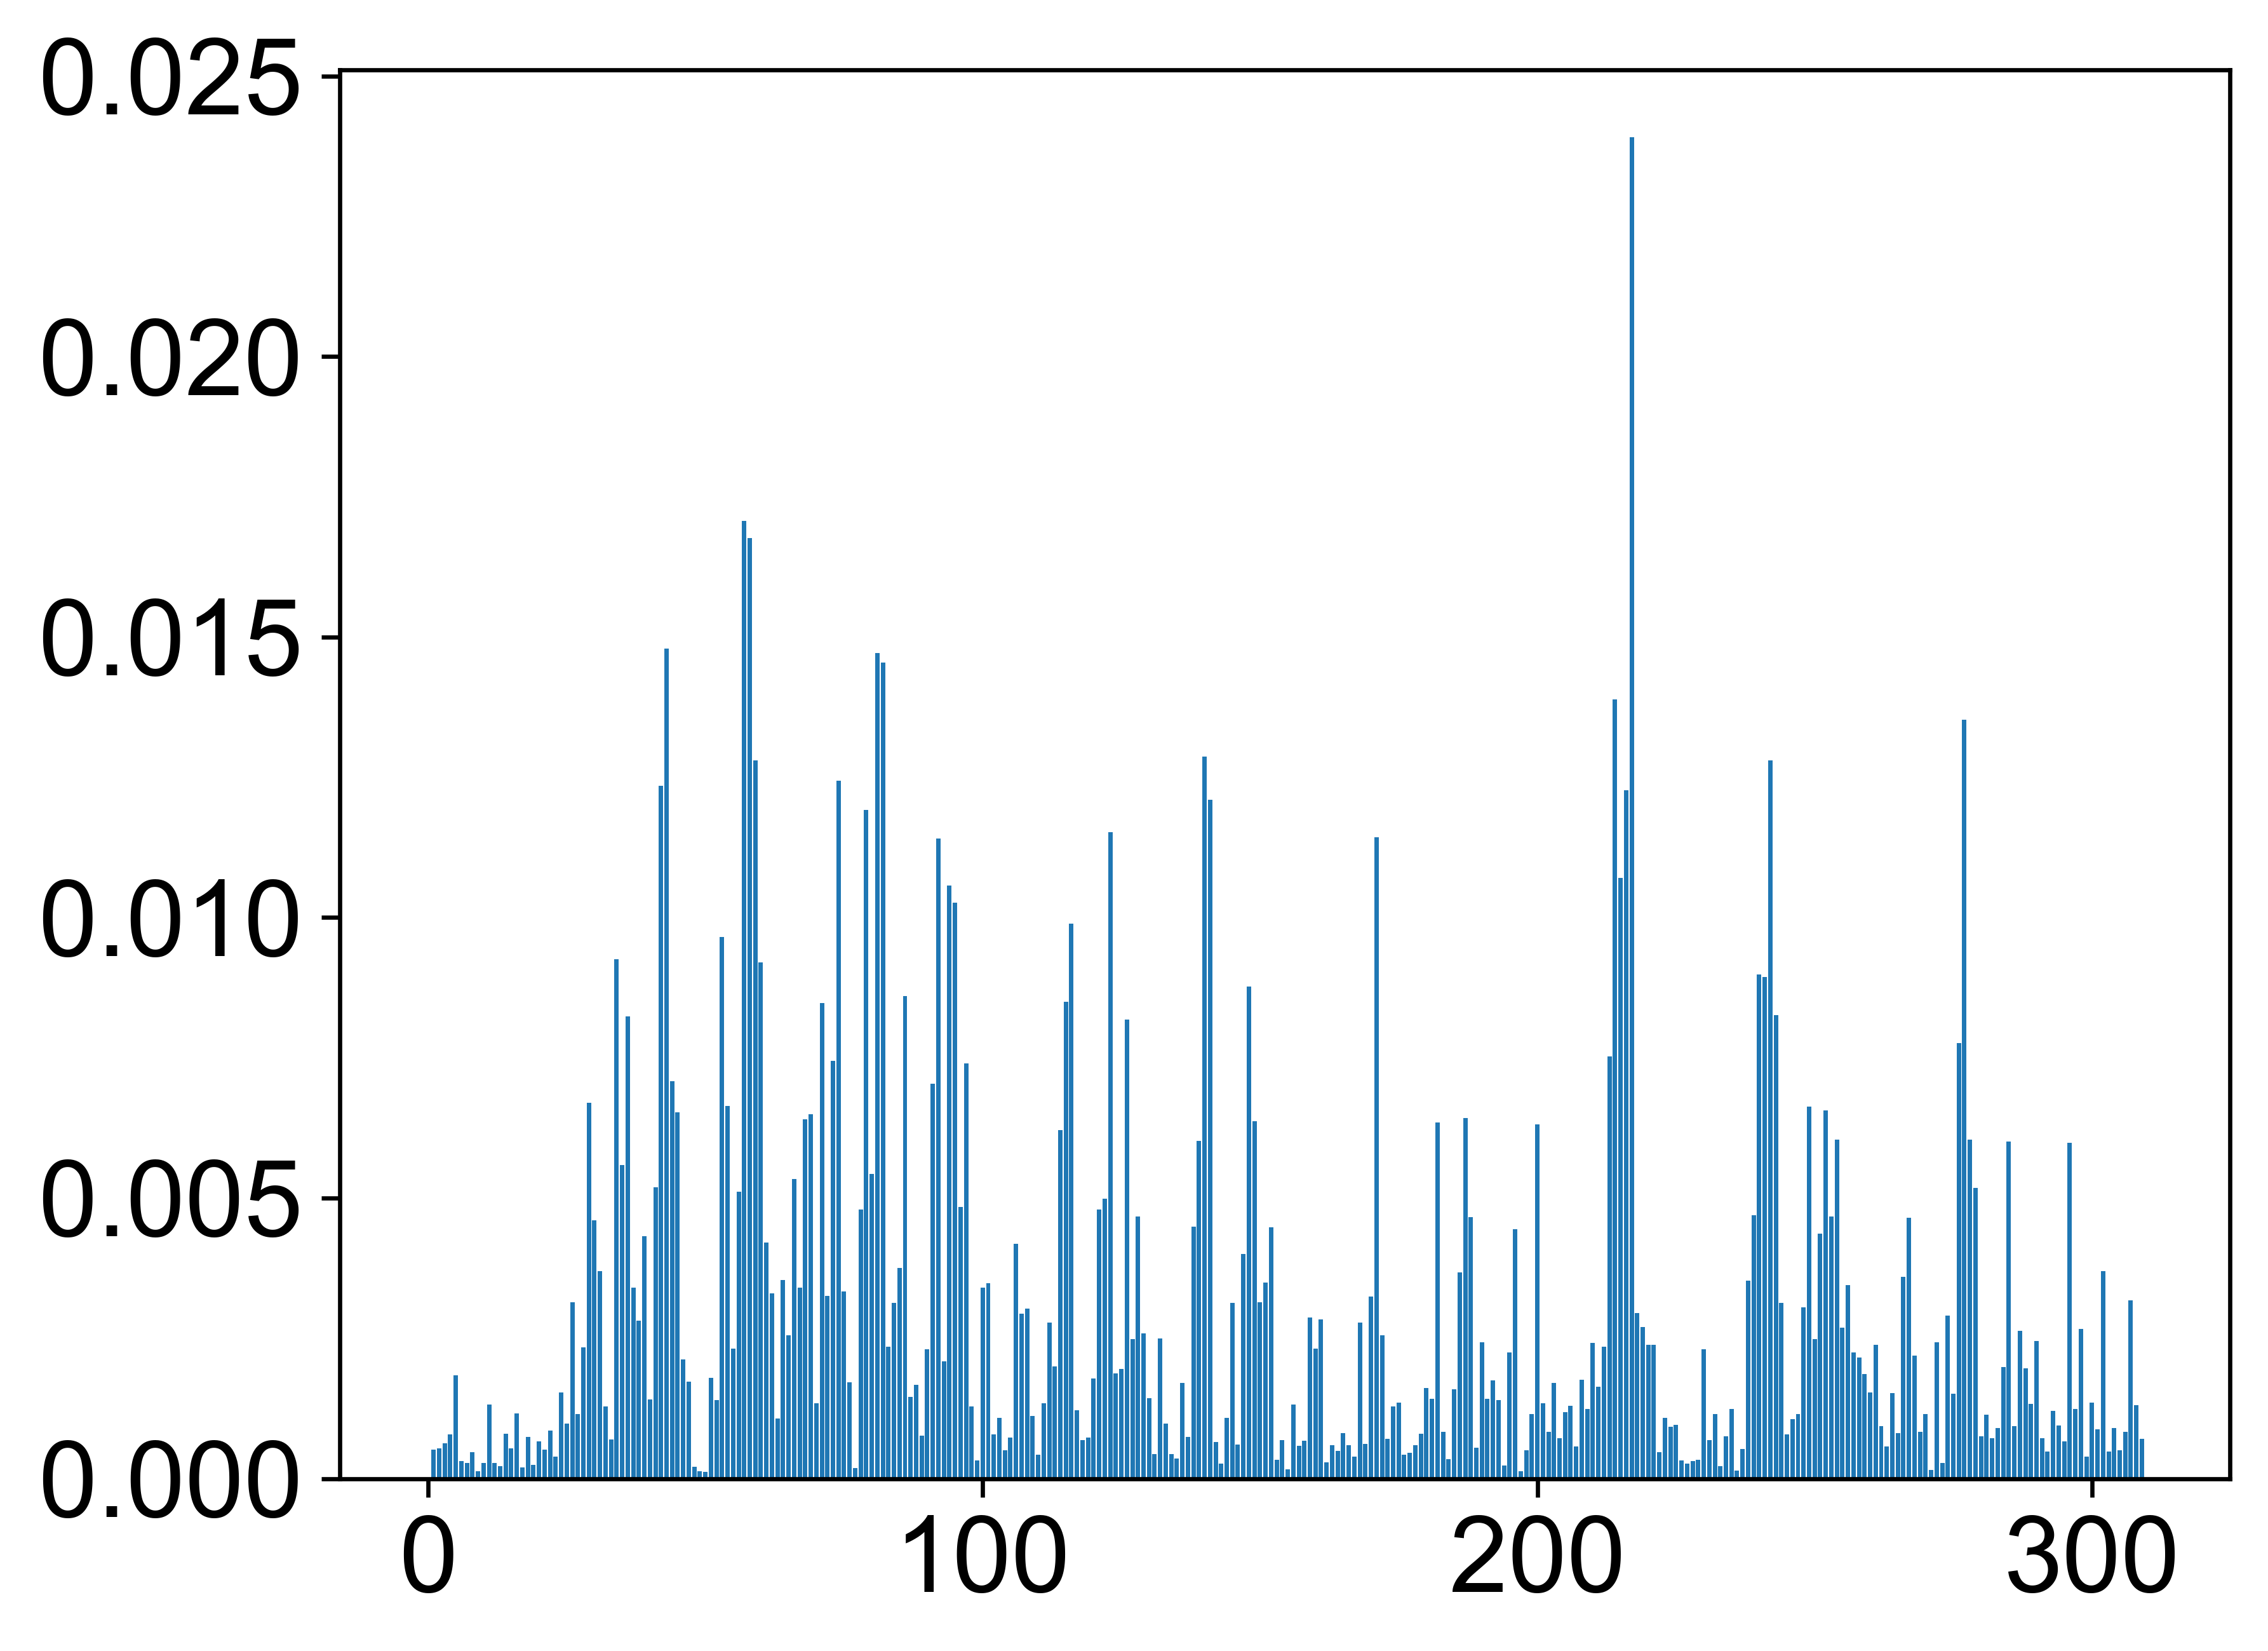

y6
CNN_trainデータの決定係数0.920570959612328
CNN_testデータの決定係数0.5208357579884415


<Figure size 3840x2880 with 0 Axes>

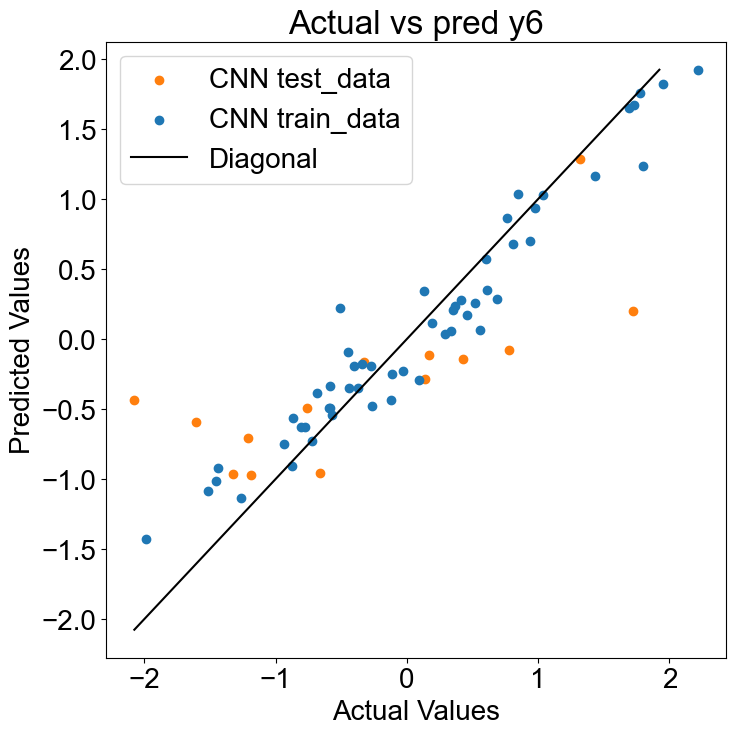

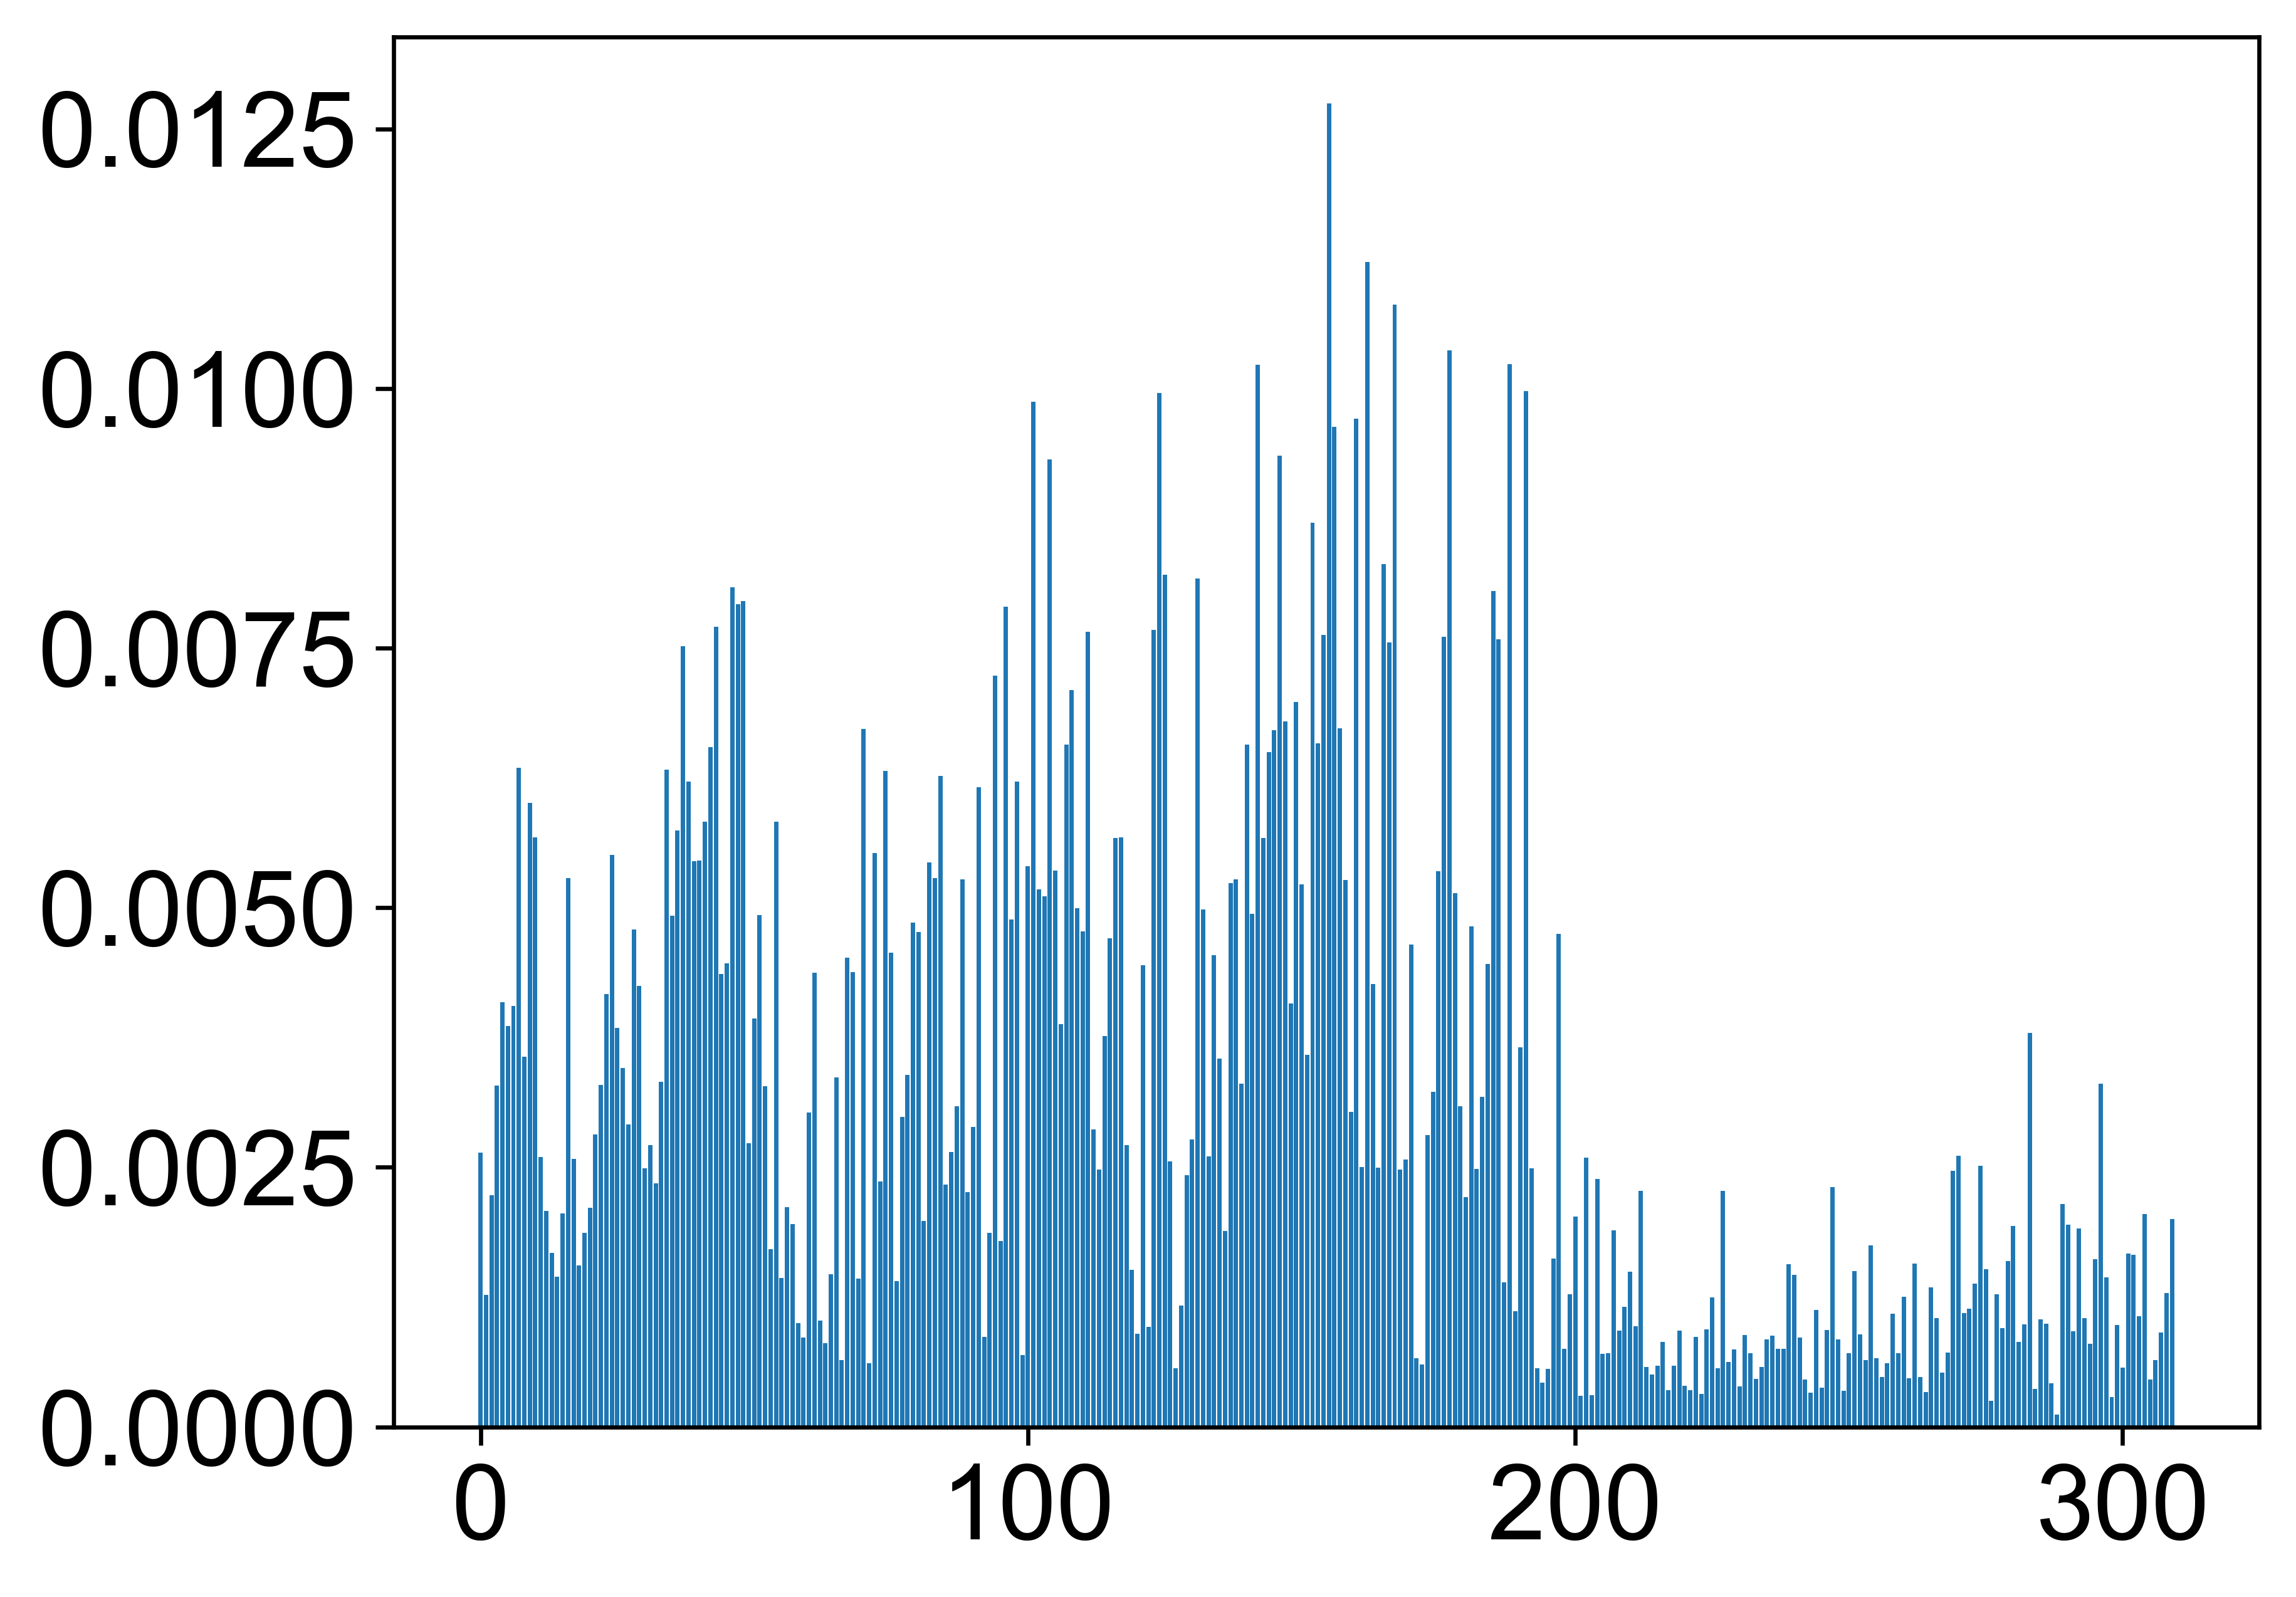

trainデータの決定係数0.9215367856242977
testデータの決定係数0.5792791616130728


<Figure size 3840x2880 with 0 Axes>

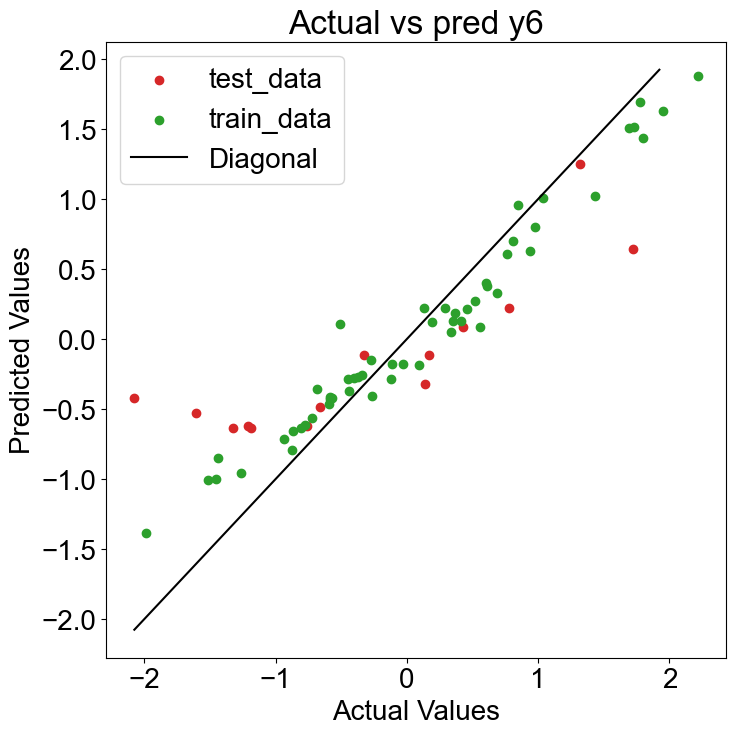

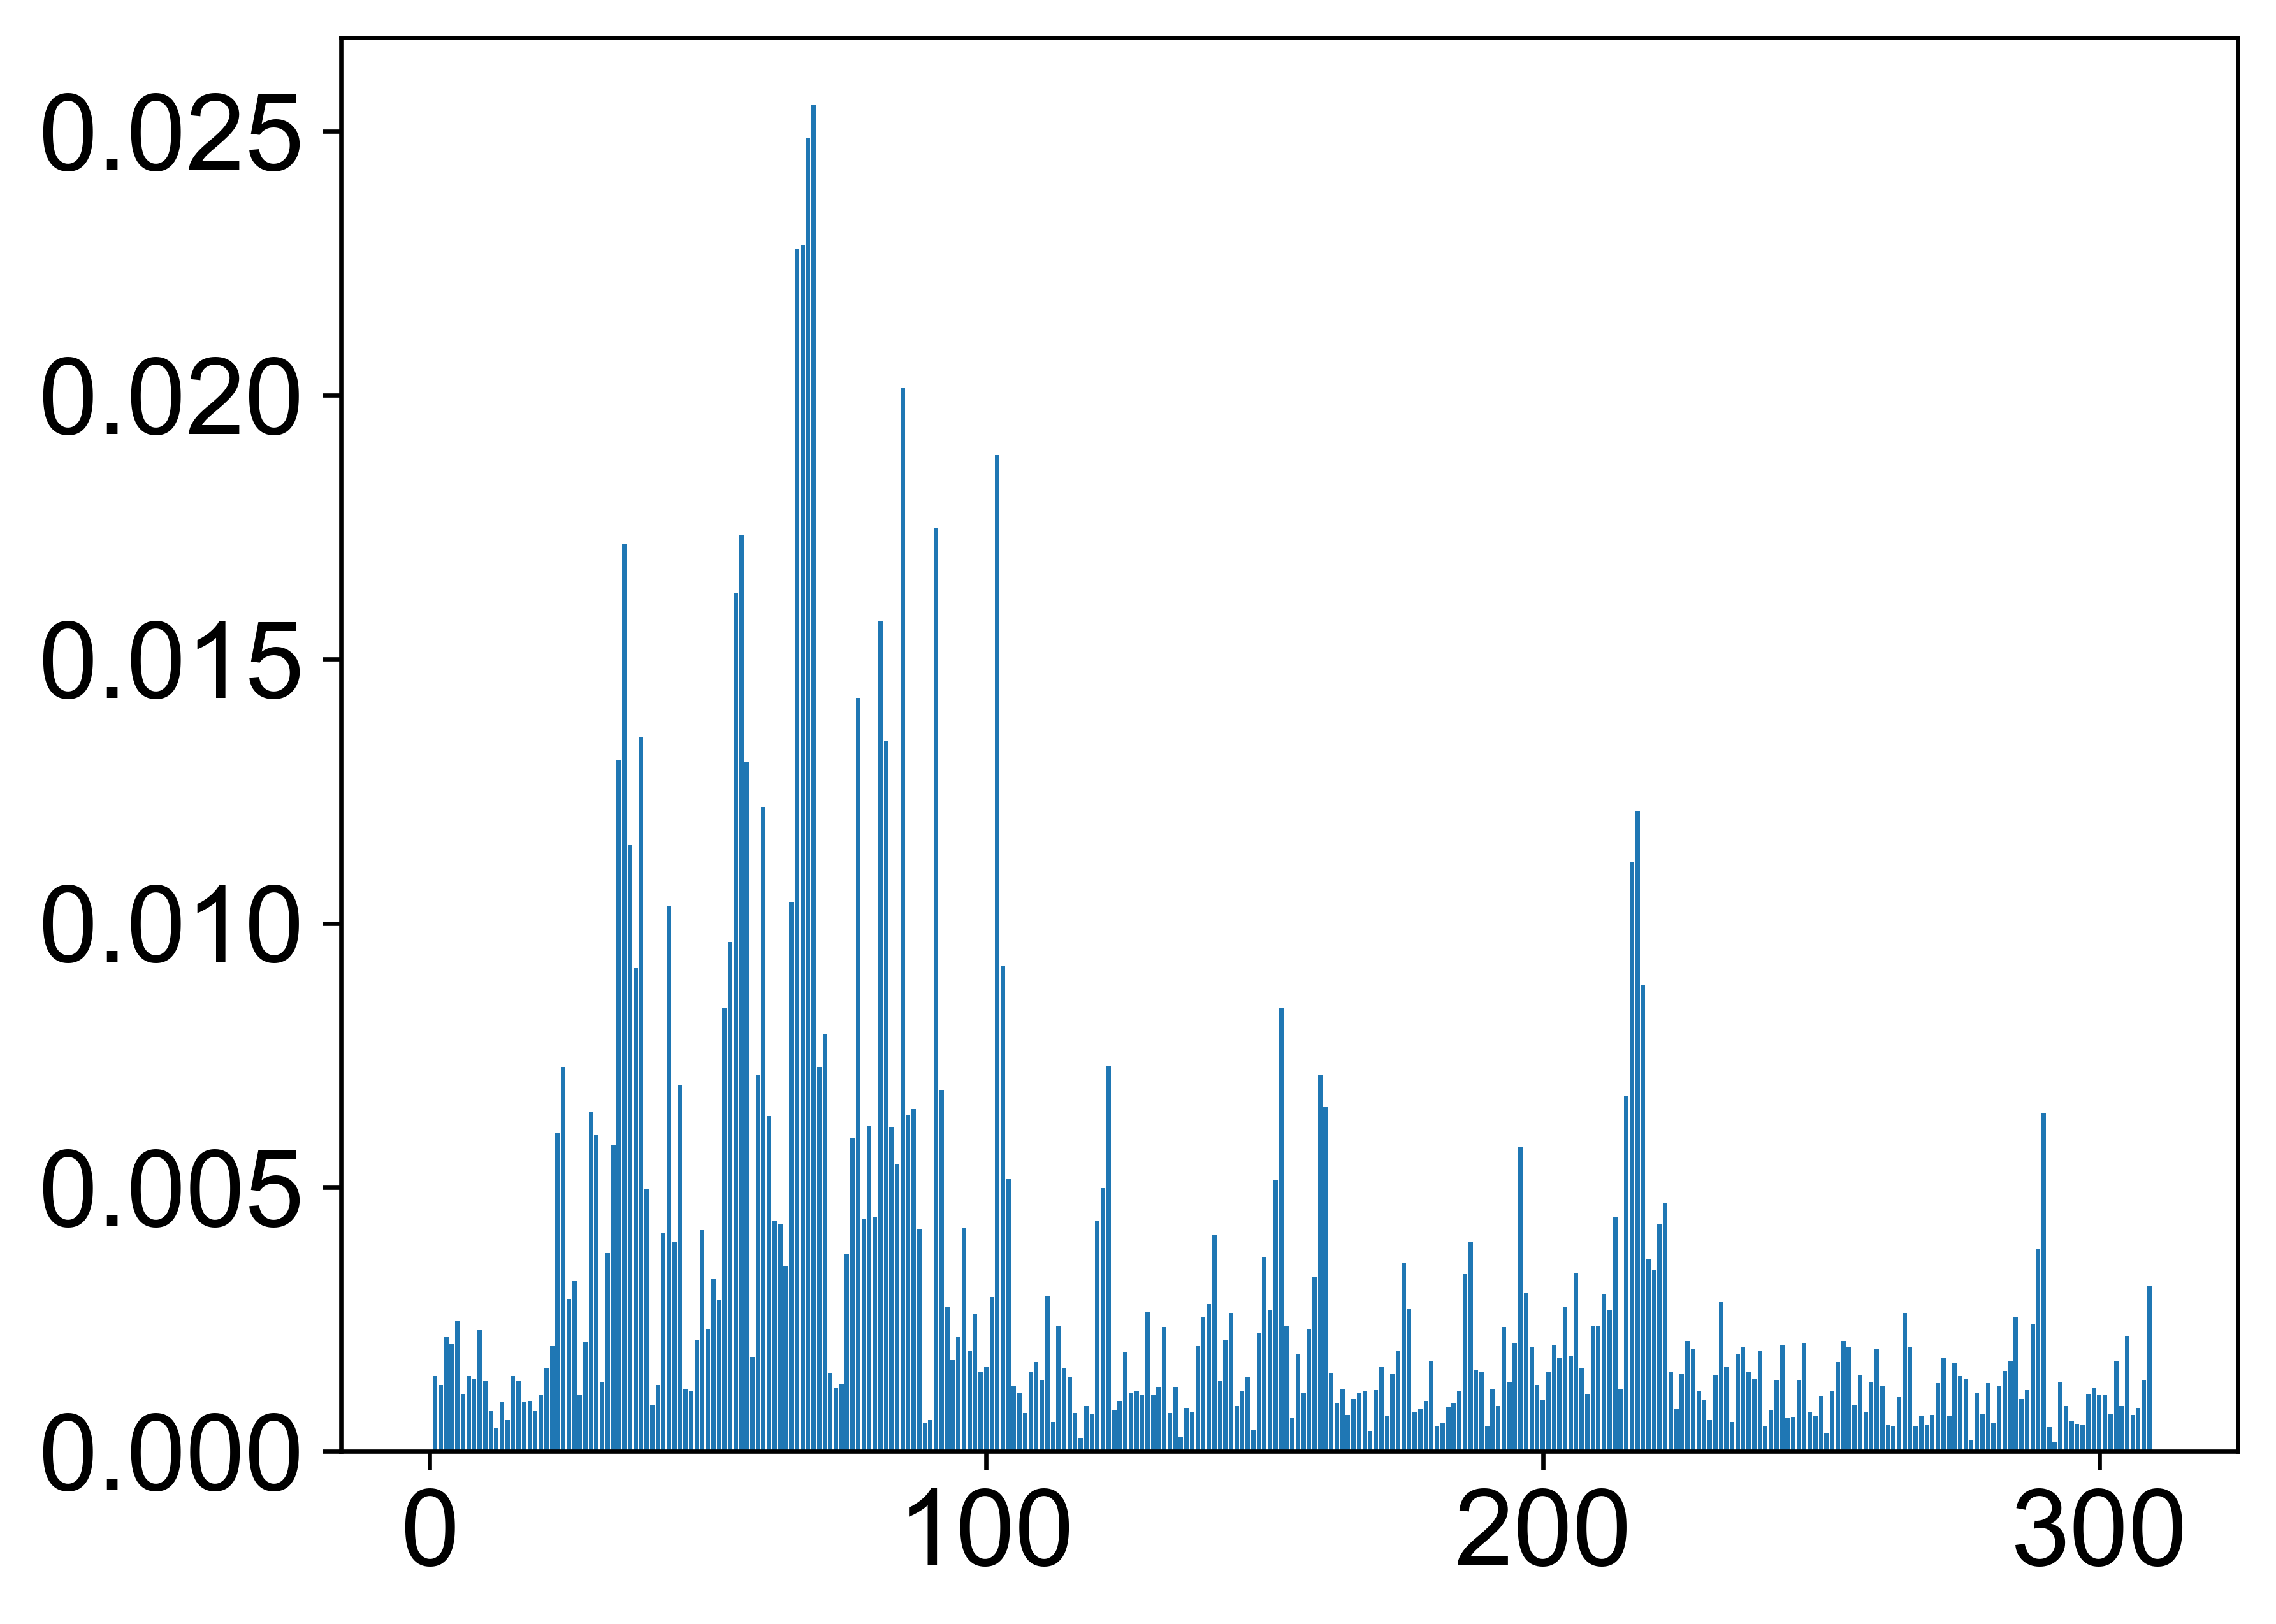

y7
CNN_trainデータの決定係数0.8935638746576942
CNN_testデータの決定係数0.46954071796007757


<Figure size 3840x2880 with 0 Axes>

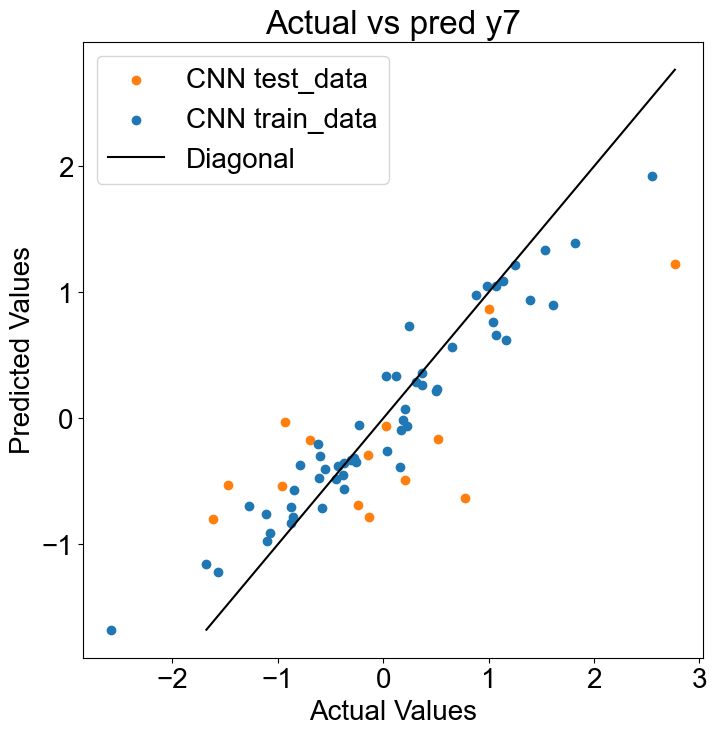

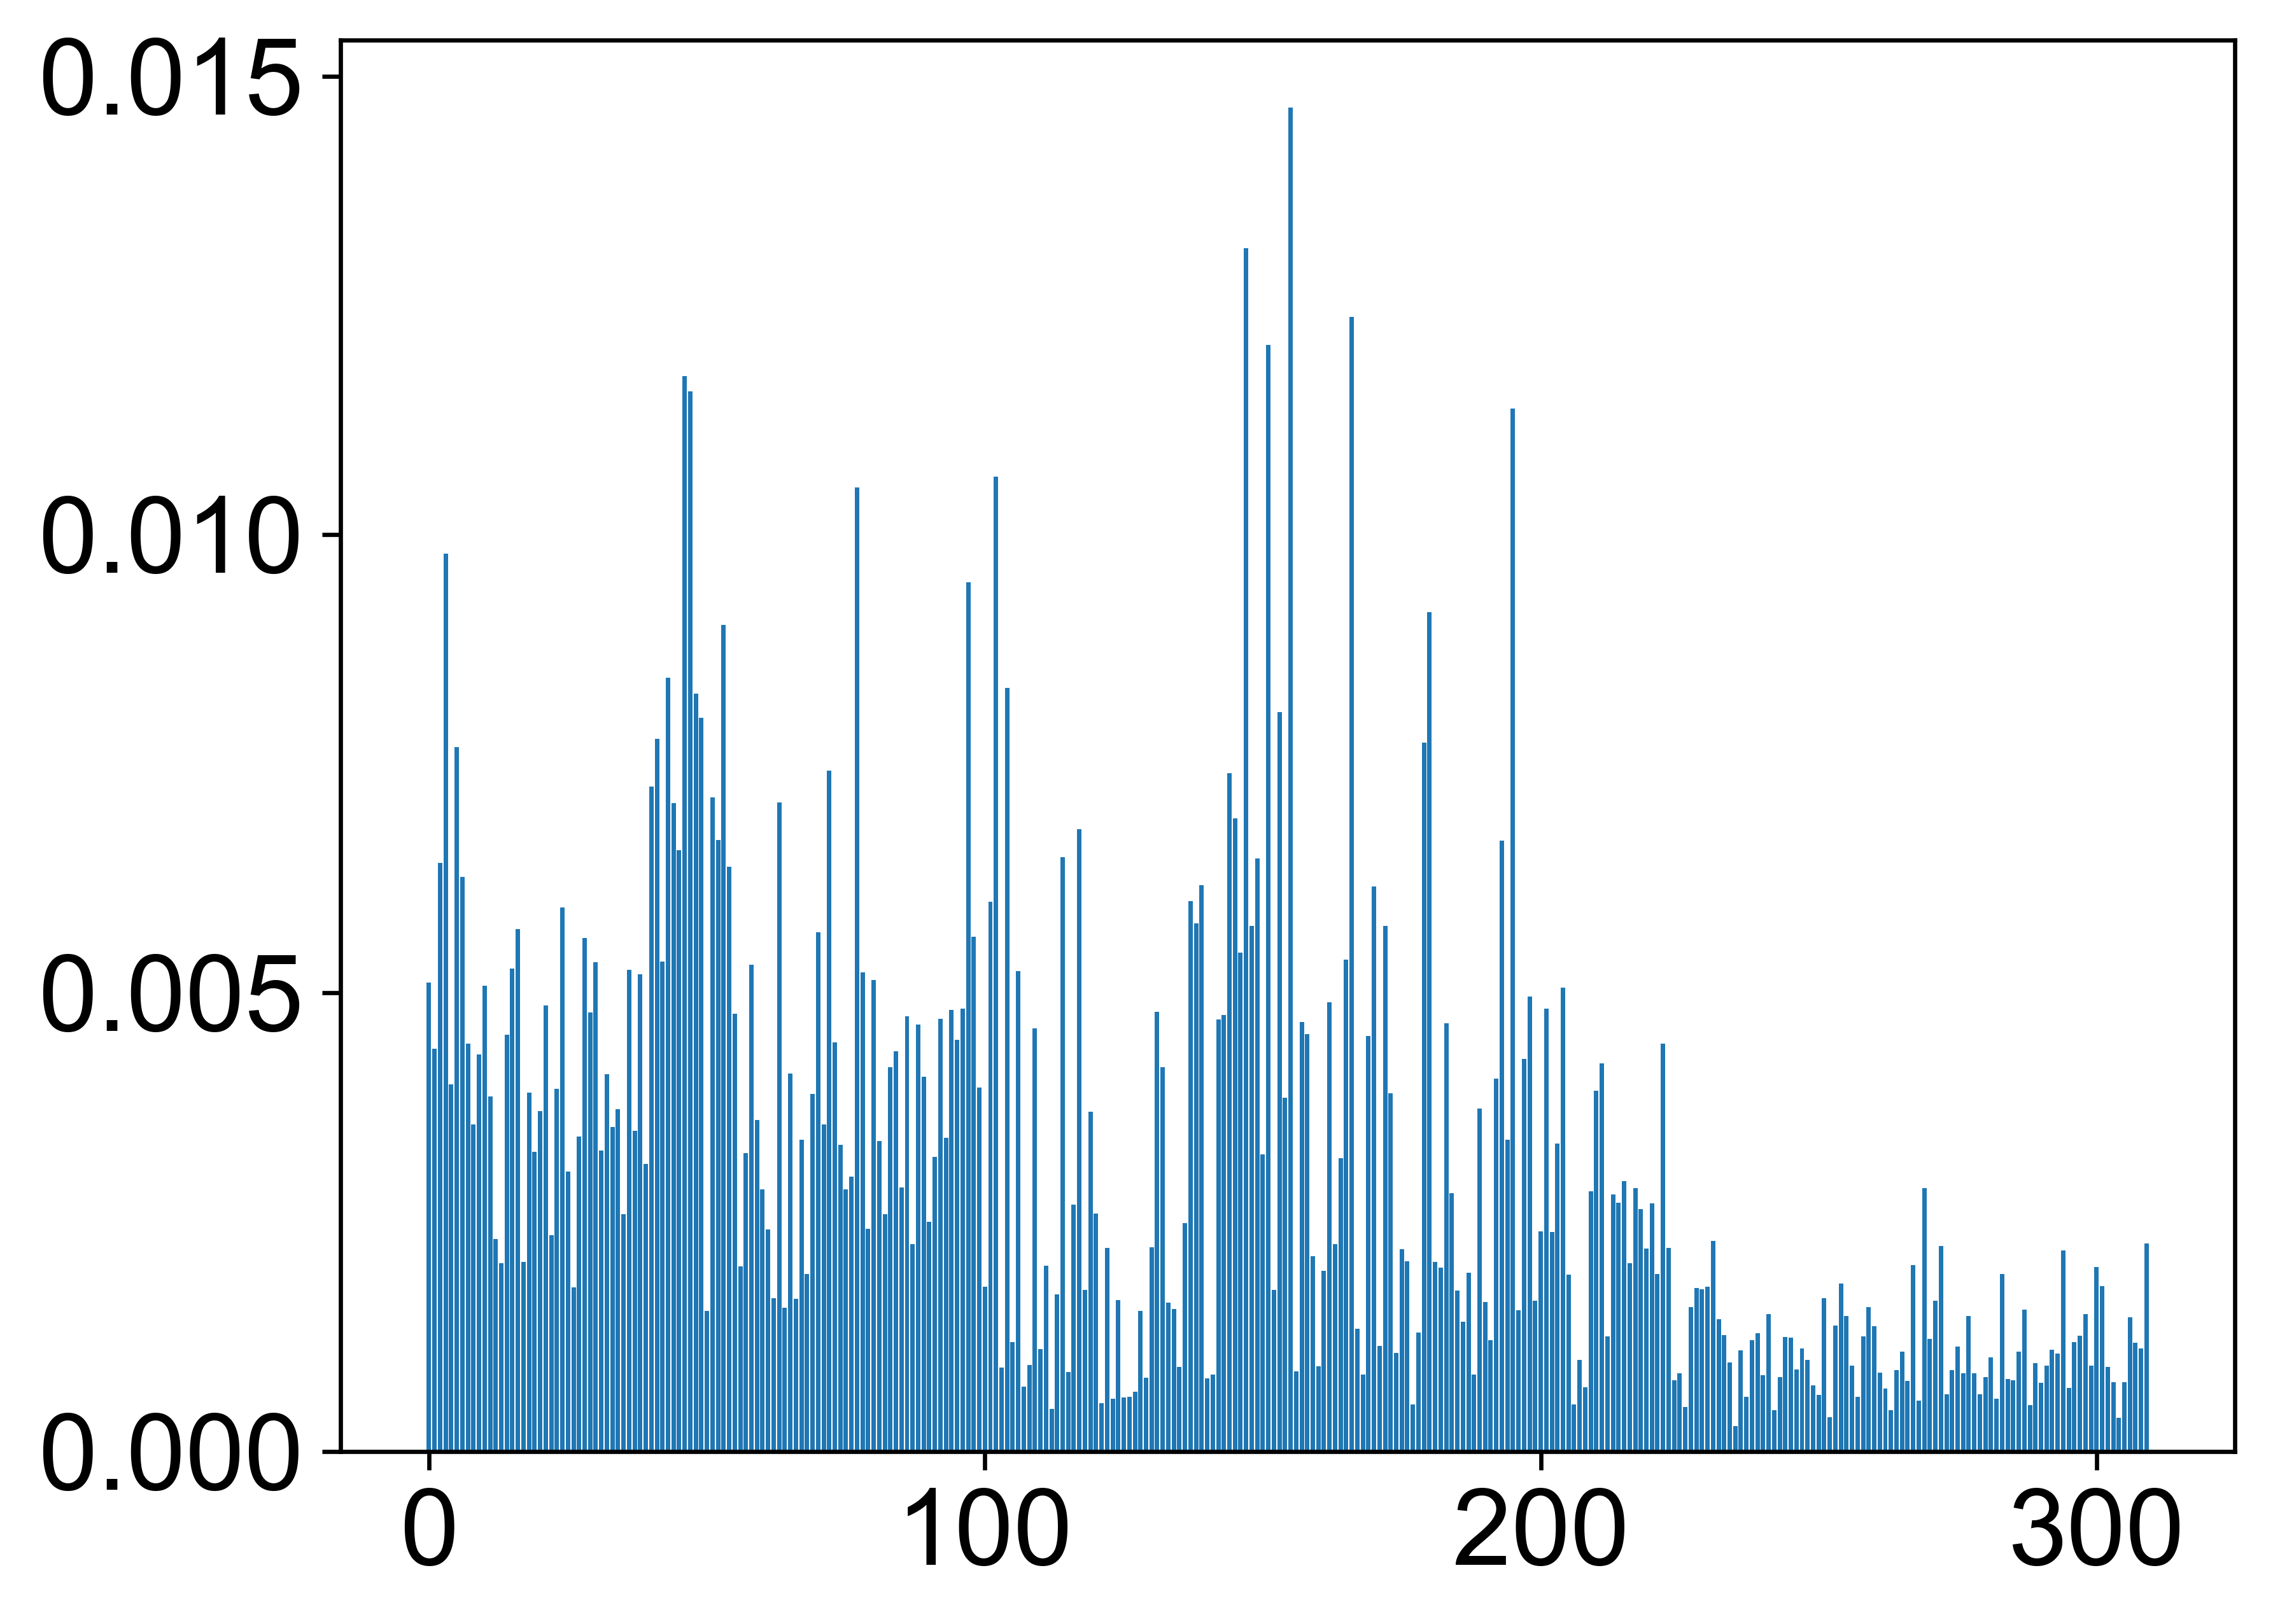

trainデータの決定係数0.9018639035002407
testデータの決定係数0.548320845937375


<Figure size 3840x2880 with 0 Axes>

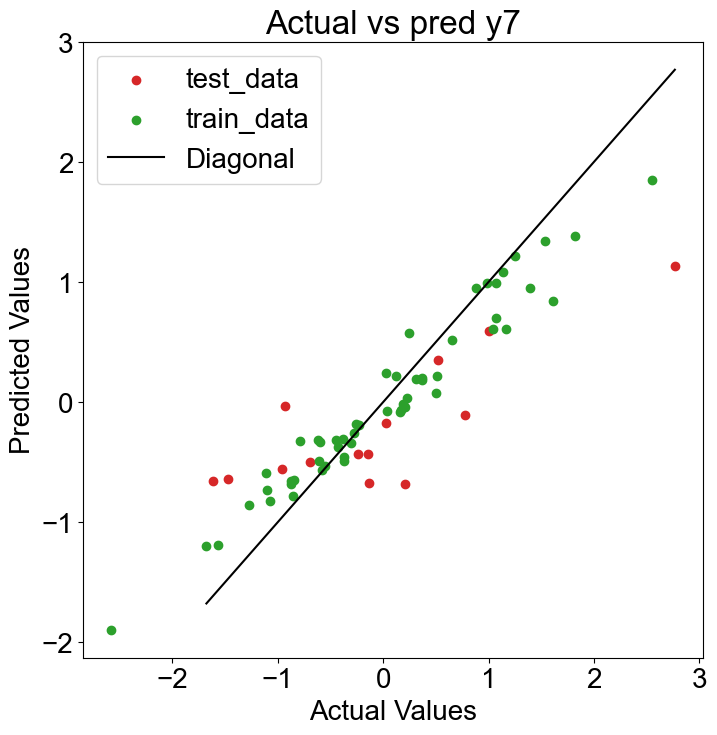

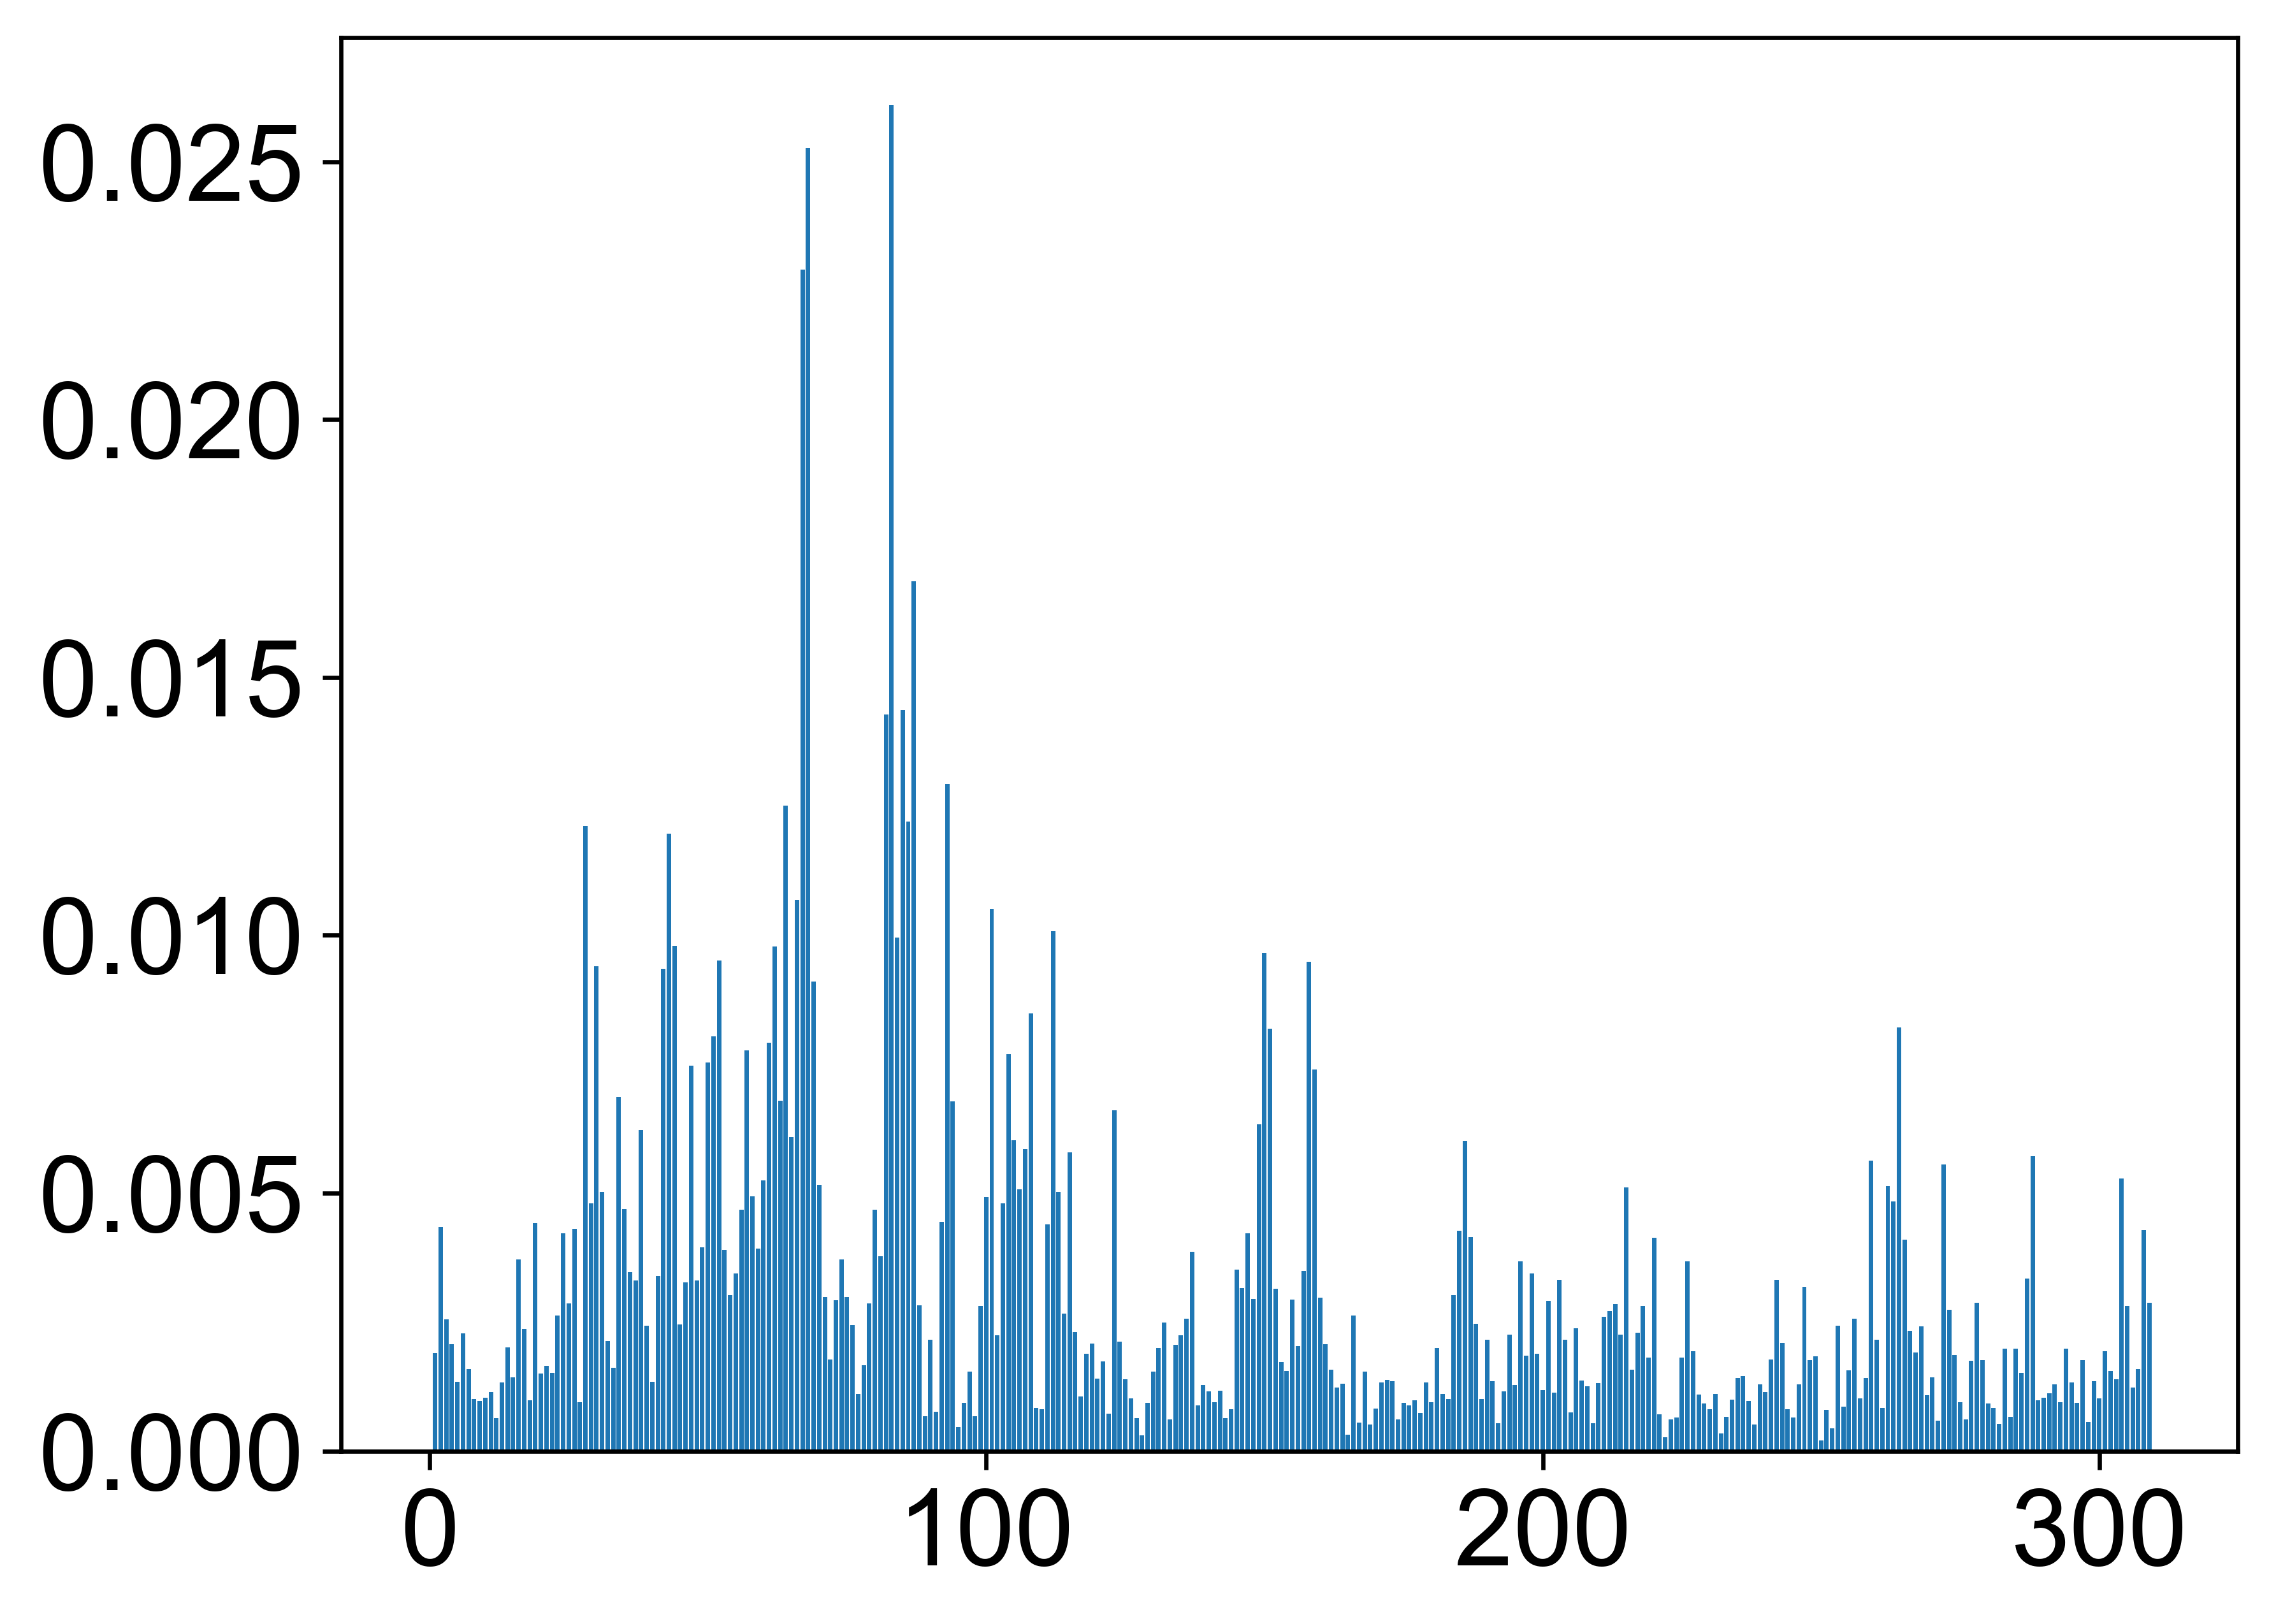

y8
CNN_trainデータの決定係数0.8410995967480484
CNN_testデータの決定係数-0.21040622395345276


<Figure size 3840x2880 with 0 Axes>

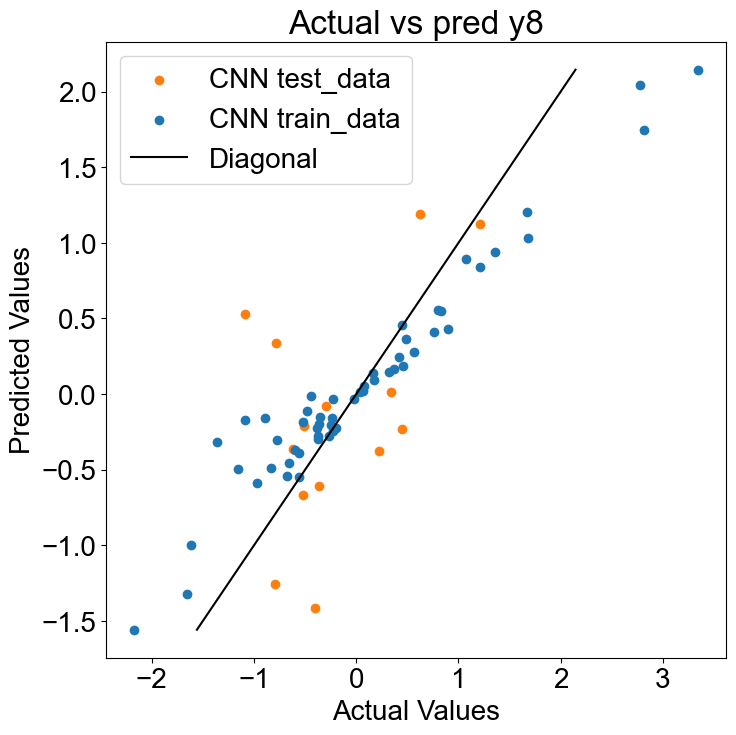

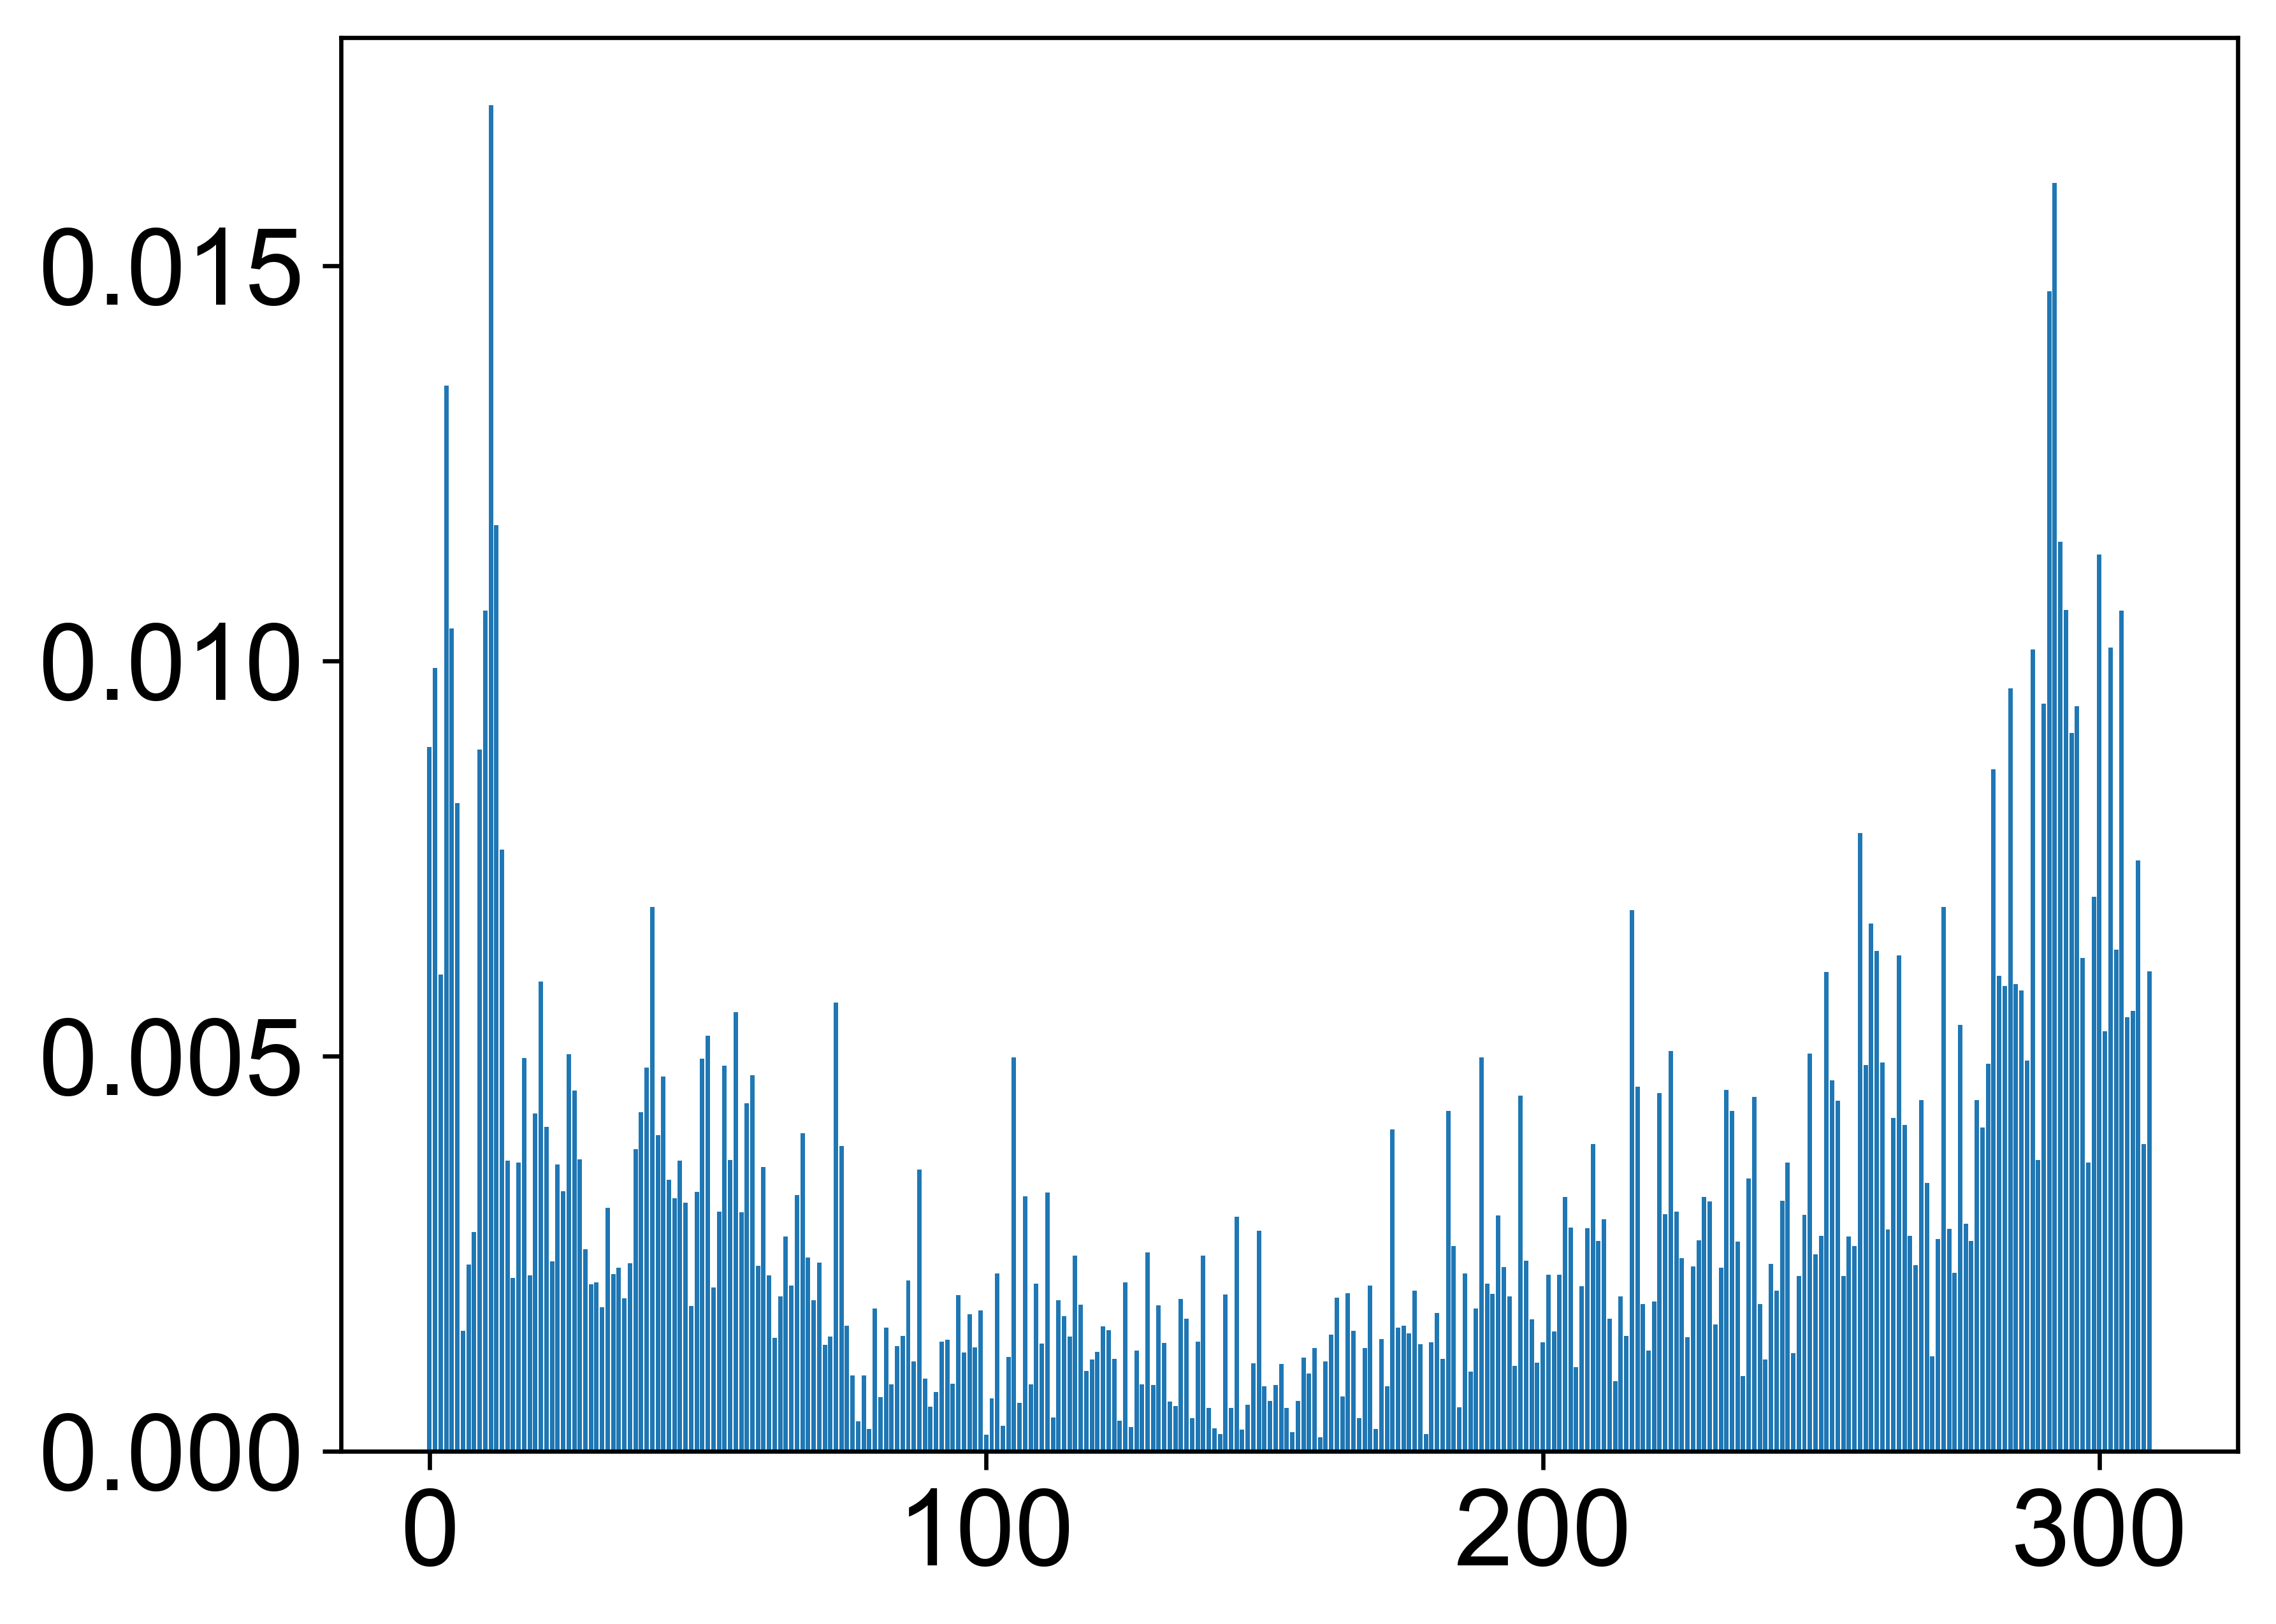

trainデータの決定係数0.8399709315080284
testデータの決定係数-0.39663326233211604


<Figure size 3840x2880 with 0 Axes>

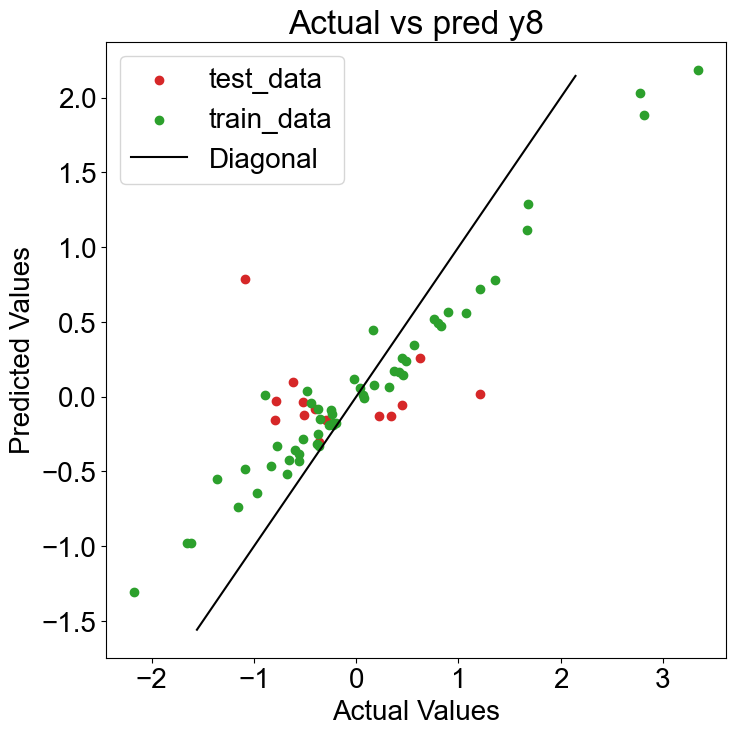

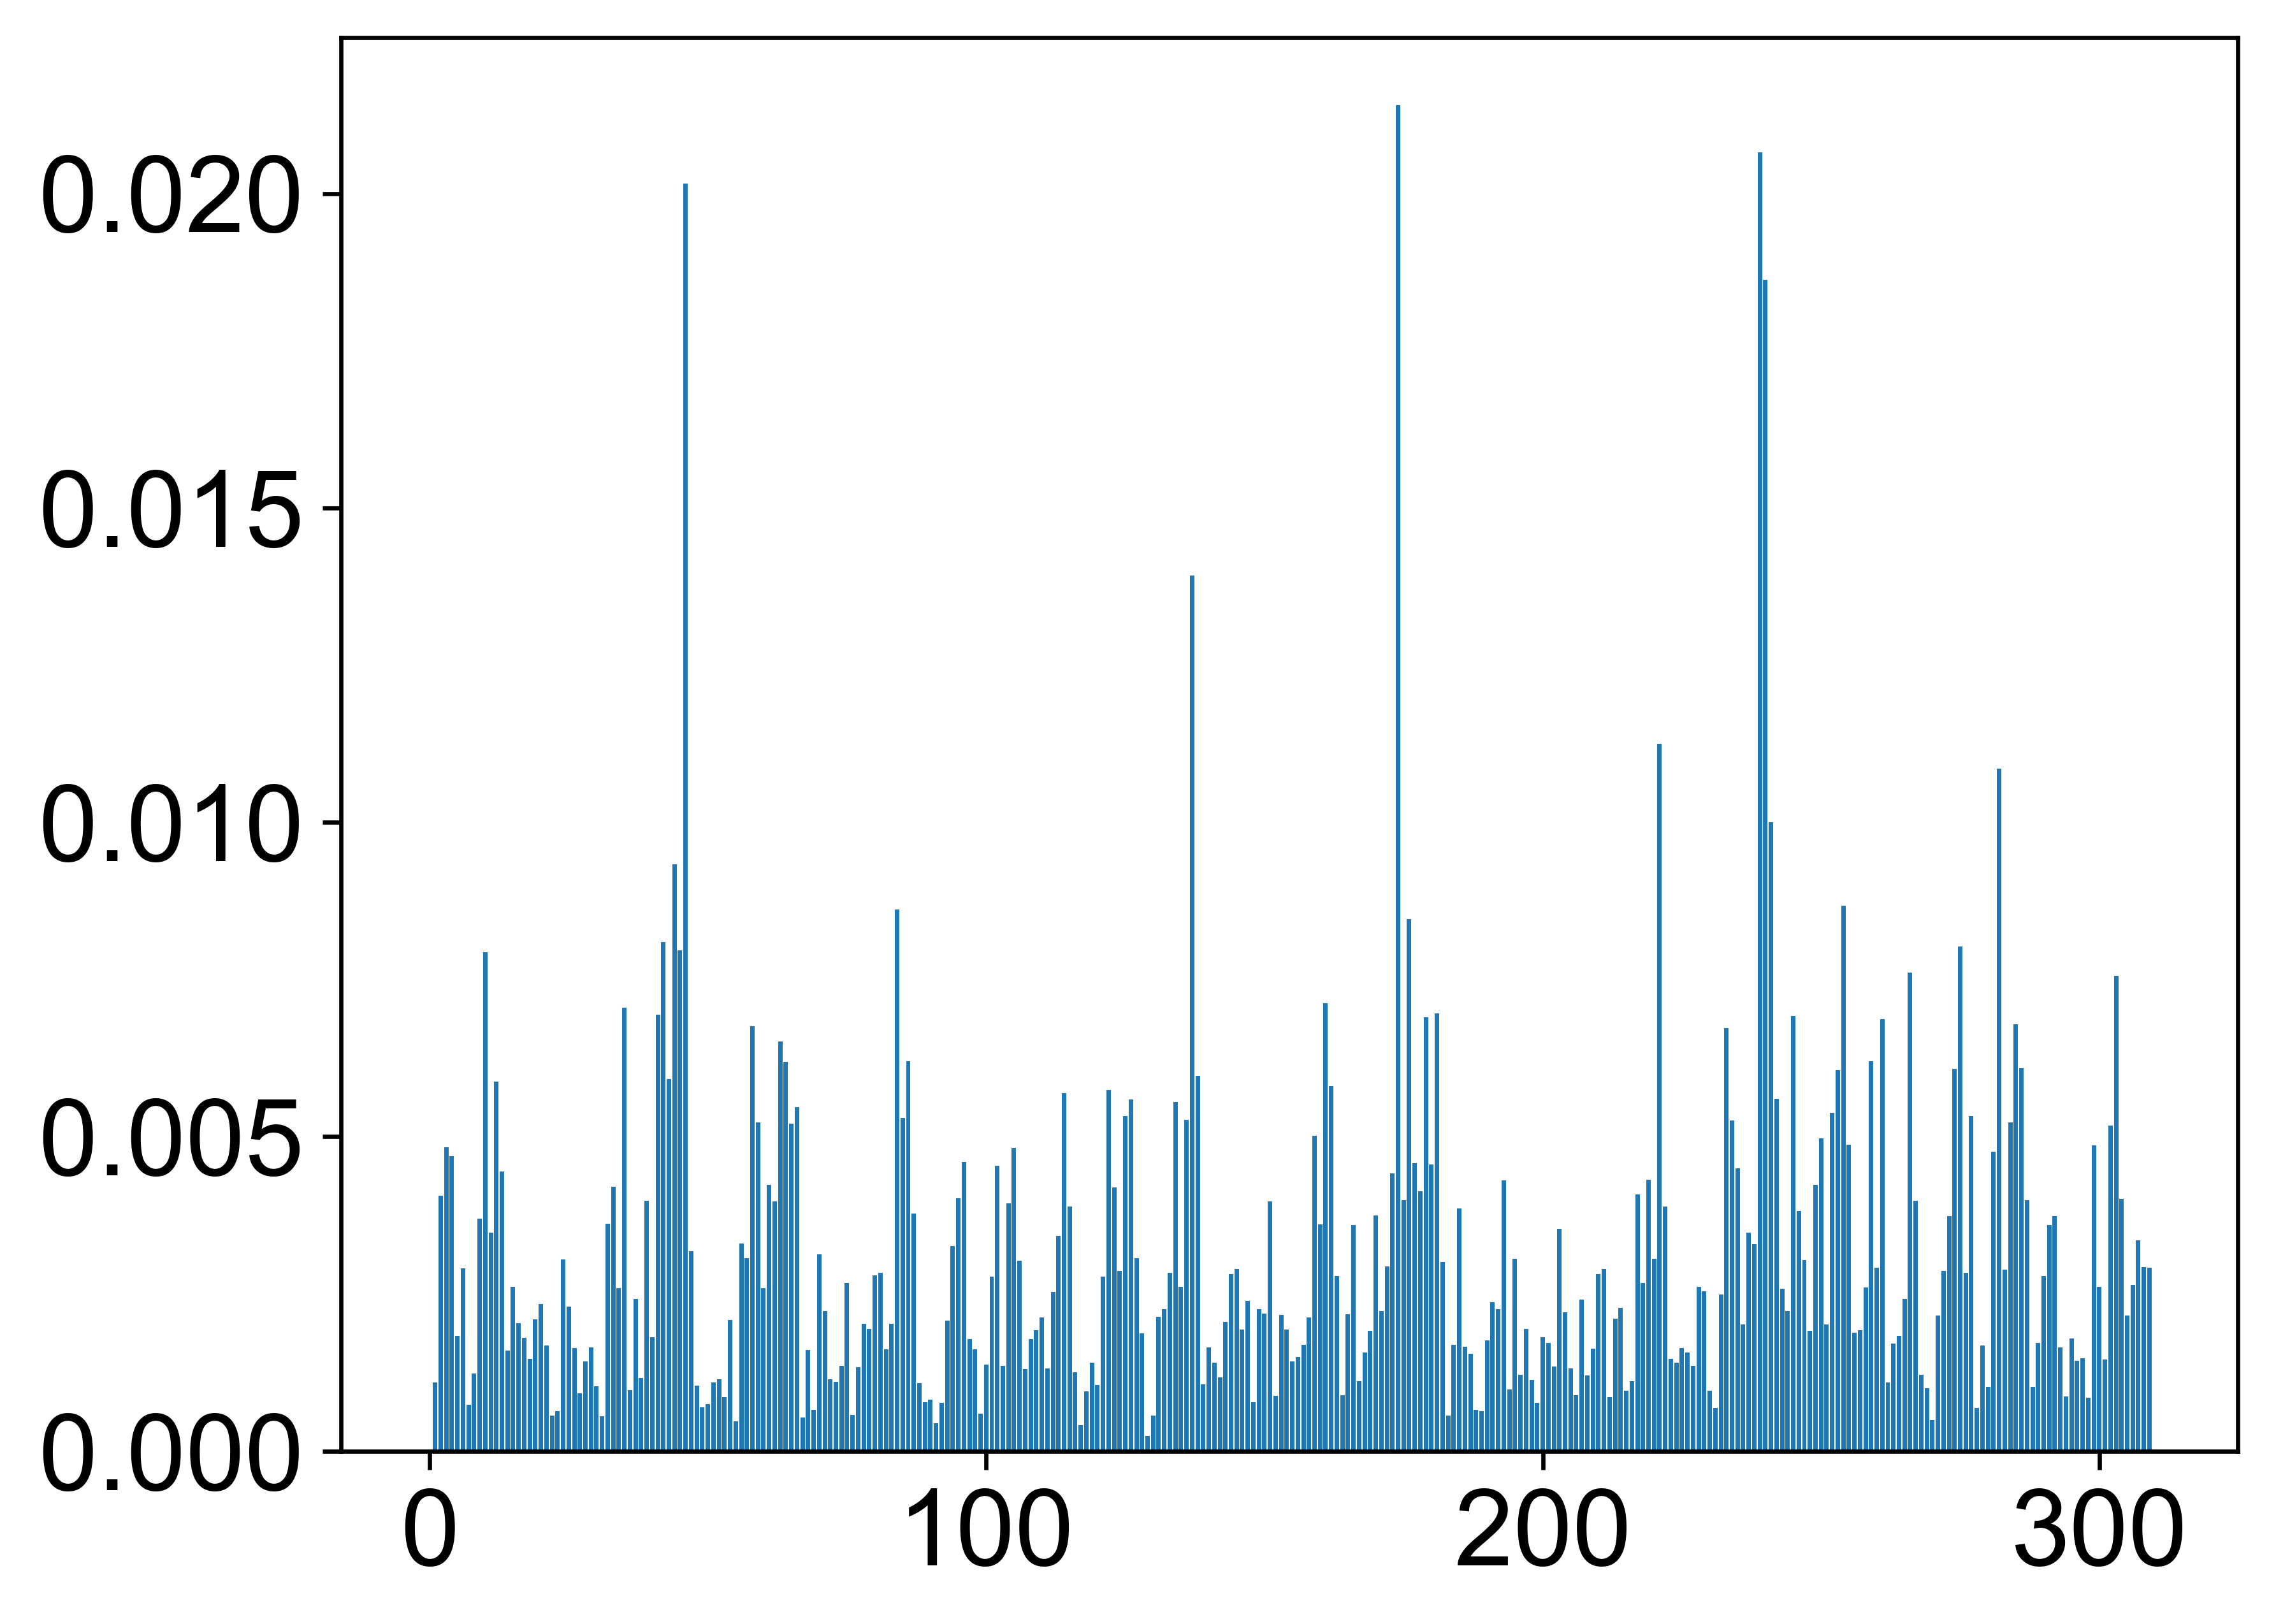

y9
CNN_trainデータの決定係数0.9233230997736012
CNN_testデータの決定係数0.46345642585054536


<Figure size 3840x2880 with 0 Axes>

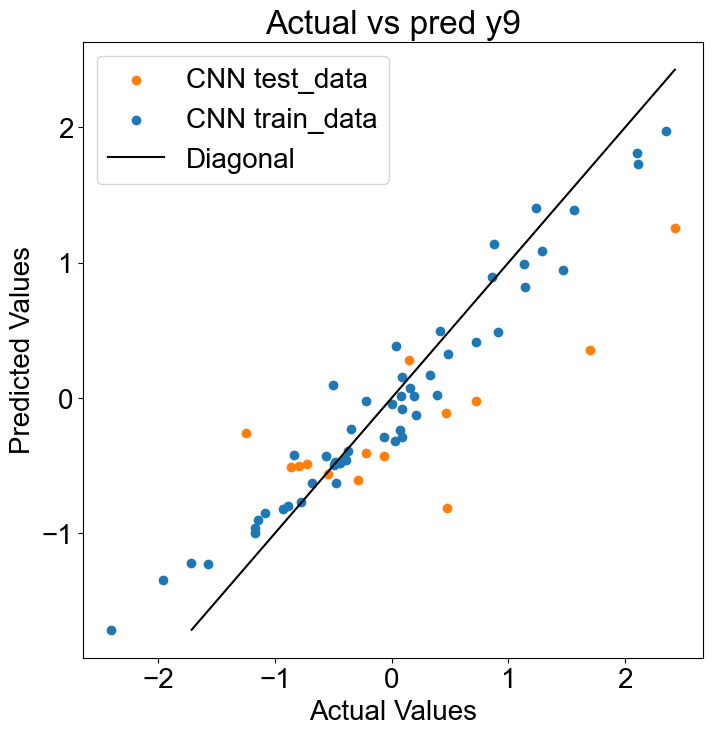

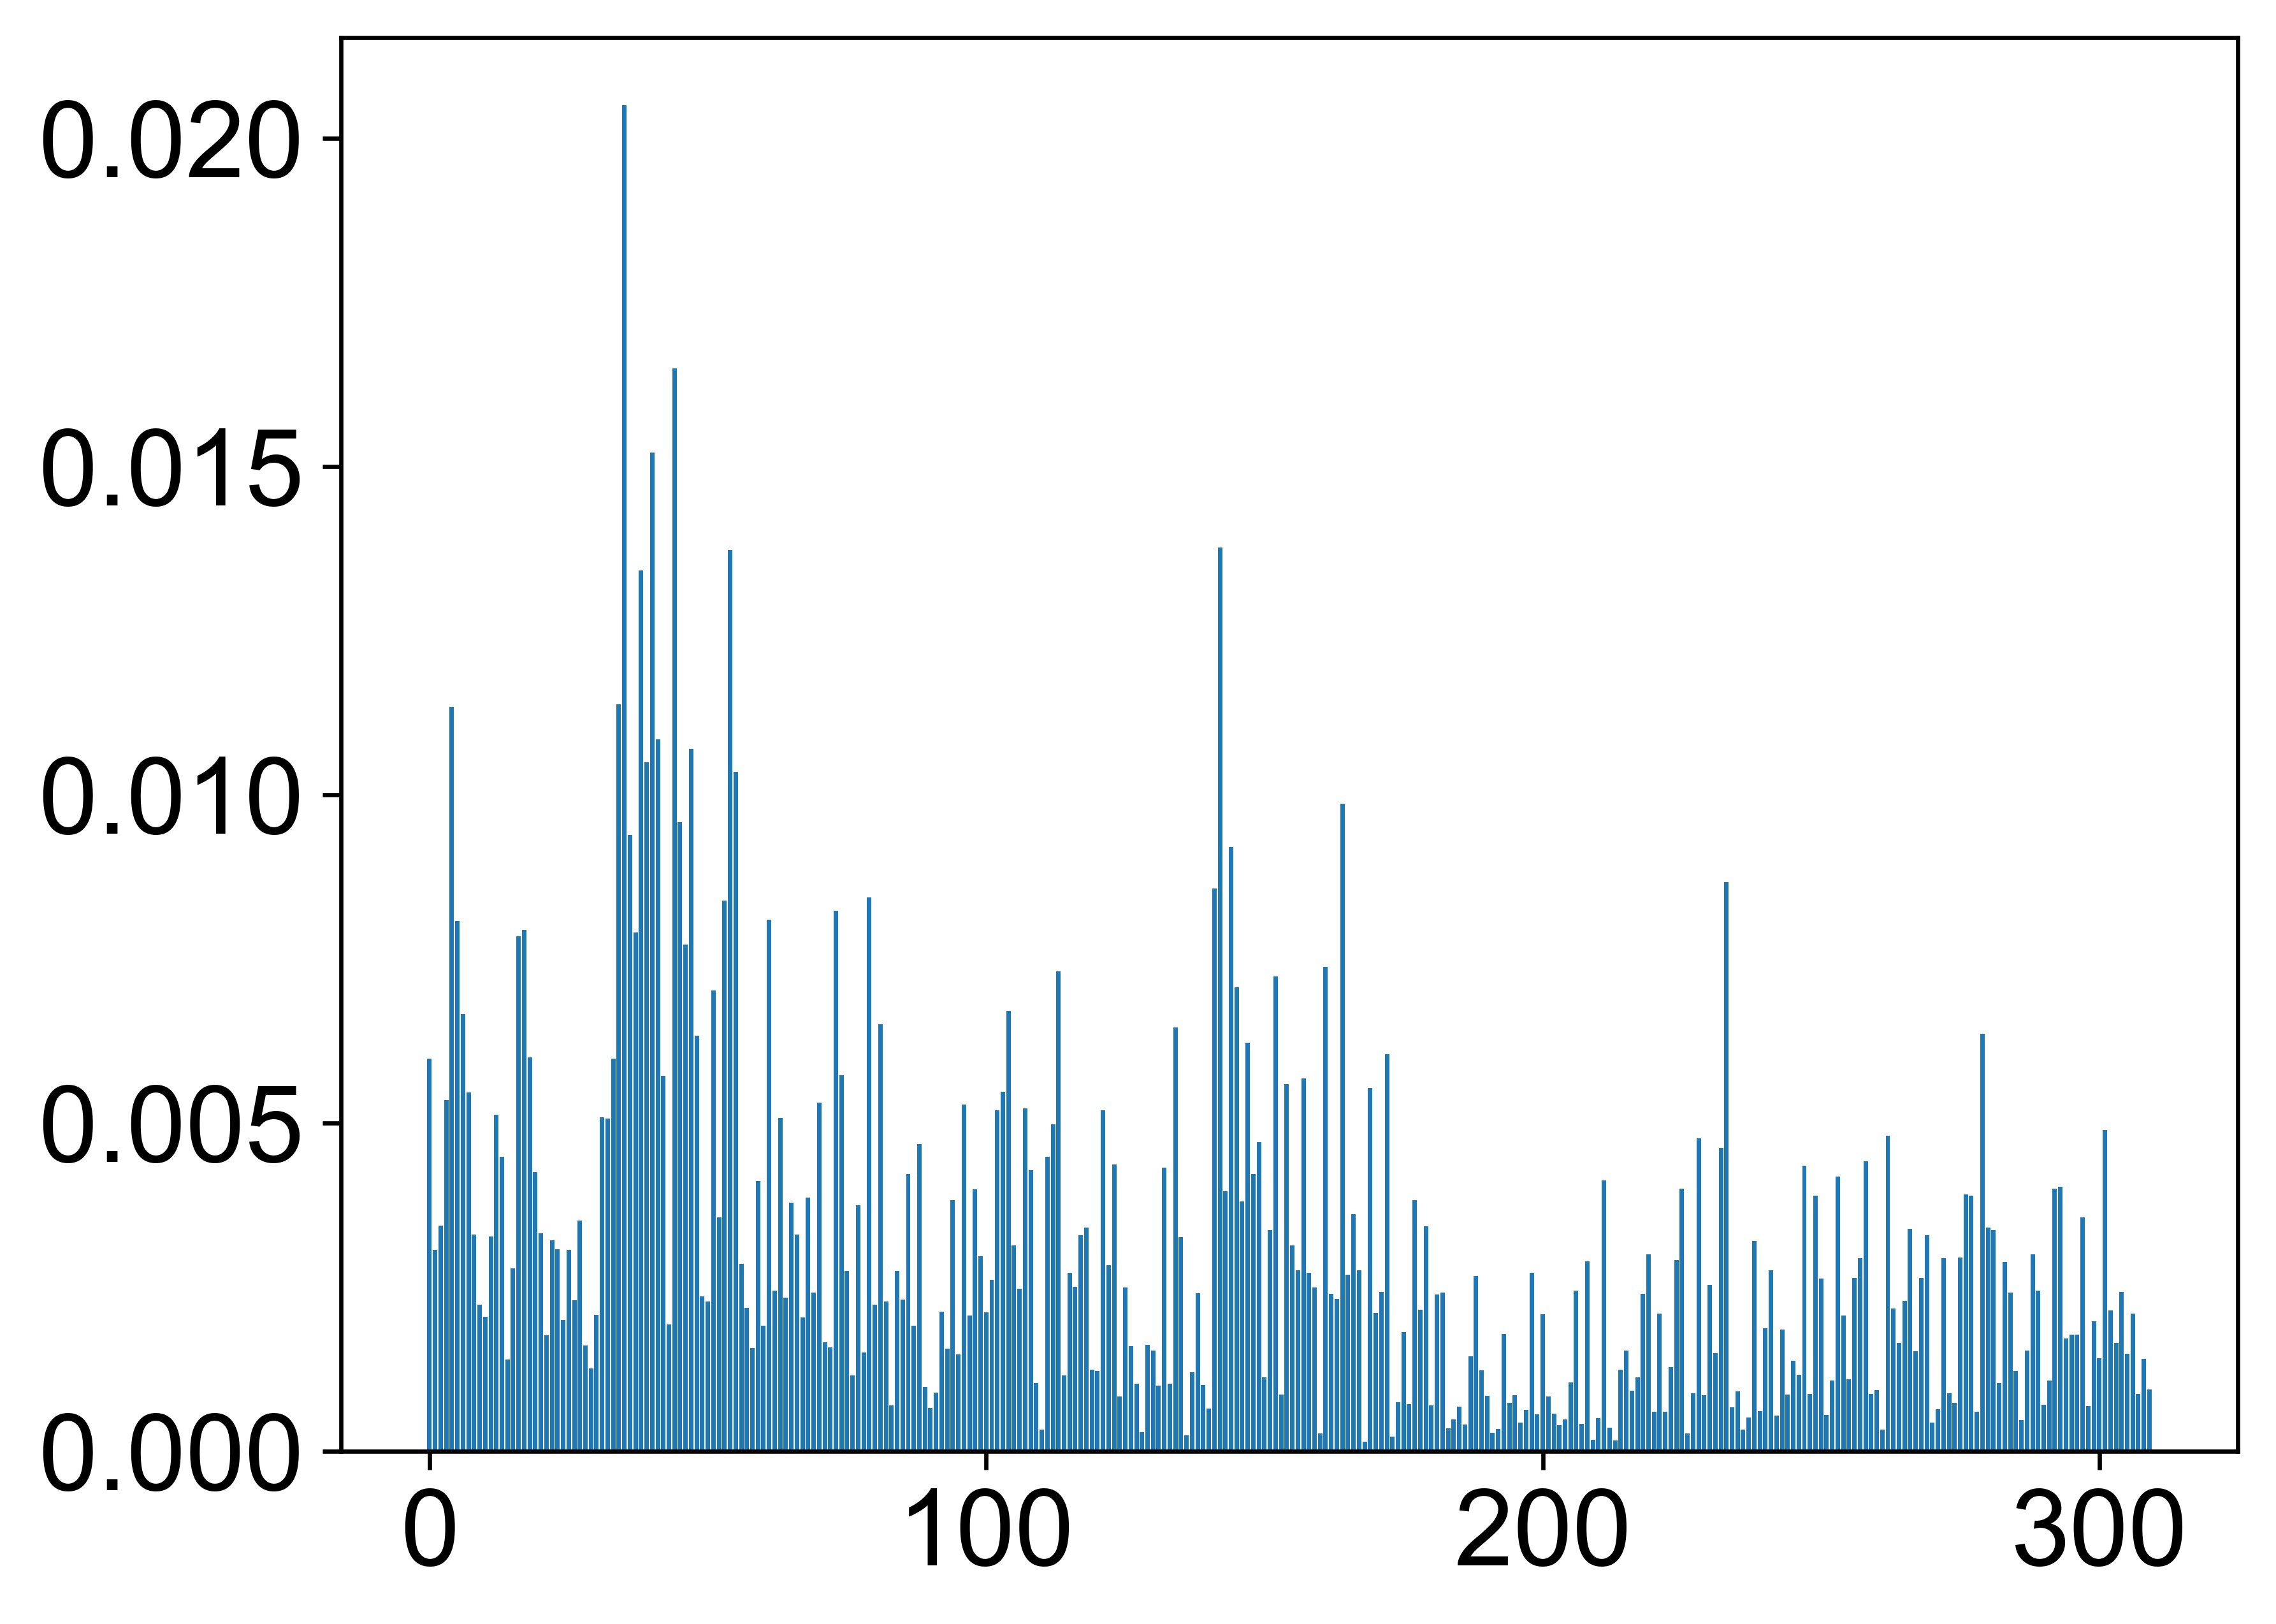

trainデータの決定係数0.9168559015119786
testデータの決定係数0.49884621411385666


<Figure size 3840x2880 with 0 Axes>

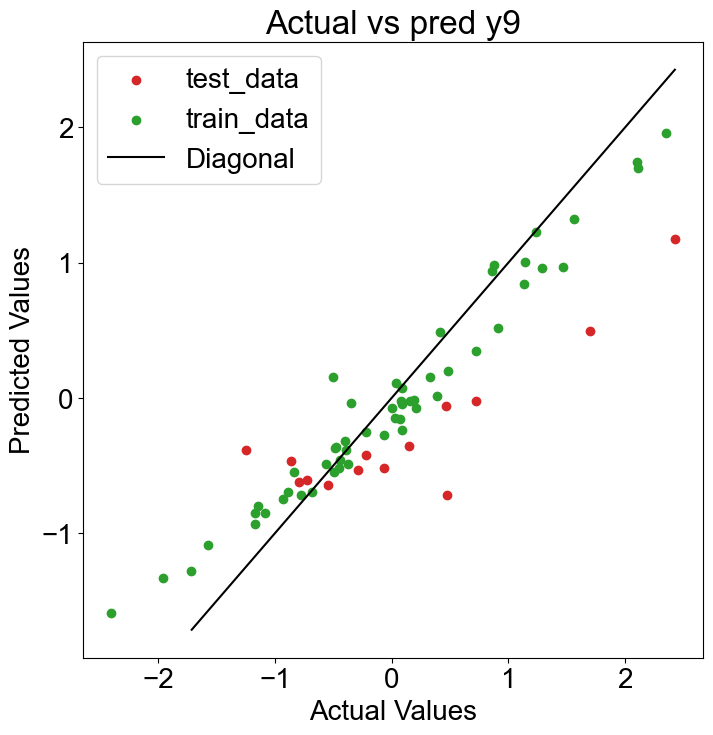

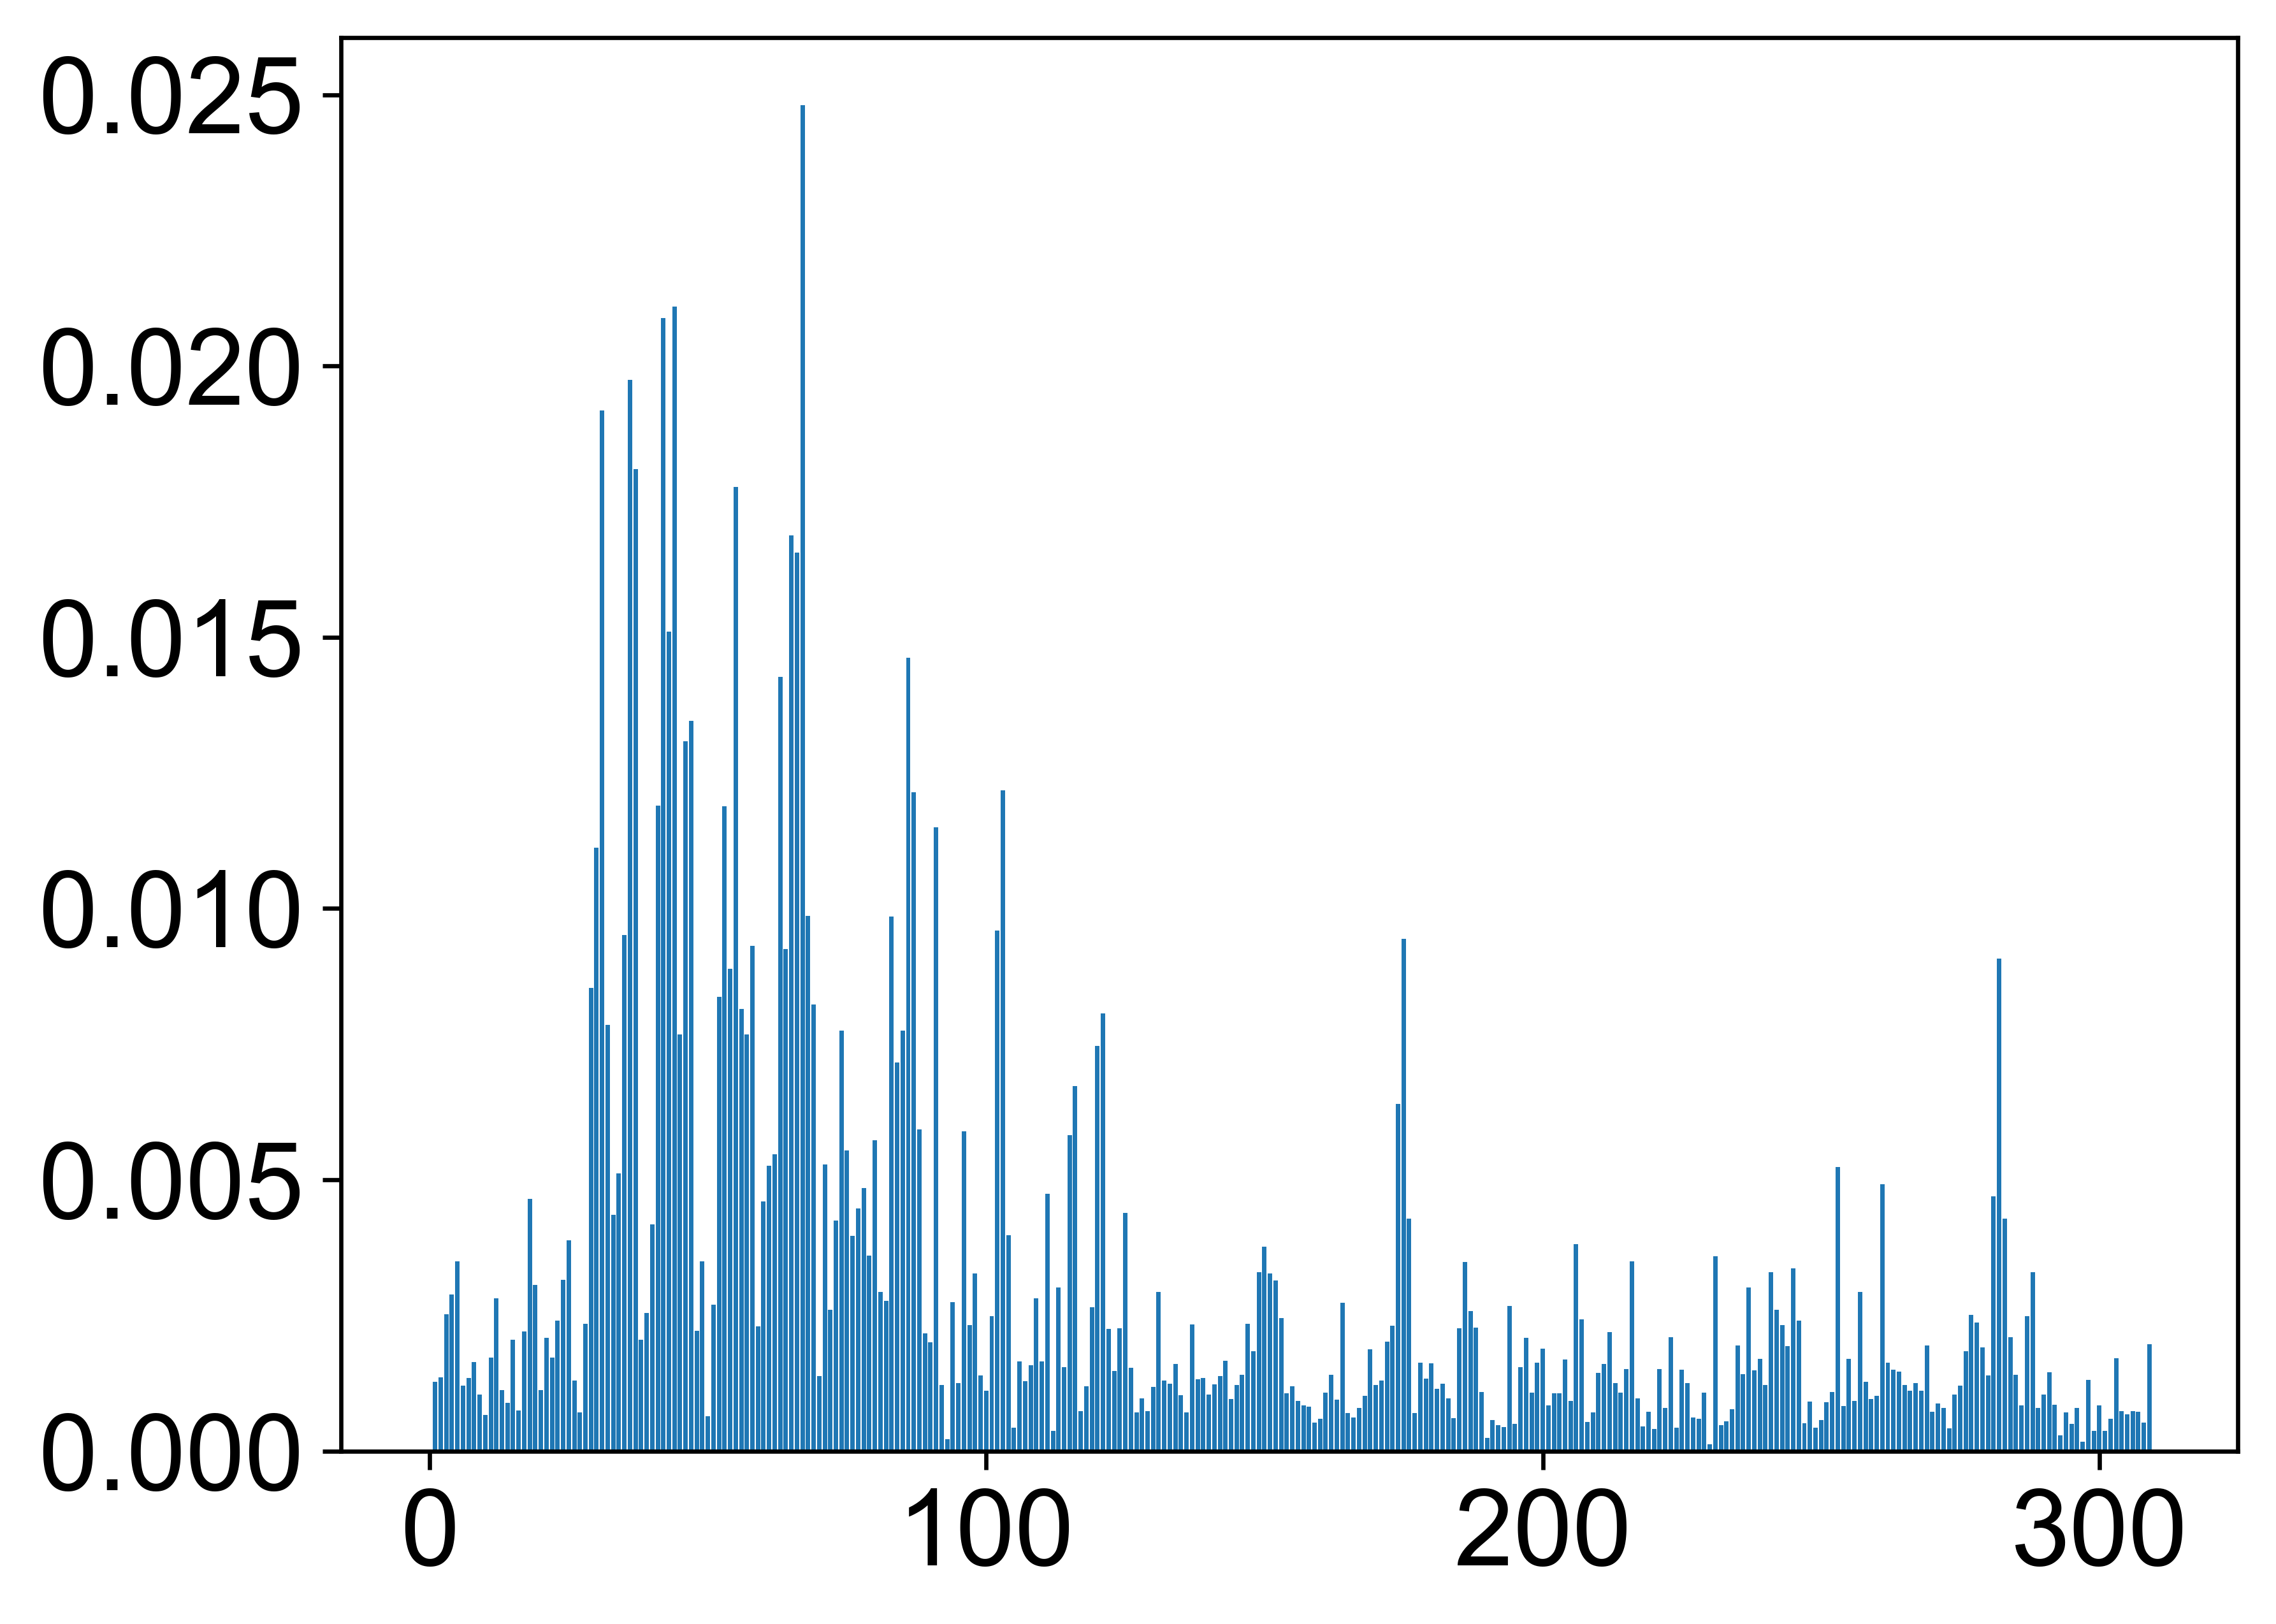

[np.float64(0.15726386624958058), np.float64(0.15605695013784143), np.float64(0.24457091493699434), np.float64(0.24420465937395971), np.float64(0.22849058261807256), np.float64(0.2696363628388539), np.float64(0.31782473376546694), np.float64(0.42690108436950397), np.float64(0.2777269200172084)]
[np.float64(0.2132697862220285), np.float64(0.19119445403184993), np.float64(0.2366998210729393), np.float64(0.2695057595696367), np.float64(0.22889207574804926), np.float64(0.26799201262045197), np.float64(0.30518104330112783), np.float64(0.4284145350175924), np.float64(0.2892020841766693)]

[np.float64(0.3806000847475704), np.float64(1.0938764264528749), np.float64(0.8441617428322759), np.float64(0.41661084097102424), np.float64(0.8115428856534412), np.float64(0.7551651645045346), np.float64(0.7949559892195172), np.float64(0.6892486860951842), np.float64(0.7207638506184517)]
[np.float64(0.8512629724568073), np.float64(1.4200549904936717), np.float64(1.044071259686016), np.float64(0.87164939299

In [29]:
RFR_train_RMSE_CNN=[]
RFR_test_RMSE_CNN=[]
RFR_train_CNN_R2=[]
RFR_test_CNN_R2=[]

RFR_train_RMSE=[]
RFR_test_RMSE=[]
RFR_train_R2=[]
RFR_test_R2=[]

tab10_color=plt.get_cmap("tab10")
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20

for i in range(1,10,1):
    #CNNを利用したRamdomforestの予測
    print(f"y{i}")
    SS_Y=StandardScaler()
    SS_Y.fit(np.array(physics_data[f"y{i}"]).reshape(-1,1))
    ss_y=SS_Y.transform(np.array(physics_data[f"y{i}"]).reshape(-1,1)).reshape(-1)


    X_train_CNN,X_test_CNN,y_train,y_test=train_test_split(ss_CNN_pred,ss_y,test_size=0.2,random_state=42)

    rfr=RFR(n_estimators=300,max_features='sqrt')
    rfr.fit(X_train_CNN,y_train)
    y_train_CNN_pred2=rfr.predict(X_train_CNN)
    y_test_CNN_pred2=rfr.predict(X_test_CNN)

    #trainに対して決定係数を求める
    print("CNN_trainデータの決定係数{}".format(r2_score(y_train,y_train_CNN_pred2)))
    RFR_train_RMSE_CNN.append(RMSE(y_train,y_train_CNN_pred2))
    RFR_train_CNN_R2.append(r2_score(y_train,y_train_CNN_pred2))
    #testに対して決定係数を求める
    print("CNN_testデータの決定係数{}".format(r2_score(y_test,y_test_CNN_pred2)))
    RFR_test_RMSE_CNN.append(RMSE(y_test,y_test_CNN_pred2))
    RFR_test_CNN_R2.append(r2_score(y_test,y_test_CNN_pred2))

    plt.figure(dpi=600)
    plt.figure(figsize=(8,8))

    plt.scatter(y_test, y_test_CNN_pred2,label="CNN test_data",color=tab10_color(1))
    plt.scatter(y_train,y_train_CNN_pred2,label="CNN train_data",color=tab10_color(0))
    min_value = min(min(y_test), min(y_train_CNN_pred2))
    max_value = max(max(y_test), max(y_train_CNN_pred2))
    diagonal_values = np.linspace(min_value, max_value, num=100)
    plt.plot(diagonal_values, diagonal_values, color='black', label='Diagonal')

    plt.title(f"Actual vs pred y{i}")
    
    plt.xlabel('Actual Values',fontsize=20)
    plt.ylabel('Predicted Values',fontsize=20)
    plt.legend()

    plt.show()

    #Fearure Importance 分布
    plt.figure(dpi=600)
    plt.bar([i for i in range(len(rfr.feature_importances_))],rfr.feature_importances_)
    plt.show()

    #生データからのRamdomForestの予測
    X_train,X_test,y_train,y_test=train_test_split(ss_x,ss_y,test_size=0.2,random_state=42)

    rfr=RFR(n_estimators=300,max_features='sqrt')
    rfr.fit(X_train,y_train)
    y_train_pred=rfr.predict(X_train)
    y_test_pred2=rfr.predict(X_test)

    #trainに対して決定係数を求める
    print("trainデータの決定係数{}".format(r2_score(y_train,y_train_pred)))
    RFR_train_RMSE.append(RMSE(y_train,y_train_pred))
    RFR_train_R2.append(r2_score(y_train,y_train_pred))
    #testに対して決定係数を求める
    print("testデータの決定係数{}".format(r2_score(y_test,y_test_pred2)))
    RFR_test_RMSE.append(RMSE(y_test,y_test_pred2))
    RFR_test_R2.append(r2_score(y_test,y_test_pred2))

    plt.figure(dpi=600)
    plt.figure(figsize=(8,8))
    plt.scatter(y_test, y_test_pred2,label="test_data",color=tab10_color(3))
    plt.scatter(y_train,y_train_pred,label="train_data",color=tab10_color(2))
    min_value = min(min(y_test), min(y_train_CNN_pred2))
    max_value = max(max(y_test), max(y_train_CNN_pred2))
    diagonal_values = np.linspace(min_value, max_value, num=100)
    plt.plot(diagonal_values, diagonal_values, color='black', label='Diagonal')

    plt.title(f"Actual vs pred y{i}")
    
    plt.xlabel('Actual Values',fontsize=20)
    plt.ylabel('Predicted Values',fontsize=20)
    plt.legend()

    plt.show()
    plt.show()

    plt.figure(dpi=600)
    plt.bar([i for i in range(len(rfr.feature_importances_))],rfr.feature_importances_)
    plt.show()




print(RFR_train_RMSE_CNN)


print(RFR_train_RMSE)
print()
print(RFR_test_RMSE_CNN)
print(RFR_test_RMSE)


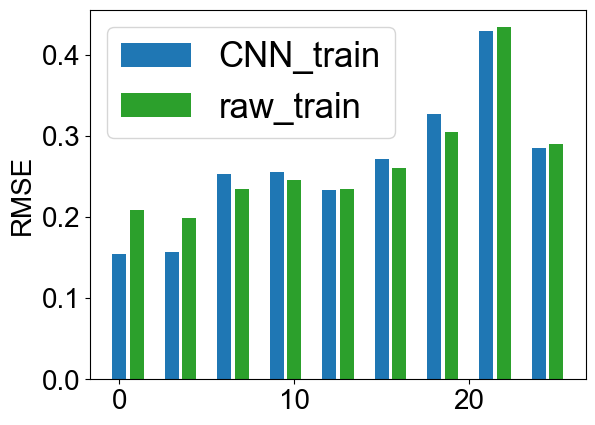

In [25]:
tab10_color=plt.get_cmap("tab10")


plt.bar([3*i for i in range(9)],RFR_train_RMSE_CNN,label="CNN_train",color=tab10_color(0))
plt.bar([3*i+1 for i in range(9)],RFR_train_RMSE,label="raw_train",color=tab10_color(2))
plt.ylabel("RMSE")

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 25

plt.legend()
plt.show()

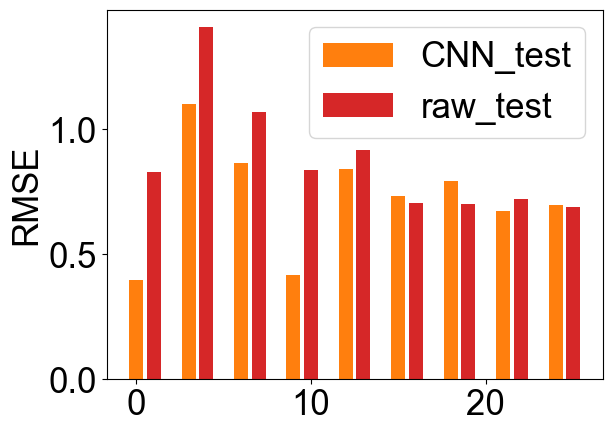

In [26]:
tab10_color=plt.get_cmap("tab10")

plt.bar([3*i for i in range(9)],RFR_test_RMSE_CNN,label="CNN_test",color=tab10_color(1))
plt.bar([3*i+1 for i in range(9)],RFR_test_RMSE,label="raw_test",color=tab10_color(3))
plt.ylabel("RMSE")

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 25
plt.legend()
plt.show()